# Trabajo de Fin de Grado (Jupyter Notebook)

**Universidad**: *Universidad de Las Palmas de Gran Canaria.*

**Titulación**: *Grado en Ingeniería Informática.*

**Título**: *Verificación en escenarios multinivel con presencia de robots asistentes.*

**Autor**: Kevin David Rosales Santana.

**Tutores**: Modesto Fernando Castrillón Santana y José Javier Lorenzo Navarro.

## Índice

[1. Introducción](#1.-Introducción)

[2. Desarrollo](#2.-Desarrollo)

- [2.1 Importe de los módulos](#2.1-Importe-de-los-módulos)
- [2.2 Carga de datos](#2.2-Carga-de-datos-(Módulo-fileindexer))
- [2.3 Generador de *frames*](#2.3-Generador-de-frames-(Módulo-framesgenerator))
- [2.4 Detector de caras](#2.4-Detector-de-caras-(Módulo-facedetector))
- [2.5 *Face embedding*](#2.5-Face-embedding-(Módulo-model))
- [2.6 Verificación mediante umbral y evaluación de resultados](#2.6-Verificación-mediante-umbral-y-evaluación-de-resultados)
- [2.7 Verificación mediante redes neuronales y evaluación de resultados](#2.7-Verificación-mediante-redes-neuronales-y-evaluación-de-resultados-(Módulo-verifiermodel))

[3. Conclusión](#3.-Conclusión)

## 1. Introducción

Este **cuaderno *Jupyter*** trata del desarrollo del proyecto sobre parte del *dataset* del ascensor (es decir, sobre el **Subconjunto de Vídeos B** mencionado en la memoria del Trabajo de Fin de Grado).

Véase para más información dicha memoria y el Manual de Usuario del proyecto.

## 2. Desarrollo

A continuación, se irá haciendo uso de los distintos módulos desarrollados para el presente Trabajo de Fin de Grado con el fin de construir los distintos prototipos y evaluar sus resultados. 

La implementación interna de cada uno de los dichos módulos puede analizarse en el mismo repositorio del proyecto.

Para más información, se puede consultar la memoria del Trabajo de Fin de Grado y el Manual de Usuario del proyecto.

### 2.1 Importe de los módulos

In [1]:
import random
import os
import numpy
import pickle

from dotenv import load_dotenv
from PIL import Image
from matplotlib import pyplot as plt

from facedetector import mtcnn_detector, dlib_detector
from fileindexer import file_indexer
from framesgenerator import frames_generator
from model import facenet_keras_model, vgg_face_model, embeddings_assembler
from distancematrixcalculator import distances_matrix_loader
from accuracymeter import accuracy_meter
from verifier import verifier
from verifiermodel import nnverifier

from utils import distance_plotter, distance_plotter_boxplot, threshold_plotter, confidence_plotter, \
                  detected_frames_generator, failed_frames_pairs_generator, nn_verifier_metrics_plotter

load_dotenv()
random.seed(os.getenv('RANDOM_SEED'))

Using TensorFlow backend.


### 2.2 Carga de datos (Módulo `fileindexer`)

In [2]:
file_indexer.create_indexer_files(files_pairs=1, training_identities_number=70, test_identities_number=41,
                                  cameras=(2,5,8), place=2)

[Creating indexer files... (1 files)]
[Indexer files made (1 file(s) pair(s))]


In [2]:
""" Lift Place (cameras 2, 5 & 8) """
test_file = 'out/file-indexer/2020_04_05-220558-test.txt'
train_file = 'out/file-indexer/2020_04_05-220558-train.txt'

### 2.3 Generador de *frames* (Módulo `framesgenerator`)

#### 2.3.1 Generador de *frames* para el fichero de entrenamiento

In [3]:
file_indexer_file = open(train_file)
videos = file_indexer_file.readlines()
train_videos_out = list()
for video in videos:
    frames_generator.generate_frames(video.strip())
    train_videos_out.append(os.path.splitext(video.replace("/", "-"))[0] + "/")
file_indexer_file.close()

[Getting frames from video 'D:/averobot/averobot/averobot_floor_01/03_01_02_01_02.mp4']
[Results folder already exists. Existing frames will not be updated]
[Getting frames from video 'D:/averobot/averobot/averobot_floor_02/03_02_02_30_05.mp4']
[Results folder already exists. Existing frames will not be updated]
[Getting frames from video 'D:/averobot/averobot/averobot_floor_03/03_03_02_20_08.mp4']
[Results folder already exists. Existing frames will not be updated]
[Getting frames from video 'D:/averobot/averobot/averobot_floor_01/34_01_02_04_02.mp4']
[Results folder already exists. Existing frames will not be updated]
[Getting frames from video 'D:/averobot/averobot/averobot_floor_02/34_02_02_08_05.mp4']
[Results folder already exists. Existing frames will not be updated]
[Getting frames from video 'D:/averobot/averobot/averobot_floor_03/34_03_02_24_08.mp4']
[Results folder already exists. Existing frames will not be updated]
[Getting frames from video 'D:/averobot/averobot/averobot_

#### 2.3.2 Generador de *frames* para el fichero de test

In [4]:
file_indexer_file = open(test_file)
videos = file_indexer_file.readlines()
test_videos_out = list()
for video in videos:
    frames_generator.generate_frames(video.strip())
    test_videos_out.append(os.path.splitext(video.replace("/", "-"))[0] + "/")
file_indexer_file.close()

[Getting frames from video 'D:/averobot/averobot/averobot_floor_01/59_01_02_04_02.mp4']
[Results folder already exists. Existing frames will not be updated]
[Getting frames from video 'D:/averobot/averobot/averobot_floor_02/59_02_02_10_05.mp4']
[Results folder already exists. Existing frames will not be updated]
[Getting frames from video 'D:/averobot/averobot/averobot_floor_03/59_03_02_11_08.mp4']
[Results folder already exists. Existing frames will not be updated]
[Getting frames from video 'D:/averobot/averobot/averobot_floor_01/51_01_02_19_02.mp4']
[Results folder already exists. Existing frames will not be updated]
[Getting frames from video 'D:/averobot/averobot/averobot_floor_02/51_02_02_15_05.mp4']
[Results folder already exists. Existing frames will not be updated]
[Getting frames from video 'D:/averobot/averobot/averobot_floor_03/51_03_02_25_08.mp4']
[Results folder already exists. Existing frames will not be updated]
[Getting frames from video 'D:/averobot/averobot/averobot_

### 2.4 Detector de caras (Módulo `facedetector`)

#### 2.4.1 Detección de caras usando MTCNN (`mtcnn_detector.py`)

#### 2.4.1.1 Detección de caras para el entrenamiento

In [5]:
mtcnn_d = mtcnn_detector.MTCNNDetector(max_detections=4, pickle_results=True, image_results=False, force_update=False, 
                                       normalize_face='resize', confidence_range=0.00001)

for video in train_videos_out:
    mtcnn_d.process_video(video.strip())

[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_01-03_01_02_01_02/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_02-03_02_02_30_05/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_03-03_03_02_20_08/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_01-34_01_02_04_02/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_02-34_02_02_08_05/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_03-34_03_02_24_08/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_01-21_01_02_01_02/']
[Results alre

[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_03-93_03_02_25_08/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_01-47_01_02_18_02/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_02-47_02_02_10_05/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_03-47_03_02_25_08/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_01-54_01_02_01_02/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_02-54_02_02_05_05/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/fra

[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_03-100_03_02_15_08/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_01-02_01_02_32_02/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_02-02_02_02_31_05/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_03-02_03_02_03_08/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_01-23_01_02_08_02/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_02-23_02_02_16_05/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/fr

[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_01-46_01_02_05_02/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_02-46_02_02_03_05/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_03-46_03_02_17_08/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_01-24_01_02_32_02/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_02-24_02_02_08_05/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_03-24_03_02_10_08/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/fra

#### 2.4.1.2 Detección de caras para el test

In [6]:
mtcnn_d = mtcnn_detector.MTCNNDetector(max_detections=4, pickle_results=True, image_results=False, force_update=False, 
                                       normalize_face='resize', confidence_range=0.00001)

for video in test_videos_out:
    mtcnn_d.process_video(video.strip())

[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_01-59_01_02_04_02/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_02-59_02_02_10_05/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_03-59_03_02_11_08/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_01-51_01_02_19_02/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_02-51_02_02_15_05/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_03-51_03_02_25_08/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_01-37_01_02_08_02/']
[Results alre

[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_02-45_02_02_06_05/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_03-45_03_02_10_08/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_01-48_01_02_04_02/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_02-48_02_02_05_05/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_03-48_03_02_25_08/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/frames-generator/averobot_floor_01-49_01_02_08_02/']
[Results already exists. Existing results will not be updated]
[Detecting faces from 'D:/TFG/out/fra

#### 2.4.2 Detección de caras usando DLIB (`dlib_detector.py`)

#### 2.4.2.1 Detección de caras para el entrenamiento (usando el detector *HOG* y *MMOD*)

Como se mencionó en la memoria, el detector DLIB-HOG tiene ciertas dificultades a la hora de detectar alguna muestra en determinados vídeos si estos son de baja calidad (incluso realizando *upsampling*). Por ello, los prototipos basados en sus detecciones en este proyecto se consideran inestables y carentes de robustez. A continuación, se adjunta un comentario con un ejemplo de detección fallida usando HOG en este módulo desarrollado `facedetector` (concretamente, en el fichero `dlib_detector.py`). 

In [6]:
# [Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_02-05_02_02_32_05/']
# [ERROR: detection list is empty. Pickle file could not be generated] (HOG Detector)

dlib_d = dlib_detector.DLIBDetector(max_detections=4, pickle_results=True, image_results=False, force_update=False, 
                                    detector_type='hog', confidence_range=0.003)

for video in train_videos_out:
    dlib_d.process_video(video.strip())

[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_01-03_01_02_01_02/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_02-03_02_02_30_05/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_03-03_03_02_20_08/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_01-34_01_02_04_02/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_02-34_02_02_08_05/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_03-34_03_02_24_08/']
Results already ex

In [7]:
dlib_d = dlib_detector.DLIBDetector(max_detections=4, pickle_results=True, image_results=False, force_update=False, 
                                    detector_type='mmod', confidence_range=0.002)

for video in train_videos_out:
    dlib_d.process_video(video.strip())

[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_01-03_01_02_01_02/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_02-03_02_02_30_05/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_03-03_03_02_20_08/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_01-34_01_02_04_02/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_02-34_02_02_08_05/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_03-34_03_02_24_08/']
Results already ex

Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_02-14_02_02_10_05/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_03-14_03_02_29_08/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_01-85_01_02_10_02/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_02-85_02_02_25_05/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_03-85_03_02_08_08/']
Results already exists. Existing results will not be updated]


#### 2.4.2.2 Detección de caras para el test (usando el detector *HOG* y *MMOD*)

In [6]:
dlib_d = dlib_detector.DLIBDetector(max_detections=4, pickle_results=True, image_results=False, force_update=False, 
                                    detector_type='hog', confidence_range=0.003)

for video in test_videos_out:
    dlib_d.process_video(video.strip())

[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_01-59_01_02_04_02/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_02-59_02_02_10_05/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_03-59_03_02_11_08/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_01-51_01_02_19_02/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_02-51_02_02_15_05/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_03-51_03_02_25_08/']
Results already ex

In [7]:
dlib_d = dlib_detector.DLIBDetector(max_detections=4, pickle_results=True, image_results=False, force_update=False, 
                                    detector_type='mmod', confidence_range=0.002)

for video in test_videos_out:
    dlib_d.process_video(video.strip())

[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_01-59_01_02_04_02/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_02-59_02_02_10_05/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_03-59_03_02_11_08/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_01-51_01_02_19_02/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_02-51_02_02_15_05/']
Results already exists. Existing results will not be updated]
[Detecting faces from 'C:/Users/kevin/IdeaProjects/TFG/out/frames-generator/averobot_floor_03-51_03_02_25_08/']
Results already ex

#### 2.4.3 Generación de los *frames* con caras usadas en el *embedding* para evitar volver a detectar todos los frames de los vídeos (Mediante `utils.detected_frames_generator`)

In [8]:
detected_frames_generator.generate_detected_frames(frames_directory='detected-frames-mtcnn-recalculate-test/',
                                                   detector='mtcnn', 
                                                   frames_folders_names=test_videos_out)

[Detected frames have been stored in 'D:/TFG/out/detected-frames-mtcnn-recalculate-test/']


0

#### 2.4.4 Cálculo simple de FNR (*False Negative Rate*) y FPR (*False Positive Rate*) en las detecciones

A continuación se adjunta un pequeño ejemplo del estudio del FNR (*False Negative Rate*) y del FPR (*False Positive Rate*) en los detectores.

In [7]:
""" 
[Study case example]

###### Example data ######
Number of video frames: 100
Number of video frames with a face: 75 (true positive samples = TP)
Number of video frames without a face: 100 - TP = 100 - 75 = 25 (true negative samples = TN)

###### Detector results example #####
Number of frames detected without a face (false positive samples = FP): 0
Number of frames detected with a face: 65 (detector positive result length = DPRL)
Number of non-detected frames that could have been detected (false negative samples = FN): TP - DPRL = 75 - 65 = 10
"""

mtcnn_detector.get_false_negative_rate(false_negative_samples=10, true_positive_samples=75)
mtcnn_detector.get_false_positive_rate(false_positive_samples=0, true_negative_samples=25)

False negative rate: 0.11764705882352941
False positive rate: 0.0


### 2.5 *Face embedding* (Módulo `model`)

#### 2.5.1 *Face embedding* a través de *FaceNet* (Mediante `model.facenet_keras_model`)

In [6]:
fkm = facenet_keras_model.FacenetKerasModel(norm_type='l2', embedding_type='resize', pickle_results=True, csv_results=True, 
                                            print_model_info=False, force_update=True)

for video in train_videos_out:
    data = fkm.predict_data(video, facenet_keras_model.load_pickle_results(video, embedding_type='resize'))

[Getting Face Embeddings from video 'averobot_floor_01-59_01_02_04_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01-59_01_02_04_02/']
[Getting Face Embeddings from video 'averobot_floor_02-59_02_02_10_05/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_02-59_02_02_10_05/']
[Getting Face Embeddings from video 'averobot_floor_03-59_03_02_11_08/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-59_03_02_11_08/']
[Getting Face Embeddings from video 'averobot_floor_01-51_01_02_19_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01-51_01_02_19_02/']
[Getting Face Embeddings from video 'averobot_floor_02-51_02_02_15_05/']

[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-52_03_02_28_08/']
[Getting Face Embeddings from video 'averobot_floor_01-16_01_02_01_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01-16_01_02_01_02/']
[Getting Face Embeddings from video 'averobot_floor_02-16_02_02_27_05/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_02-16_02_02_27_05/']
[Getting Face Embeddings from video 'averobot_floor_03-16_03_02_32_08/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-16_03_02_32_08/']
[Getting Face Embeddings from video 'averobot_floor_01-88_01_02_08_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01

[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-83_03_02_04_08/']
[Getting Face Embeddings from video 'averobot_floor_01-80_01_02_08_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01-80_01_02_08_02/']
[Getting Face Embeddings from video 'averobot_floor_02-80_02_02_27_05/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_02-80_02_02_27_05/']
[Getting Face Embeddings from video 'averobot_floor_03-80_03_02_30_08/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-80_03_02_30_08/']
[Getting Face Embeddings from video 'averobot_floor_01-09_01_02_26_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01

[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-15_03_02_27_08/']
[Getting Face Embeddings from video 'averobot_floor_01-92_01_02_01_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01-92_01_02_01_02/']
[Getting Face Embeddings from video 'averobot_floor_02-92_02_02_32_05/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_02-92_02_02_32_05/']
[Getting Face Embeddings from video 'averobot_floor_03-92_03_02_18_08/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-92_03_02_18_08/']
[Getting Face Embeddings from video 'averobot_floor_01-79_01_02_01_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01

#### 2.5.2 *Face embedding* a través de *VGGFace2* (Mediante `model.vgg_face_model`)

In [6]:
vfm = vgg_face_model.VGGFaceModel(norm_type='l2', embedding_type='resize', pickle_results=True, csv_results=True, 
                                  print_model_info=False, force_update=True)

for video in train_videos_out:
    data = vfm.predict_data(video, vgg_face_model.load_pickle_results(video, embedding_type='resize'))

[Getting Face Embeddings from video 'averobot_floor_01-03_01_02_01_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01-03_01_02_01_02/']
[Getting Face Embeddings from video 'averobot_floor_02-03_02_02_30_05/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_02-03_02_02_30_05/']
[Getting Face Embeddings from video 'averobot_floor_03-03_03_02_20_08/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-03_03_02_20_08/']
[Getting Face Embeddings from video 'averobot_floor_01-34_01_02_04_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01-34_01_02_04_02/']
[Getting Face Embeddings from video 'averobot_floor_02-34_02_02_08_05/']

[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-61_03_02_04_08/']
[Getting Face Embeddings from video 'averobot_floor_01-17_01_02_27_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01-17_01_02_27_02/']
[Getting Face Embeddings from video 'averobot_floor_02-17_02_02_29_05/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_02-17_02_02_29_05/']
[Getting Face Embeddings from video 'averobot_floor_03-17_03_02_28_08/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-17_03_02_28_08/']
[Getting Face Embeddings from video 'averobot_floor_01-05_01_02_08_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01

[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-12_03_02_22_08/']
[Getting Face Embeddings from video 'averobot_floor_01-40_01_02_08_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01-40_01_02_08_02/']
[Getting Face Embeddings from video 'averobot_floor_02-40_02_02_22_05/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_02-40_02_02_22_05/']
[Getting Face Embeddings from video 'averobot_floor_03-40_03_02_16_08/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-40_03_02_16_08/']
[Getting Face Embeddings from video 'averobot_floor_01-58_01_02_04_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01

[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-64_03_02_25_08/']
[Getting Face Embeddings from video 'averobot_floor_01-69_01_02_10_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01-69_01_02_10_02/']
[Getting Face Embeddings from video 'averobot_floor_02-69_02_02_28_05/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_02-69_02_02_28_05/']
[Getting Face Embeddings from video 'averobot_floor_03-69_03_02_22_08/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-69_03_02_22_08/']
[Getting Face Embeddings from video 'averobot_floor_01-44_01_02_02_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01

[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-111_03_02_19_08/']
[Getting Face Embeddings from video 'averobot_floor_01-84_01_02_11_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01-84_01_02_11_02/']
[Getting Face Embeddings from video 'averobot_floor_02-84_02_02_04_05/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_02-84_02_02_04_05/']
[Getting Face Embeddings from video 'averobot_floor_03-84_03_02_10_08/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-84_03_02_10_08/']
[Getting Face Embeddings from video 'averobot_floor_01-50_01_02_01_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_0

[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-46_03_02_17_08/']
[Getting Face Embeddings from video 'averobot_floor_01-24_01_02_32_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01-24_01_02_32_02/']
[Getting Face Embeddings from video 'averobot_floor_02-24_02_02_08_05/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_02-24_02_02_08_05/']
[Getting Face Embeddings from video 'averobot_floor_03-24_03_02_10_08/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_03-24_03_02_10_08/']
[Getting Face Embeddings from video 'averobot_floor_01-71_01_02_08_02/']
[WARNING: results already exists. Existing results will be updated]
[Face embeddings have been stored in 'D:/TFG/out/model/averobot_floor_01

#### 2.5.3 Guardado de todos los *embeddings* en un solo dataframe de *Pandas* con metadatos (Mediante `model.embeddings_assembler`)

In [8]:
embeddings_assembler.assemble_embeddings(train_videos_out, embedding_type='resize', pickle_results=True, 
csv_results=True, name='vggface_resize_lift_place_2_5_8_train')

[Embeddings Pandas DataFrame has been stored in 'D:/TFG/out/embeddings-assembler/']


video_id    id  floor         0         1  \
0    averobot_floor_01-03_01_02_01_02/   3.0    1.0  0.000045  0.000000   
1    averobot_floor_01-03_01_02_01_02/   3.0    1.0  0.001240  0.000000   
2    averobot_floor_01-03_01_02_01_02/   3.0    1.0  0.000010  0.000000   
3    averobot_floor_01-03_01_02_01_02/   3.0    1.0  0.000262  0.000000   
4    averobot_floor_02-03_02_02_30_05/   3.0    2.0  0.000000  0.000000   
..                                 ...   ...    ...       ...       ...   
835  averobot_floor_02-85_02_02_25_05/  85.0    2.0  0.009485  0.020554   
836  averobot_floor_03-85_03_02_08_08/  85.0    3.0  0.004677  0.029173   
837  averobot_floor_03-85_03_02_08_08/  85.0    3.0  0.001616  0.025540   
838  averobot_floor_03-85_03_02_08_08/  85.0    3.0  0.019543  0.031995   
839  averobot_floor_03-85_03_02_08_08/  85.0    3.0  0.010412  0.034785   

            2         3         4         5         6  ...      2038  \
0    0.012895  0.000000  0.000000  0.102817  0.000000  ...  0.002592   
1    0.002395  0.000000  0.000000  0.108144  0.000000  ...  0.005465   
2    0.001741  0.000000  0.000000  0.106489  0.000000  ...  0.003972   
3    0.007045  0.000000  0.000000  0.107771  0.000000  ...  0.005189   
4    0.000157  0.000000  0.000297  0.046582  0.000000  ...  0.001835   
..        ...       ...       ...       ...       ...  ...       ...   
835  0.000000  0.000000  0.018060  0.012768  0.007277  ...  0.000141   
836  0.010398  0.000000  0.003060  0.011206  0.026267  ...  0.015920   
837  0.006219  0.000000  0.003045  0.010203  0.034773  ...  0.017967   
838  0.003560  0.000000  0.016978  0.023746  0.029823  ...  0.017210   
839  0.005020  0.000478  0.006034  0.015156  0.027422  ...  0.018337   

         2039      2040      2041      2042      2043      2044      2045  \
0    0.000163  0.002750  0.000349  0.000000  0.008568  0.005270  0.022843   
1    0.000111  0.003586  0.000248  0.000000  0.002358  0.006572  0.034680   
2    0.000000  0.002219  0.000482  0.000000  0.014929  0.010154  0.034881   
3    0.000181  0.005047  0.000232  0.000000  0.001564  0.006494  0.020088   
4    0.000000  0.000000  0.000000  0.004419  0.024666  0.016584  0.006298   
..        ...       ...       ...       ...       ...       ...       ...   
835  0.004159  0.000663  0.000741  0.000000  0.030615  0.053299  0.044469   
836  0.000000  0.001493  0.000000  0.003014  0.026268  0.066660  0.032587   
837  0.000000  0.000460  0.000000  0.010320  0.027703  0.073062  0.021375   
838  0.000197  0.003266  0.000000  0.001552  0.020654  0.070676  0.032665   
839  0.000000  0.002391  0.000000  0.000971  0.024026  0.072014  0.033413   

         2046      2047  
0    0.000959  0.000775  
1    0.000309  0.000554  
2    0.000133  0.013163  
3    0.000492  0.000152  
4    0.000000  0.000149  
..        ...       ...  
835  0.000000  0.056128  
836  0.000000  0.049888  
837  0.000000  0.060148  
838  0.000000  0.042759  
839  0.000000  0.053911  

[840 rows x 2051 columns]

#### 2.5.4 Carga de todos los *embeddings* en un dataframe de *Pandas* (Mediante `model.embeddings_assembler`)

In [59]:
embeddings_assembler.load_panda_embeddings('2020-07-01_15-49-59-936685-facenet_no_norm_lift_place_2_5_8_train-data.pickle')

video_id    id  floor         0         1  \
0    averobot_floor_01-03_01_02_01_02/   3.0    1.0 -0.099994 -0.079486   
1    averobot_floor_01-03_01_02_01_02/   3.0    1.0 -0.095816 -0.073625   
2    averobot_floor_01-03_01_02_01_02/   3.0    1.0 -0.060718 -0.041842   
3    averobot_floor_01-03_01_02_01_02/   3.0    1.0 -0.094761 -0.045837   
4    averobot_floor_02-03_02_02_30_05/   3.0    2.0 -0.038124 -0.100561   
..                                 ...   ...    ...       ...       ...   
835  averobot_floor_02-85_02_02_25_05/  85.0    2.0  0.244139  0.000858   
836  averobot_floor_03-85_03_02_08_08/  85.0    3.0  0.241978  0.106208   
837  averobot_floor_03-85_03_02_08_08/  85.0    3.0  0.232828  0.108170   
838  averobot_floor_03-85_03_02_08_08/  85.0    3.0  0.263266  0.151511   
839  averobot_floor_03-85_03_02_08_08/  85.0    3.0  0.215569  0.110555   

            2         3         4         5         6  ...       118  \
0   -0.068787 -0.000179  0.019785  0.079251 -0.068473  ... -0.161561   
1   -0.044342  0.006515  0.029347  0.120873 -0.054548  ... -0.172681   
2   -0.075034 -0.057614  0.046641  0.117155 -0.064495  ... -0.178619   
3   -0.106359 -0.001019  0.024988  0.078929 -0.048709  ... -0.164324   
4   -0.024745 -0.130819  0.094670  0.055760  0.045573  ...  0.064697   
..        ...       ...       ...       ...       ...  ...       ...   
835  0.043893 -0.172902 -0.142345  0.022706  0.008027  ... -0.080502   
836  0.010865 -0.157694 -0.094213  0.085007  0.014610  ... -0.051551   
837 -0.008719 -0.147125 -0.061226  0.090203  0.037952  ... -0.064639   
838 -0.030912 -0.134872 -0.092762  0.094872  0.022905  ... -0.122776   
839 -0.050866 -0.128551 -0.170961  0.053482 -0.000038  ... -0.061287   

          119       120       121       122       123       124       125  \
0   -0.049201  0.073161  0.182291  0.116372 -0.052706 -0.102488  0.001764   
1   -0.057903  0.064411  0.181091  0.107574 -0.054737 -0.107833 -0.025903   
2   -0.057955  0.085036  0.208926  0.115798 -0.091751 -0.111384 -0.017776   
3   -0.020604  0.071364  0.177504  0.110418 -0.056854 -0.107954  0.000167   
4    0.014041 -0.052114  0.005550  0.122285  0.033138  0.109594 -0.114656   
..        ...       ...       ...       ...       ...       ...       ...   
835 -0.091692 -0.069760  0.125269  0.027710 -0.084233 -0.024408 -0.172308   
836 -0.114227 -0.135171  0.136333  0.098667 -0.085514  0.049200 -0.106749   
837 -0.104423 -0.139349  0.145680  0.116433 -0.101493  0.025985 -0.089023   
838 -0.056800 -0.081858  0.126559  0.125807 -0.085677 -0.018368 -0.104876   
839 -0.095377 -0.092859  0.101168  0.098660 -0.087208  0.042855 -0.108025   

          126       127  
0   -0.076522 -0.025347  
1   -0.049521 -0.006882  
2   -0.053295 -0.036019  
3   -0.007148 -0.005398  
4    0.093809  0.027807  
..        ...       ...  
835 -0.142532 -0.000288  
836 -0.158956 -0.008521  
837 -0.140688 -0.042557  
838 -0.181158 -0.033369  
839 -0.179415  0.012087  

[840 rows x 131 columns]

### 2.6 Verificación mediante umbral y evaluación de resultados

En esta sección se comenzará a comparar los distintos prototipos desarrollados para la verificación basada en umbral de distancia con el fin de observar cuál de ellos posee una mayor tasa de acierto y menor error en el objetivo del proyecto.

Todos los prototipos desarrollados se encuentran descritos en el **apartado 7.1.3** de la memoria del Trabajo de Fin de Grado.

#### 2.6.1 Evaluación de detección con *MTCNN* sin normalización y *embeddings* con 'l2'

##### 2.6.1.1 Carga de distancias euclídeas a través de los descriptores del dataframe construido (Módulo `distancematrixcalculator`)

In [60]:
no_face_norm_embeddings_train = embeddings_assembler.load_panda_embeddings('2020-07-01_15-49-59-936685-facenet_no_norm_lift_place_2_5_8_train-data.pickle')
# [same_video_results_list, same_video_euclidean_distance_list] = distances_matrix_loader.get_same_video_distance_matrices(no_face_norm_embeddings_train)
[same_person_results_list, same_person_euclidean_distance_list] = distances_matrix_loader.get_same_person_distance_matrices(no_face_norm_embeddings_train)
[different_people_results_list, different_people_euclidean_distance_list] = distances_matrix_loader.get_different_people_distance_matrices(no_face_norm_embeddings_train)


##### 2.6.1.2 Visualización de rangos de distancias euclídeas (Mediante `utils.distance_plotter`)

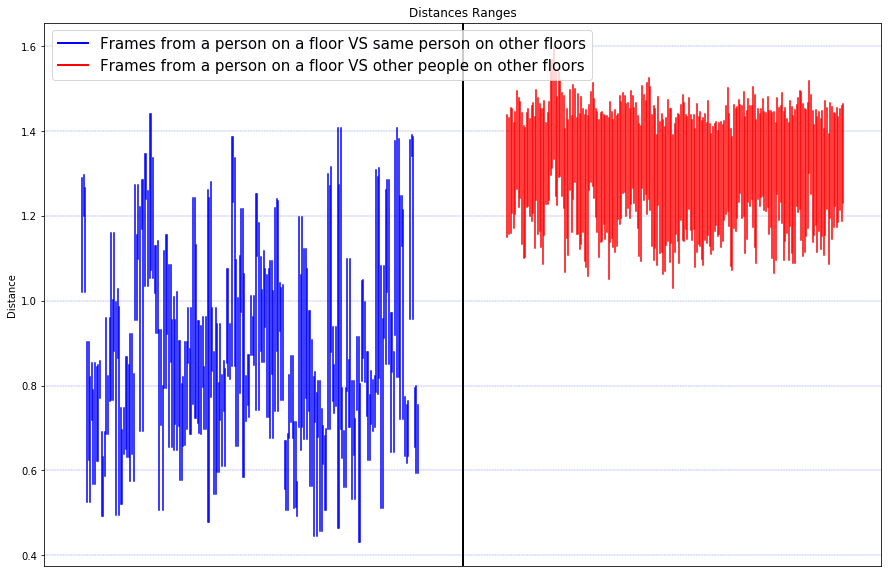

In [3]:
dp = distance_plotter.DistancePlotter(# same_video_results_list,
                                      same_person_results_list,
                                      different_people_results_list)
dp.draw_plot()

##### 2.6.1.3 Visualización de rangos de distancias euclídeas con *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

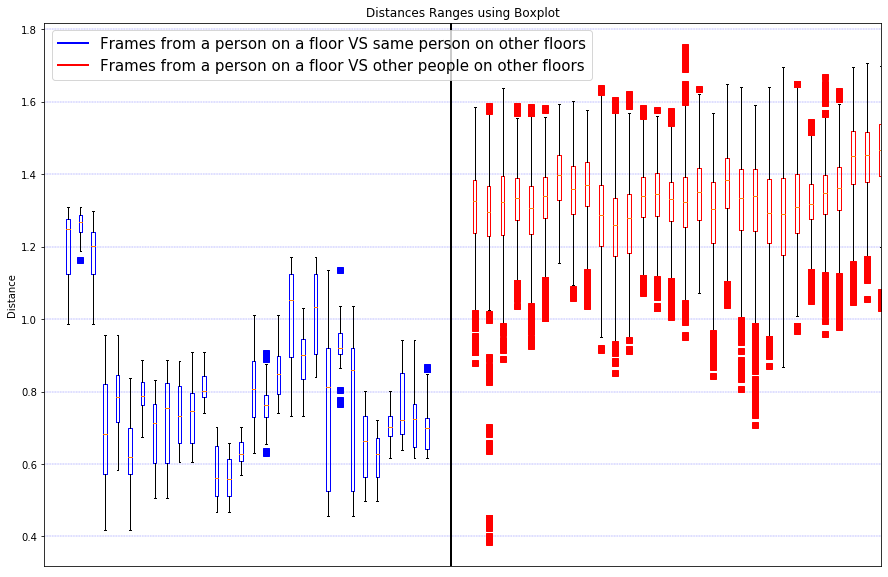

In [4]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# same_video_euclidean_distance_list[:30],
                                                      same_person_euclidean_distance_list[:30], 
                                                      different_people_euclidean_distance_list[:30])

dpb.draw_plot()


##### 2.6.1.4 Visualización de rangos de distancias euclídeas concentradas en únicamente dos *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

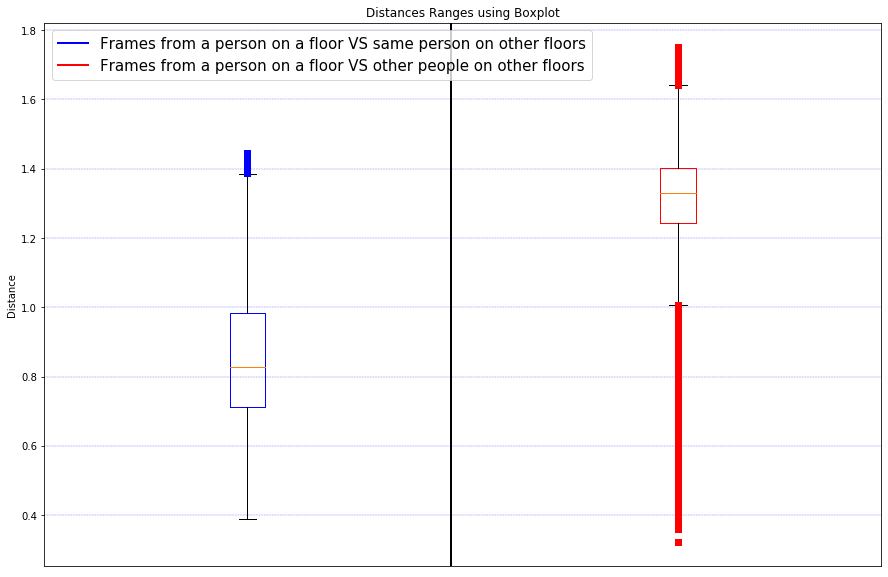

In [5]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# numpy.concatenate(same_video_euclidean_distance_list),
                                                      numpy.concatenate(same_person_euclidean_distance_list),
                                                      numpy.concatenate(different_people_euclidean_distance_list))
dpb.draw_plot()


##### 2.6.1.5 Cálculo del mejor umbral a través de *FAR*, *FRR* y *EER* (Módulo `thresholdvalidator` mediante `utils.threshold_plotter`)


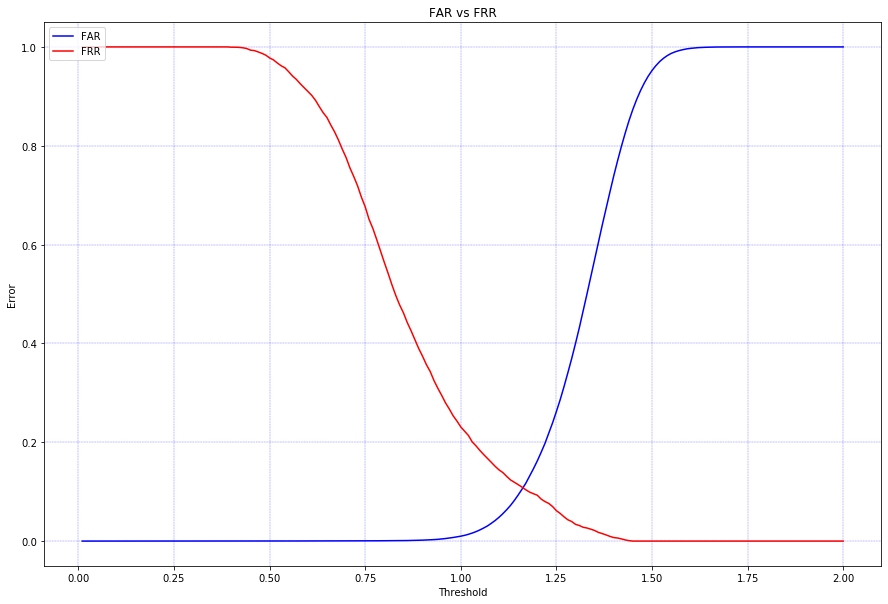


Best threshold: 1.16
EER: 0.105


In [6]:
tp = threshold_plotter.ThresholdPlotter(no_face_norm_embeddings_train, threshold_min=0.01, threshold_max=2)

tp.draw_plot()

best_threshold, eer = tp.calculate_best_threshold_and_eer() 

print("\nBest threshold:", best_threshold)
print("EER:", eer)

##### Obtención del dataframe y de pares de vídeos de personas iguales y distintas para el *dataset* formado por zonas del ascensor en cámaras 2, 5 y 8 (Módulo `accuracymeter`) (test)

In [61]:
no_face_norm_embeddings_test = embeddings_assembler.load_panda_embeddings('2020-07-01_15-50-09-827769-facenet_no_norm_lift_place_2_5_8_test-data.pickle')
same_person_videos_id_pairs_list_test = accuracy_meter.get_same_person_videos_ids_pairs(no_face_norm_embeddings_test)
different_person_videos_id_pairs_list_test = accuracy_meter.get_different_people_videos_ids_pairs(no_face_norm_embeddings_test)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list_test.sort()
different_person_videos_id_pairs_list_test.sort()
random.shuffle(same_person_videos_id_pairs_list_test)
random.shuffle(different_person_videos_id_pairs_list_test)
mixed_videos_id_pairs_list_test = same_person_videos_id_pairs_list_test.copy()
mixed_videos_id_pairs_list_test.extend(different_person_videos_id_pairs_list_test)

##### 2.6.1.6 Muestra gráfica del *accuracy* respecto al índice de confianza (Mediante `utils.confidence_plotter`)

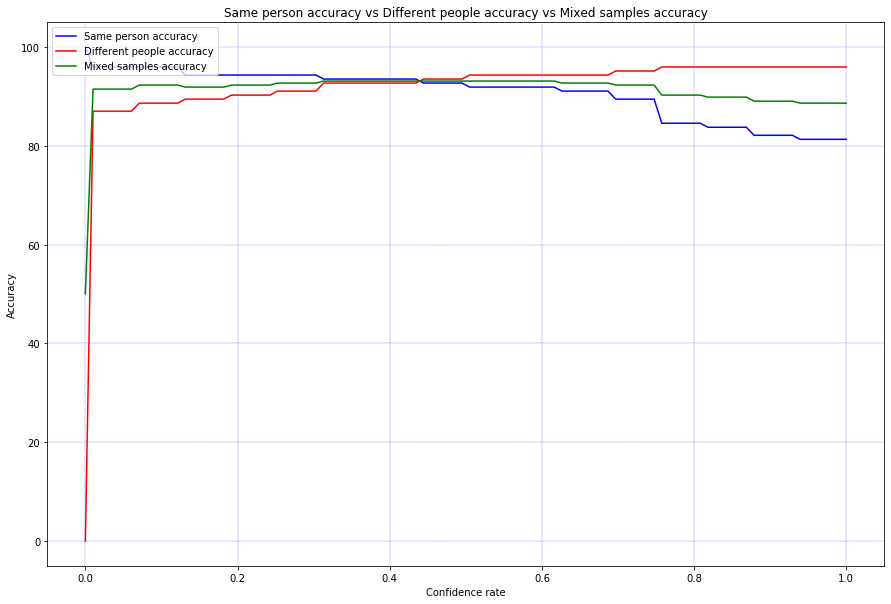


Best confidence rate: 0.313
Same person pairs accuracy:  93.496 %
Different people pairs accuracy:  92.683 %
Accuracy (with same number of same person pairs and different people pairs): 93.089 %


In [9]:
cp = confidence_plotter.ConfidencePlotter(no_face_norm_embeddings_test, same_person_videos_id_pairs_list_test,
                                          different_person_videos_id_pairs_list_test[:123], threshold=1.16)

cp.draw_plot()

results = cp.calculate_best_confidence_rate_and_accuracy() 

print("\nBest confidence rate:", results[0])
print("Same person pairs accuracy: ", results[1], "%")
print("Different people pairs accuracy: ", results[2], "%")
print("Accuracy (with same number of same person pairs and different people pairs):", results[3], "%")

##### 2.6.1.7 Medida del *accuracy* con el mejor índice de confianza en pares con misma persona, distinta persona y mezclados (Módulo `accuracymeter`)

In [10]:
same_person_videos_accuracy = accuracy_meter.get_accuracy(no_face_norm_embeddings_test, 
                                                          same_person_videos_id_pairs_list_test, 
                                                          confidence=0.313,
                                                          threshold=1.16,
                                                          print_iterations=True)

different_person_videos_accuracy = accuracy_meter.get_accuracy(no_face_norm_embeddings_test, 
                                                               different_person_videos_id_pairs_list_test, 
                                                               confidence=0.313,
                                                               threshold=1.16,
                                                               print_iterations=True)

mixed_videos_accuracy = accuracy_meter.get_accuracy(no_face_norm_embeddings_test, 
                                                    mixed_videos_id_pairs_list_test, 
                                                    confidence=0.313,
                                                    threshold=1.16,
                                                    print_iterations=True)

print()
print("Same person accuracy: " + str(same_person_videos_accuracy) + " %")
print("Different people accuracy: " + str(different_person_videos_accuracy) + " %")
print("Mixed videos accuracy (with different number of same person pairs and different people pairs): " + str(mixed_videos_accuracy) + " %")

[Getting accuracy (sample 5042/5043)]
Same person accuracy: 93.496 %
Different people accuracy: 90.0 %
Mixed videos accuracy (with different number of same person pairs and different people pairs): 90.085 %


##### 2.6.1.8 Varios test de funcionamiento de la verificación (Módulo `verifier`)

In [11]:
vf = verifier.Verifier(no_face_norm_embeddings_test, confidence=0.313, threshold=1.16)

sp_vipl_copy = same_person_videos_id_pairs_list_test.copy()
dp_vipl_copy = different_person_videos_id_pairs_list_test.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_02-32_02_02_27_05/ VS averobot_floor_03-32_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-59_01_02_04_02/ VS averobot_floor_03-59_03_02_11_08/:	{'is_same_person': False, 'confidence': 0.688}]
[averobot_floor_02-96_02_02_29_05/ VS averobot_floor_03-96_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-108_01_02_05_02/ VS averobot_floor_03-108_03_02_01_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-92_01_02_01_02/ VS averobot_floor_03-92_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-87_01_02_04_02/ VS averobot_floor_03-87_03_02_33_08/:	{'is_same_person': True, 'confidence': 0.812}]
[averobot_floor_01-90_01_02_01_02/ VS averobot_floor_03-90_03_02_11_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-16_01_02_01_02/ VS averobot_floor_03-16_03_02_32_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-90_01_02_0

#### 2.6.2 Evaluación de detección con *MTCNN* con redimensión de la imagen detectada y *embeddings* con 'l2'
 
 

##### 2.6.2.1 Carga de distancias euclídeas a través de los descriptores del sistema construido (Módulo `distancematrixcalculator`)

In [62]:
resize_face_embeddings_train = embeddings_assembler.load_panda_embeddings('2020-07-01_16-44-51-371301-facenet_resize_lift_place_2_5_8_train-data-resize.pickle')
# [same_video_results_list, same_video_euclidean_distance_list] = distances_matrix_loader.get_same_video_distance_matrices(resize_face_embeddings_train)
[same_person_results_list, same_person_euclidean_distance_list] = distances_matrix_loader.get_same_person_distance_matrices(resize_face_embeddings_train)
[different_people_results_list, different_people_euclidean_distance_list] = distances_matrix_loader.get_different_people_distance_matrices(resize_face_embeddings_train)


##### 2.6.2.2 Visualización de rangos de distancias euclídeas (Mediante `utils.distance_plotter`)

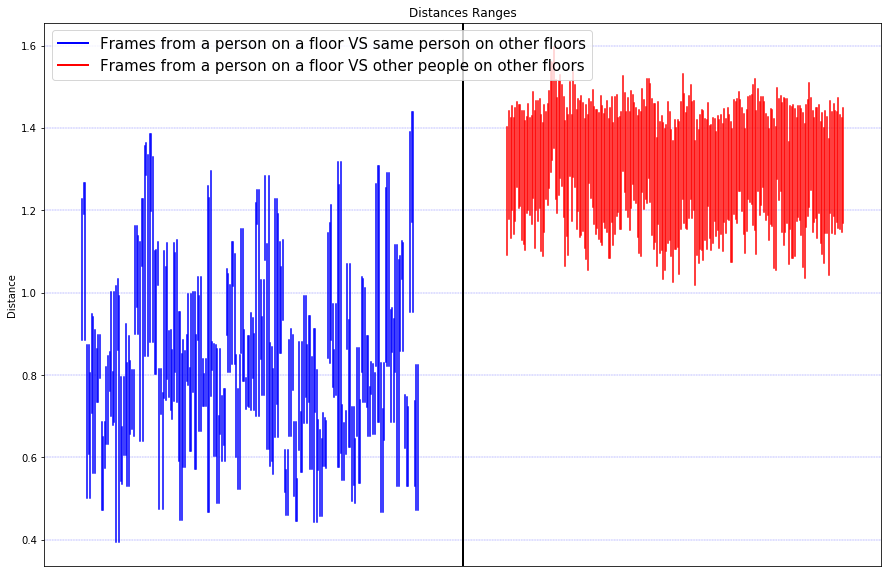

In [10]:
dp = distance_plotter.DistancePlotter(# same_video_results_list,
                                      same_person_results_list,
                                      different_people_results_list)
dp.draw_plot()

##### 2.6.2.3 Visualización de rangos de distancias euclídeas con *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

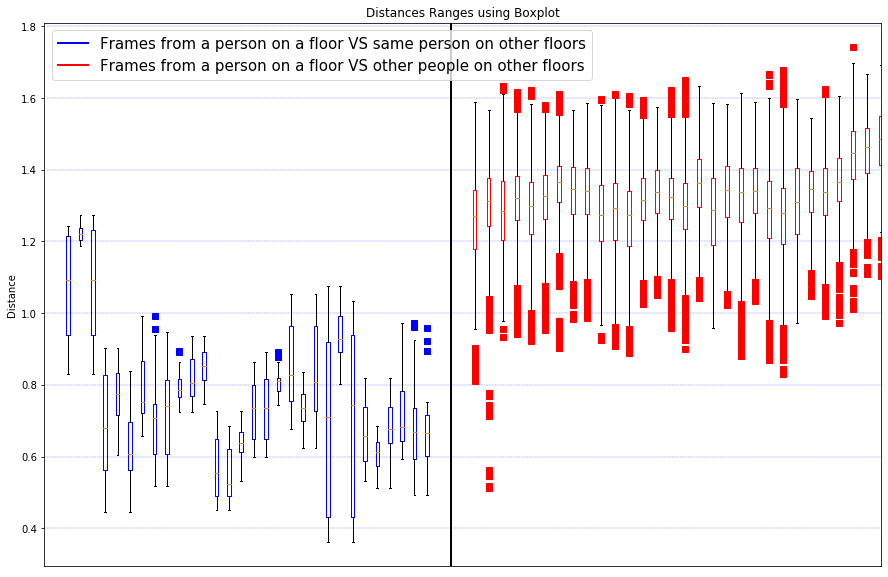

In [11]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# same_video_euclidean_distance_list[:30],
                                                      same_person_euclidean_distance_list[:30],
                                                      different_people_euclidean_distance_list[:30])

dpb.draw_plot()


##### 2.6.2.4 Visualización de rangos de distancias euclídeas concentradas en únicamente dos *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

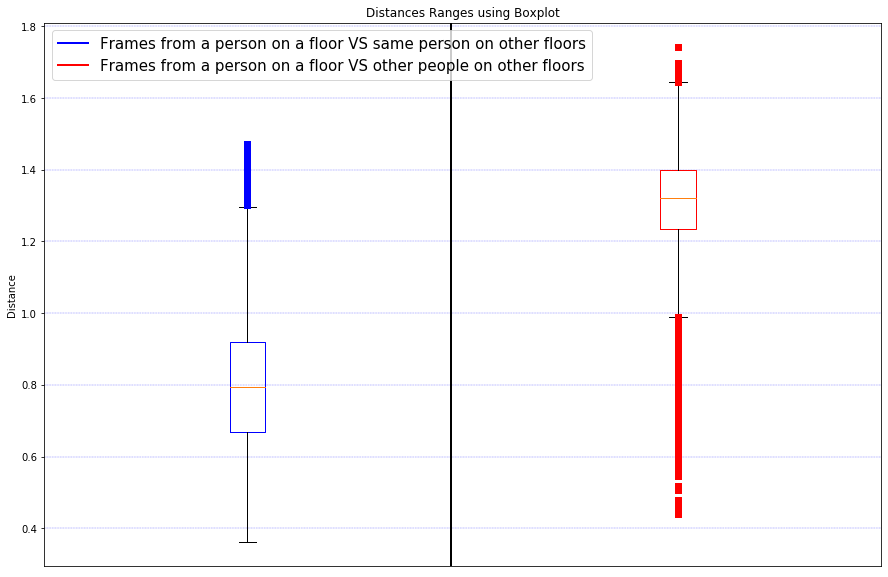

In [12]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# numpy.concatenate(same_video_euclidean_distance_list),
                                                      numpy.concatenate(same_person_euclidean_distance_list),
                                                      numpy.concatenate(different_people_euclidean_distance_list))
dpb.draw_plot()


##### 2.6.2.5 Cálculo del mejor umbral a través de *FAR*, *FRR* y *EER* (Módulo `thresholdvalidator` mediante `utils.threshold_plotter`)


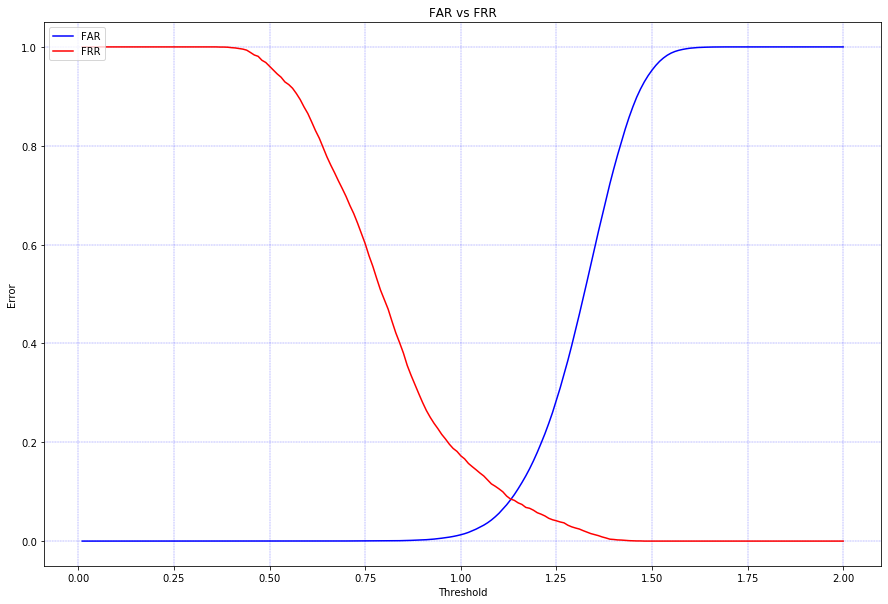


Best threshold: 1.13
EER: 0.083


In [13]:
tp = threshold_plotter.ThresholdPlotter(resize_face_embeddings_train, threshold_min=0.01, threshold_max=2)

tp.draw_plot()

best_threshold, eer = tp.calculate_best_threshold_and_eer() 

print("\nBest threshold:", best_threshold)
print("EER:", eer)

##### Obtención del dataframe y de pares de vídeos de personas iguales y distintas para el *dataset* formado por zonas del ascensor en cámaras 2, 5 y 8 (Módulo `accuracymeter`) (test)

In [63]:
resize_face_embeddings_test = embeddings_assembler.load_panda_embeddings('2020-07-01_16-44-39-601251-facenet_resize_lift_place_2_5_8_test-data-resize.pickle')
same_person_videos_id_pairs_list_test = accuracy_meter.get_same_person_videos_ids_pairs(resize_face_embeddings_test)
different_person_videos_id_pairs_list_test = accuracy_meter.get_different_people_videos_ids_pairs(resize_face_embeddings_test)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list_test.sort()
different_person_videos_id_pairs_list_test.sort()
random.shuffle(same_person_videos_id_pairs_list_test)
random.shuffle(different_person_videos_id_pairs_list_test)
mixed_videos_id_pairs_list_test = same_person_videos_id_pairs_list_test.copy()
mixed_videos_id_pairs_list_test.extend(different_person_videos_id_pairs_list_test)

##### 2.6.2.6 Muestra gráfica del *accuracy* respecto al índice de confianza (Mediante `utils.confidence_plotter`)

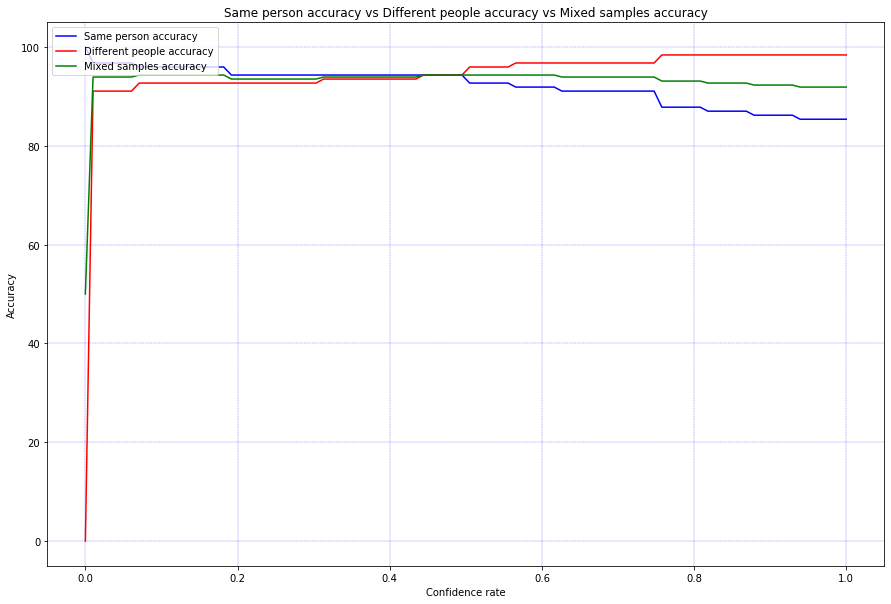


Best confidence rate: 0.444
Same person pairs accuracy:  94.309 %
Different people pairs accuracy:  94.309 %
Accuracy (with same number of same person pairs and different people pairs): 94.309 %


In [3]:
cp = confidence_plotter.ConfidencePlotter(resize_face_embeddings_test, same_person_videos_id_pairs_list_test,
                                          different_person_videos_id_pairs_list_test[:123], threshold=1.13)

cp.draw_plot()

results = cp.calculate_best_confidence_rate_and_accuracy() 

print("\nBest confidence rate:", results[0])
print("Same person pairs accuracy: ", results[1], "%")
print("Different people pairs accuracy: ", results[2], "%")
print("Accuracy (with same number of same person pairs and different people pairs):", results[3], "%")

##### 2.6.2.7 Medida del *accuracy* con el mejor índice de confianza en pares con misma persona, distinta persona y mezclados (Módulo `accuracymeter`)

In [4]:
same_person_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                          same_person_videos_id_pairs_list_test, 
                                                          confidence=0.444,
                                                          threshold=1.13,
                                                          print_iterations=True)

different_person_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                               different_person_videos_id_pairs_list_test, 
                                                               confidence=0.444,
                                                               threshold=1.13,
                                                               print_iterations=True)

mixed_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                    mixed_videos_id_pairs_list_test, 
                                                    confidence=0.444,
                                                    threshold=1.13,
                                                    print_iterations=True)

print()
print("Same person accuracy: " + str(same_person_videos_accuracy) + " %")
print("Different people accuracy: " + str(different_person_videos_accuracy) + " %")
print("Mixed videos accuracy (with different number of same person pairs and different people pairs): " + str(mixed_videos_accuracy) + " %")

[Getting accuracy (sample 5042/5043)]
Same person accuracy: 94.309 %
Different people accuracy: 92.703 %
Mixed videos accuracy (with different number of same person pairs and different people pairs): 92.742 %


##### 2.6.2.8 Varios test de funcionamiento de la verificación (Módulo `verifier`)

In [6]:
vf = verifier.Verifier(resize_face_embeddings_test, confidence=0.444, threshold=1.13)

sp_vipl_copy = same_person_videos_id_pairs_list_test.copy()
dp_vipl_copy = different_person_videos_id_pairs_list_test.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_01-32_01_02_01_02/ VS averobot_floor_03-32_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-87_01_02_04_02/ VS averobot_floor_03-87_03_02_33_08/:	{'is_same_person': True, 'confidence': 0.75}]
[averobot_floor_01-45_01_02_13_02/ VS averobot_floor_03-45_03_02_10_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-91_02_02_11_05/ VS averobot_floor_03-91_03_02_34_08/:	{'is_same_person': True, 'confidence': 0.938}]
[averobot_floor_01-52_01_02_01_02/ VS averobot_floor_03-52_03_02_28_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-92_01_02_01_02/ VS averobot_floor_03-92_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-89_01_02_08_02/ VS averobot_floor_02-89_02_02_27_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-73_01_02_14_02/ VS averobot_floor_03-73_03_02_33_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-92_01_02_01_02

#### 2.6.3 Evaluación de detección con *MTCNN* con normalización básica de doble detección y *embeddings* con 'l2'

##### 2.6.3.1 Carga de distancias euclídeas a través de los descriptores del dataframe construido (Módulo `distancematrixcalculator`)

In [64]:
face_basic_dd_norm_embeddings_train = embeddings_assembler.load_panda_embeddings('2020-07-01_17-27-54-993886-facenet_basic_dd_lift_place_2_5_8_train-data-basic-dd-norm.pickle')
# [same_video_results_list, same_video_euclidean_distance_list] = distances_matrix_loader.get_same_video_distance_matrices(face_basic_dd_norm_embeddings_train)
[same_person_results_list, same_person_euclidean_distance_list] = distances_matrix_loader.get_same_person_distance_matrices(face_basic_dd_norm_embeddings_train)
[different_people_results_list, different_people_euclidean_distance_list] = distances_matrix_loader.get_different_people_distance_matrices(face_basic_dd_norm_embeddings_train)


##### 2.6.3.2 Visualización de rangos de distancias euclídeas (Mediante `utils.distance_plotter`)

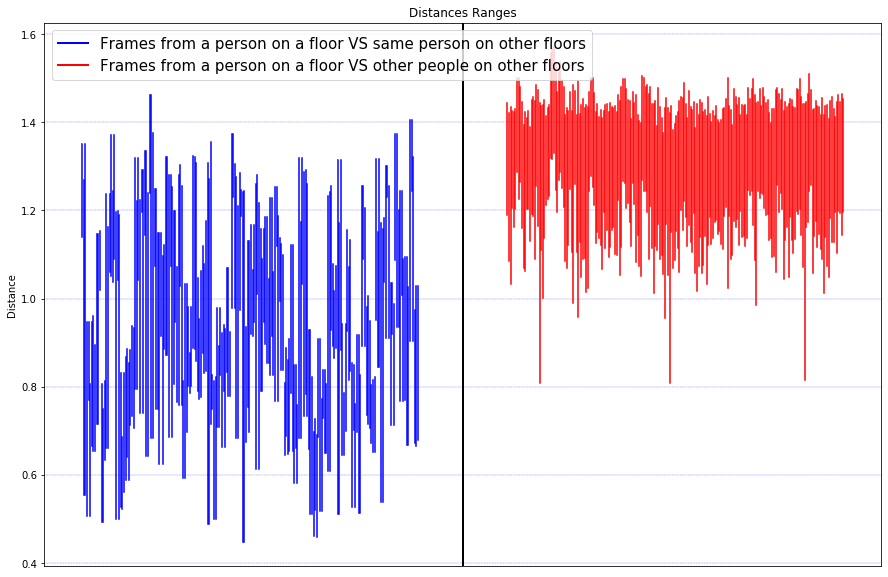

In [15]:
dp = distance_plotter.DistancePlotter(# same_video_results_list,
                                      same_person_results_list,
                                      different_people_results_list)
dp.draw_plot()

##### 2.6.3.3 Visualización de rangos de distancias euclídeas con *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

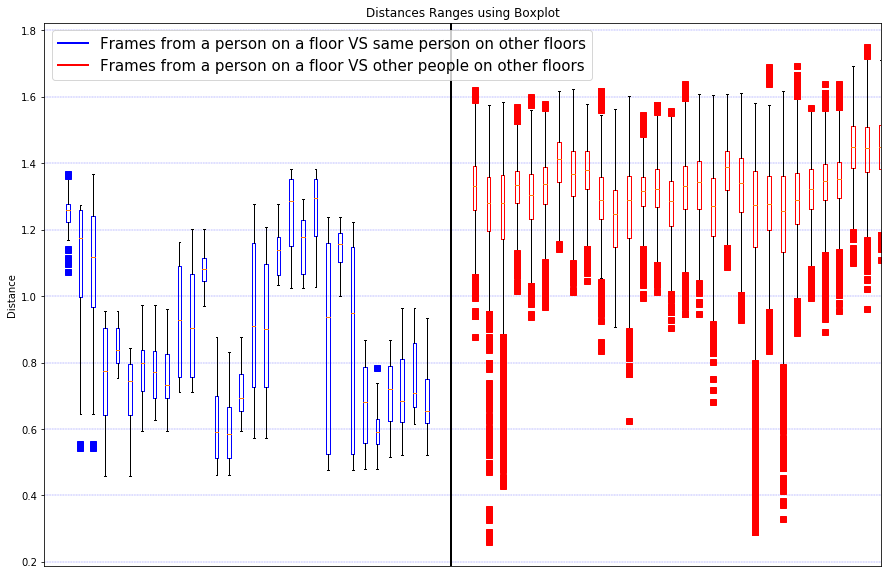

In [16]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# same_video_euclidean_distance_list[:30],
                                                      same_person_euclidean_distance_list[:30],
                                                      different_people_euclidean_distance_list[:30])

dpb.draw_plot()

##### 2.6.3.4 Visualización de rangos de distancias euclídeas concentradas en únicamente dos *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

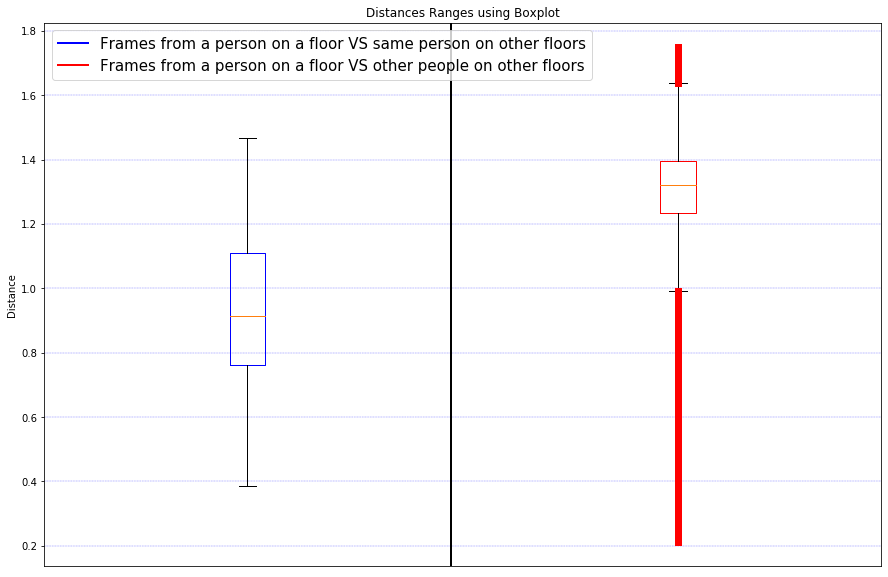

In [17]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# numpy.concatenate(same_video_euclidean_distance_list),
                                                      numpy.concatenate(same_person_euclidean_distance_list),
                                                      numpy.concatenate(different_people_euclidean_distance_list))
dpb.draw_plot()


##### 2.6.3.5 Cálculo del mejor umbral a través de *FAR*, *FRR* y *EER* (Módulo `thresholdvalidator` mediante `utils.threshold_plotter`)

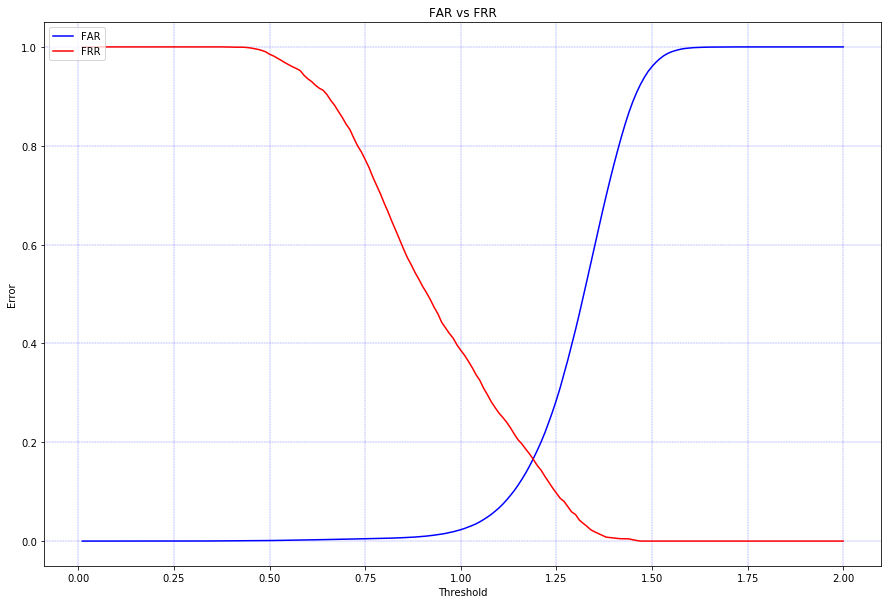


Best threshold: 1.19
EER: 0.167


In [18]:
tp = threshold_plotter.ThresholdPlotter(face_basic_dd_norm_embeddings_train, threshold_min=0.01, threshold_max=2)

tp.draw_plot()

best_threshold, eer = tp.calculate_best_threshold_and_eer() 

print("\nBest threshold:", best_threshold)
print("EER:", eer)

##### Obtención del dataframe y de pares de vídeos de personas iguales y distintas para el *dataset* formado por zonas del ascensor en cámaras 2, 5 y 8 (Módulo `accuracymeter`) (test)

In [68]:
face_basic_dd_norm_embeddings_test = embeddings_assembler.load_panda_embeddings('2020-07-01_17-28-05-762640-facenet_basic_dd_lift_place_2_5_8_test-data-basic-dd-norm.pickle')
same_person_videos_id_pairs_list_test = accuracy_meter.get_same_person_videos_ids_pairs(face_basic_dd_norm_embeddings_test)
different_person_videos_id_pairs_list_test = accuracy_meter.get_different_people_videos_ids_pairs(face_basic_dd_norm_embeddings_test)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list_test.sort()
different_person_videos_id_pairs_list_test.sort()
random.shuffle(same_person_videos_id_pairs_list_test)
random.shuffle(different_person_videos_id_pairs_list_test)
mixed_videos_id_pairs_list_test = same_person_videos_id_pairs_list_test.copy()
mixed_videos_id_pairs_list_test.extend(different_person_videos_id_pairs_list_test)

##### 2.6.3.6 Muestra gráfica del *accuracy* respecto al índice de confianza (Mediante `utils.confidence_plotter`)

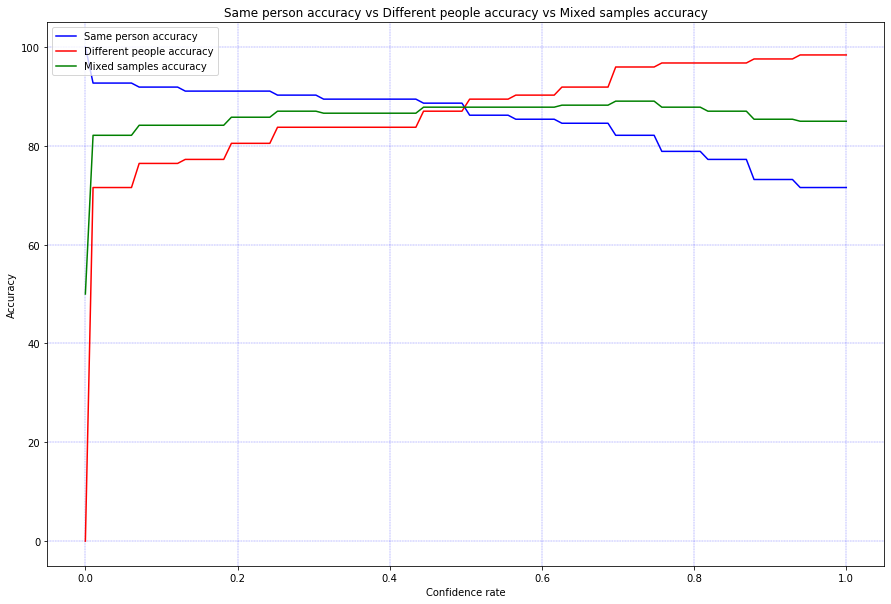


Best confidence rate: 0.444
Same person pairs accuracy:  88.618 %
Different people pairs accuracy:  86.992 %
Accuracy (with same number of same person pairs and different people pairs): 87.805 %


In [3]:
cp = confidence_plotter.ConfidencePlotter(face_basic_dd_norm_embeddings_test, same_person_videos_id_pairs_list_test,
                                          different_person_videos_id_pairs_list_test[:123], threshold=1.19)

cp.draw_plot()

results = cp.calculate_best_confidence_rate_and_accuracy() 

print("\nBest confidence rate:", results[0])
print("Same person pairs accuracy: ", results[1], "%")
print("Different people pairs accuracy: ", results[2], "%")
print("Accuracy (with same number of same person pairs and different people pairs):", results[3], "%")

##### 2.6.3.7 Medida del *accuracy* con el mejor índice de confianza en pares con misma persona, distinta persona y mezclados (Módulo `accuracymeter`)

In [4]:
same_person_videos_accuracy = accuracy_meter.get_accuracy(face_basic_dd_norm_embeddings_test, 
                                                          same_person_videos_id_pairs_list_test, 
                                                          confidence=0.444,
                                                          threshold=1.19,
                                                          print_iterations=True)

different_person_videos_accuracy = accuracy_meter.get_accuracy(face_basic_dd_norm_embeddings_test, 
                                                               different_person_videos_id_pairs_list_test, 
                                                               confidence=0.444,
                                                               threshold=1.19,
                                                               print_iterations=True)

mixed_videos_accuracy = accuracy_meter.get_accuracy(face_basic_dd_norm_embeddings_test, 
                                                    mixed_videos_id_pairs_list_test, 
                                                    confidence=0.444,
                                                    threshold=1.19,
                                                    print_iterations=True)

print()
print("Same person accuracy: " + str(same_person_videos_accuracy) + " %")
print("Different people accuracy: " + str(different_person_videos_accuracy) + " %")
print("Mixed videos accuracy (with different number of same person pairs and different people pairs): " + str(mixed_videos_accuracy) + " %")

[Getting accuracy (sample 5042/5043)]
Same person accuracy: 88.618 %
Different people accuracy: 85.569 %
Mixed videos accuracy (with different number of same person pairs and different people pairs): 85.643 %


##### 2.6.3.8 Varios test de funcionamiento de la verificación (Módulo `verifier`)

In [7]:
vf = verifier.Verifier(face_basic_dd_norm_embeddings_test, confidence=0.444, threshold=1.19)

sp_vipl_copy = same_person_videos_id_pairs_list_test.copy()
dp_vipl_copy = different_person_videos_id_pairs_list_test.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_02-39_02_02_11_05/ VS averobot_floor_03-39_03_02_22_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-73_02_02_25_05/ VS averobot_floor_03-73_03_02_33_08/:	{'is_same_person': True, 'confidence': 0.875}]
[averobot_floor_02-01_02_02_25_05/ VS averobot_floor_03-01_03_02_05_08/:	{'is_same_person': False, 'confidence': 1.0}]
[averobot_floor_02-110_02_02_13_05/ VS averobot_floor_03-110_03_02_03_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-87_01_02_04_02/ VS averobot_floor_03-87_03_02_33_08/:	{'is_same_person': True, 'confidence': 0.75}]
[averobot_floor_01-15_01_02_13_02/ VS averobot_floor_03-15_03_02_27_08/:	{'is_same_person': True, 'confidence': 0.875}]
[averobot_floor_01-09_01_02_26_02/ VS averobot_floor_02-09_02_02_33_05/:	{'is_same_person': False, 'confidence': 1.0}]
[averobot_floor_02-15_02_02_05_05/ VS averobot_floor_03-15_03_02_27_08/:	{'is_same_person': True, 'confidence': 0.875}]
[averobot_floor_02-80_02_

#### 2.6.4 Evaluación de detección con *MTCNN* con normalización básica de *cropping* estático y *embeddings* con 'l2'

##### 2.6.4.1 Carga de distancias euclídeas a través de los descriptores del dataframe construido (Módulo `distancematrixcalculator`)

In [69]:
face_basic_c_norm_embeddings_train = embeddings_assembler.load_panda_embeddings('2020-07-01_17-29-26-349886-facenet_basic_cut_lift_place_2_5_8_train-data-basic-c-norm.pickle')
# [same_video_results_list, same_video_euclidean_distance_list] = distances_matrix_loader.get_same_video_distance_matrices(face_basic_c_norm_embeddings_train)
[same_person_results_list, same_person_euclidean_distance_list] = distances_matrix_loader.get_same_person_distance_matrices(face_basic_c_norm_embeddings_train)
[different_people_results_list, different_people_euclidean_distance_list] = distances_matrix_loader.get_different_people_distance_matrices(face_basic_c_norm_embeddings_train)


##### 2.6.4.2 Visualización de rangos de distancias euclídeas (Mediante `utils.distance_plotter`)

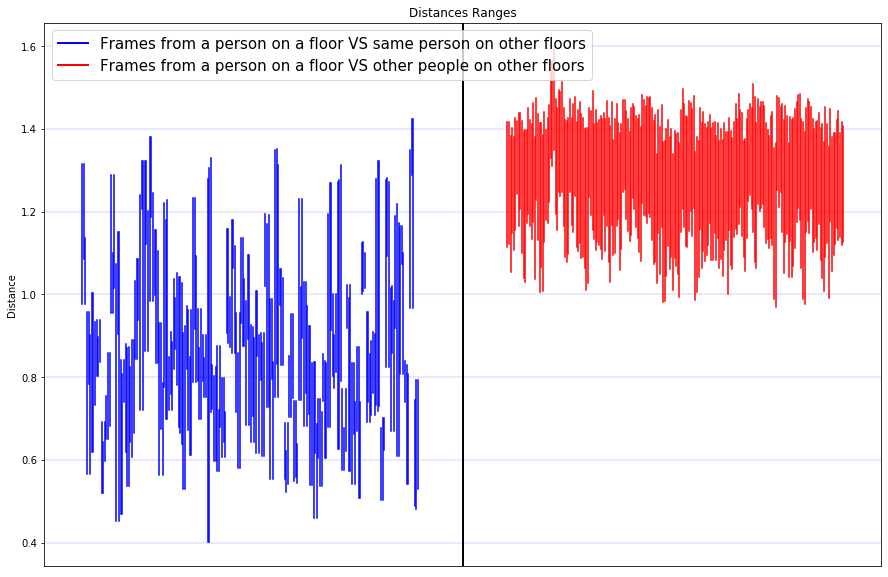

In [3]:
dp = distance_plotter.DistancePlotter(# same_video_results_list,
                                      same_person_results_list,
                                      different_people_results_list)
dp.draw_plot()

##### 2.6.4.3 Visualización de rangos de distancias euclídeas con *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

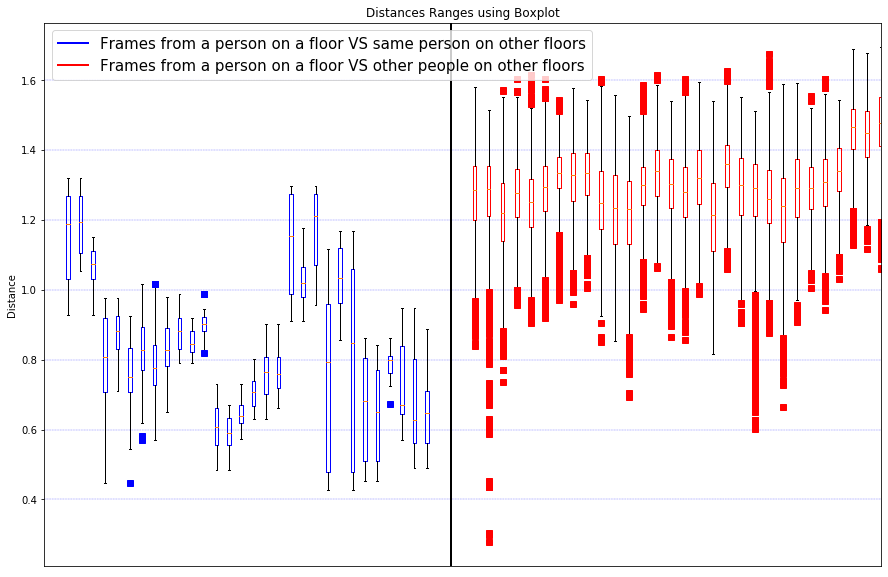

In [4]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# same_video_euclidean_distance_list[:30],
                                                      same_person_euclidean_distance_list[:30],
                                                      different_people_euclidean_distance_list[:30])

dpb.draw_plot()


##### 2.6.4.4 Visualización de rangos de distancias euclídeas concentradas en únicamente dos *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

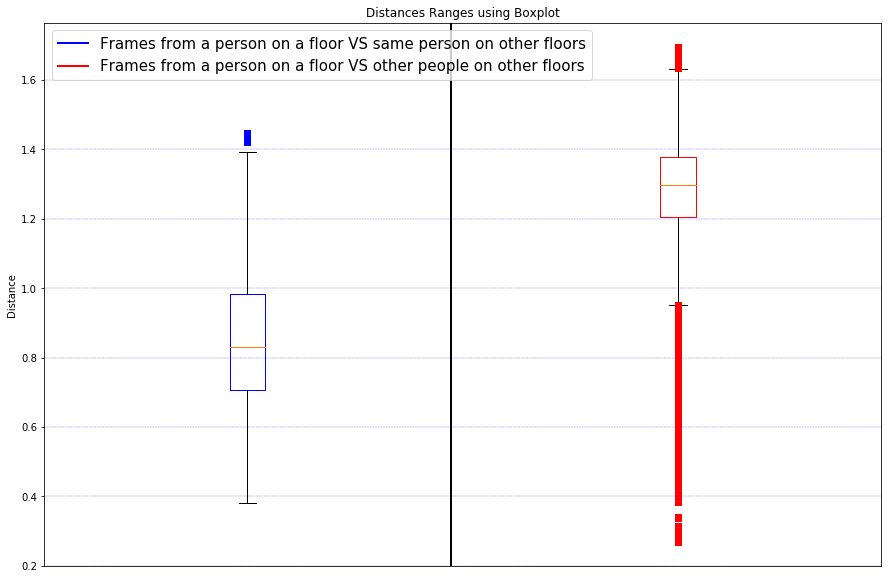

In [5]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# numpy.concatenate(same_video_euclidean_distance_list),
                                                      numpy.concatenate(same_person_euclidean_distance_list),
                                                      numpy.concatenate(different_people_euclidean_distance_list))
dpb.draw_plot()


##### 2.6.4.5 Cálculo del mejor umbral a través de *FAR*, *FRR* y *EER* (Módulo `thresholdvalidator` mediante `utils.threshold_plotter`)

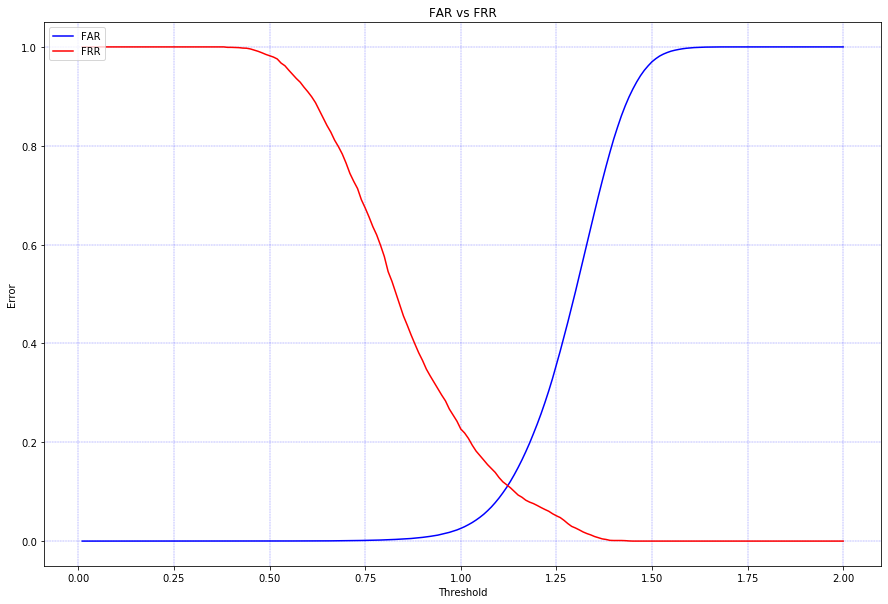


Best threshold: 1.12
EER: 0.109


In [6]:
tp = threshold_plotter.ThresholdPlotter(face_basic_c_norm_embeddings_train, threshold_min=0.01, threshold_max=2)

tp.draw_plot()

best_threshold, eer = tp.calculate_best_threshold_and_eer() 

print("\nBest threshold:", best_threshold)
print("EER:", eer)

##### Obtención del dataframe y de pares de vídeos de personas iguales y distintas para el *dataset* formado por zonas del ascensor en cámaras 2, 5 y 8 (Módulo `accuracymeter`) (test)

In [70]:
face_basic_c_norm_embeddings_test = embeddings_assembler.load_panda_embeddings('2020-07-01_17-29-36-751645-facenet_basic_cut_lift_place_2_5_8_test-data-basic-c-norm.pickle')
same_person_videos_id_pairs_list_test = accuracy_meter.get_same_person_videos_ids_pairs(face_basic_c_norm_embeddings_test)
different_person_videos_id_pairs_list_test = accuracy_meter.get_different_people_videos_ids_pairs(face_basic_c_norm_embeddings_test)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list_test.sort()
different_person_videos_id_pairs_list_test.sort()
random.shuffle(same_person_videos_id_pairs_list_test)
random.shuffle(different_person_videos_id_pairs_list_test)
mixed_videos_id_pairs_list_test = same_person_videos_id_pairs_list_test.copy()
mixed_videos_id_pairs_list_test.extend(different_person_videos_id_pairs_list_test)

##### 2.6.4.6 Muestra gráfica del *accuracy* respecto al índice de confianza (Mediante `utils.confidence_plotter`)

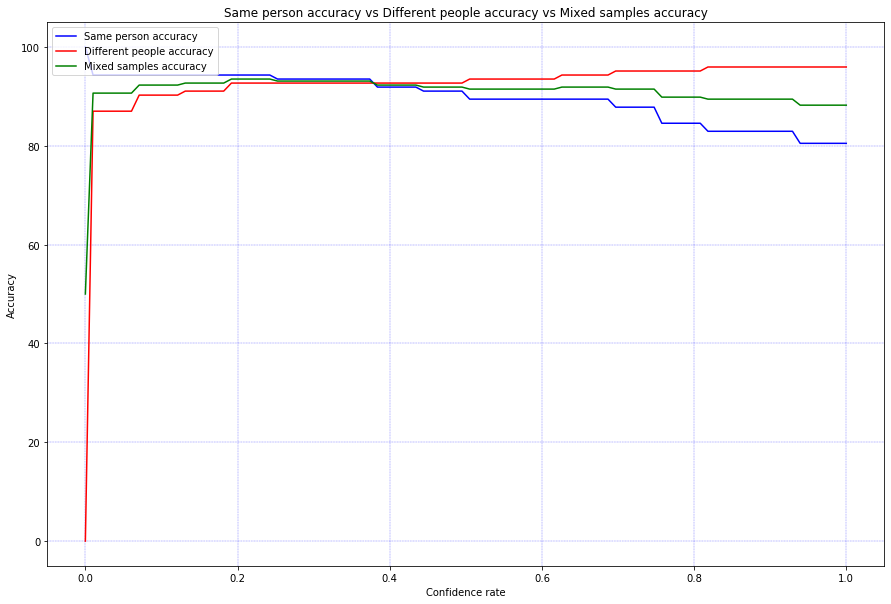


Best confidence rate: 0.253
Same person pairs accuracy:  93.496 %
Different people pairs accuracy:  92.683 %
Accuracy (with same number of same person pairs and different people pairs): 93.089 %


In [3]:
cp = confidence_plotter.ConfidencePlotter(face_basic_c_norm_embeddings_test, same_person_videos_id_pairs_list_test,
                                          different_person_videos_id_pairs_list_test[:123], threshold=1.12)

cp.draw_plot()

results = cp.calculate_best_confidence_rate_and_accuracy() 

print("\nBest confidence rate:", results[0])
print("Same person pairs accuracy: ", results[1], "%")
print("Different people pairs accuracy: ", results[2], "%")
print("Accuracy (with same number of same person pairs and different people pairs):", results[3], "%")

##### 2.6.4.7 Medida del *accuracy* con el mejor índice de confianza en pares con misma persona, distinta persona y mezclados (Módulo `accuracymeter`)

In [4]:
same_person_videos_accuracy = accuracy_meter.get_accuracy(face_basic_c_norm_embeddings_test, 
                                                          same_person_videos_id_pairs_list_test, 
                                                          confidence=0.253,
                                                          threshold=1.12,
                                                          print_iterations=True)

different_person_videos_accuracy = accuracy_meter.get_accuracy(face_basic_c_norm_embeddings_test, 
                                                               different_person_videos_id_pairs_list_test, 
                                                               confidence=0.253,
                                                               threshold=1.12,
                                                               print_iterations=True)

mixed_videos_accuracy = accuracy_meter.get_accuracy(face_basic_c_norm_embeddings_test, 
                                                    mixed_videos_id_pairs_list_test, 
                                                    confidence=0.253,
                                                    threshold=1.12,
                                                    print_iterations=True)

print()
print("Same person accuracy: " + str(same_person_videos_accuracy) + " %")
print("Different people accuracy: " + str(different_person_videos_accuracy) + " %")
print("Mixed videos accuracy (with different number of same person pairs and different people pairs): " + str(mixed_videos_accuracy) + " %")

[Getting accuracy (sample 5042/5043)]
Same person accuracy: 93.496 %
Different people accuracy: 87.947 %
Mixed videos accuracy (with different number of same person pairs and different people pairs): 88.082 %


##### 2.6.4.8 Varios test de funcionamiento de la verificación (Módulo `verifier`)

In [5]:
vf = verifier.Verifier(face_basic_c_norm_embeddings_test, confidence=0.253, threshold=1.12)

sp_vipl_copy = same_person_videos_id_pairs_list_test.copy()
dp_vipl_copy = different_person_videos_id_pairs_list_test.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_02-32_02_02_27_05/ VS averobot_floor_03-32_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-59_01_02_04_02/ VS averobot_floor_03-59_03_02_11_08/:	{'is_same_person': False, 'confidence': 1.0}]
[averobot_floor_02-96_02_02_29_05/ VS averobot_floor_03-96_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-108_01_02_05_02/ VS averobot_floor_03-108_03_02_01_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-92_01_02_01_02/ VS averobot_floor_03-92_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-87_01_02_04_02/ VS averobot_floor_03-87_03_02_33_08/:	{'is_same_person': True, 'confidence': 0.75}]
[averobot_floor_01-90_01_02_01_02/ VS averobot_floor_03-90_03_02_11_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-16_01_02_01_02/ VS averobot_floor_03-16_03_02_32_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-90_01_02_01_0

#### 2.6.5 Evaluación de detección con *MTCNN* con redimensión de la imagen detectada y *embeddings* con 'l2' usando distancias coseno (en lugar de distancias euclídeas)

##### 2.6.5.1 Carga de distancias coseno a través de los descriptores del dataframe construido (Módulo `distancematrixcalculator`)

In [72]:
resize_face_embeddings_train = embeddings_assembler.load_panda_embeddings('2020-07-01_16-44-51-371301-facenet_resize_lift_place_2_5_8_train-data-resize.pickle')
# [same_video_results_list, same_video_cosine_distance_list] = distances_matrix_loader.get_same_video_distance_matrices(resize_face_embeddings_train, distance_type='cosine')
[same_person_results_list, same_person_cosine_distance_list] = distances_matrix_loader.get_same_person_distance_matrices(resize_face_embeddings_train, distance_type='cosine')
[different_people_results_list, different_people_cosine_distance_list] = distances_matrix_loader.get_different_people_distance_matrices(resize_face_embeddings_train, distance_type='cosine')


##### 2.6.5.2 Visualización de rangos de distancias coseno (Mediante `utils.threshold_plotter`)

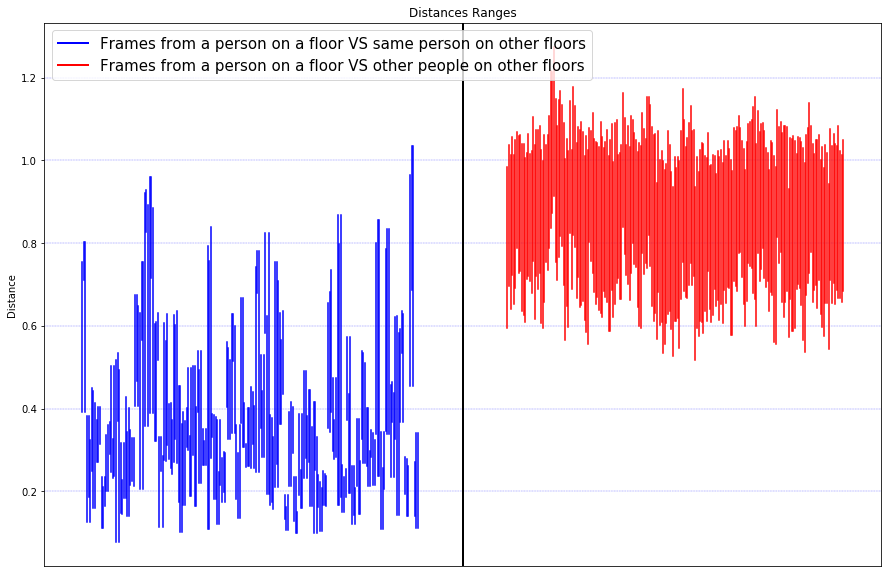

In [3]:
dp = distance_plotter.DistancePlotter(# same_video_results_list,
                                      same_person_results_list,
                                      different_people_results_list)
dp.draw_plot()

##### 2.6.5.3 Visualización de rangos de distancias coseno con *Boxplot* (Mediante `utils.threshold_plotter_boxplot`)

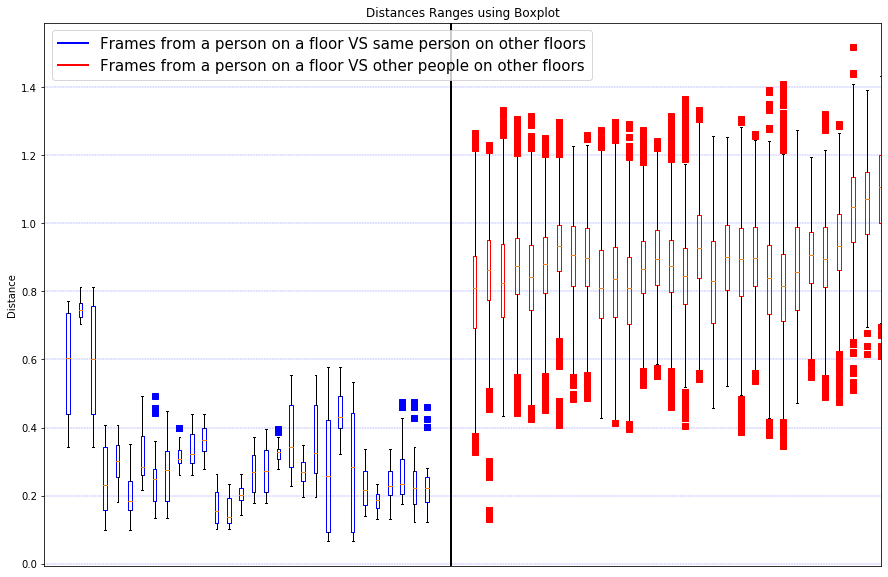

In [4]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# same_video_cosine_distance_list[:30],
                                                      same_person_cosine_distance_list[:30],
                                                      different_people_cosine_distance_list[:30])

dpb.draw_plot()


##### 2.6.5.4 Visualización de rangos de distancias coseno concentradas en únicamente dos *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

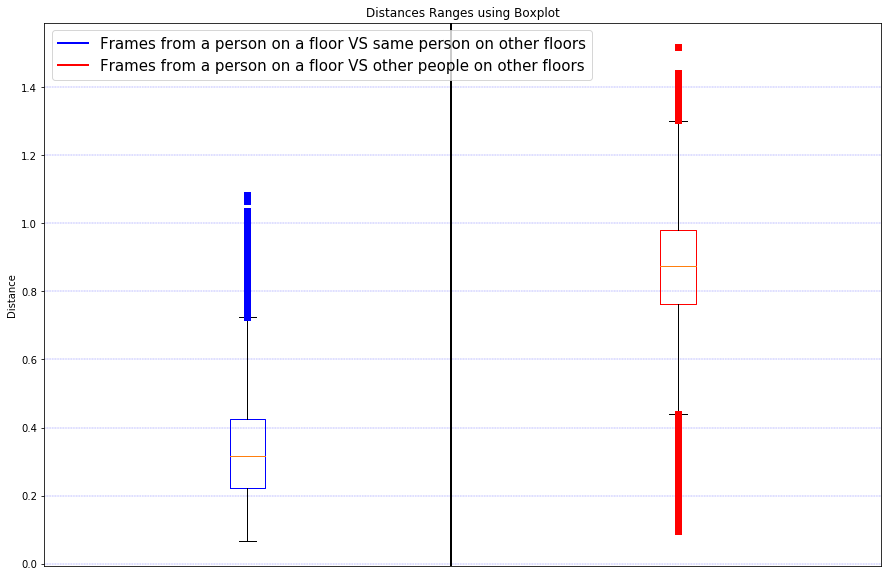

In [5]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# numpy.concatenate(same_video_cosine_distance_list),
                                                      numpy.concatenate(same_person_cosine_distance_list),
                                                      numpy.concatenate(different_people_cosine_distance_list))
dpb.draw_plot()


##### 2.6.5.5 Cálculo del mejor umbral a través de *FAR*, *FRR* y *EER* (Módulo `thresholdvalidator` mediante `utils.threshold_plotter`)

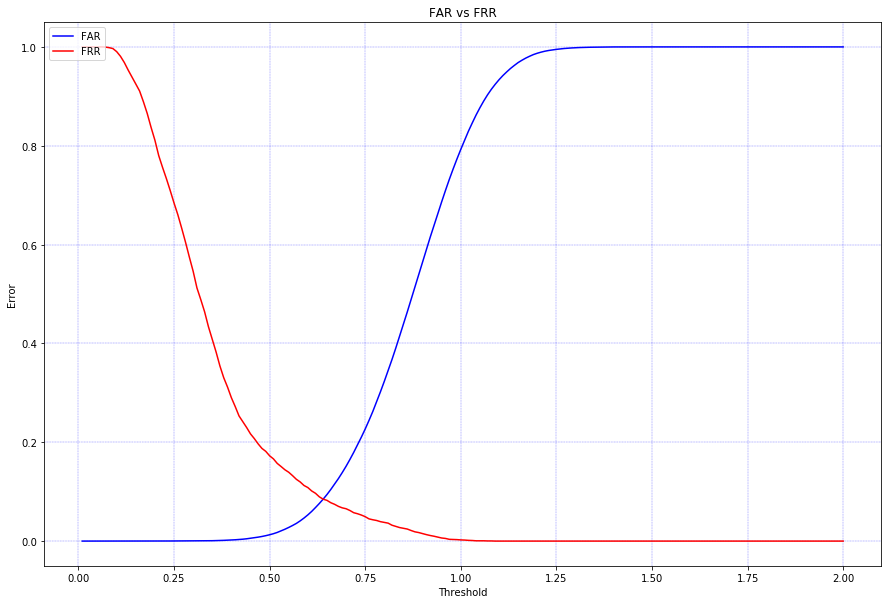


Best threshold: 0.64
EER: 0.085


In [6]:
tp = threshold_plotter.ThresholdPlotter(resize_face_embeddings_train, distance_type='cosine', threshold_min=0.01, threshold_max=2)

tp.draw_plot()

best_threshold, eer = tp.calculate_best_threshold_and_eer() 

print("\nBest threshold:", best_threshold)
print("EER:", eer)

##### Obtención del dataframe y de pares de vídeos de personas iguales y distintas para el *dataset* formado por zonas del ascensor en cámaras 2, 5 y 8 (Módulo `accuracymeter`) (test)

In [73]:
resize_face_embeddings_test = embeddings_assembler.load_panda_embeddings('2020-07-01_16-44-39-601251-facenet_resize_lift_place_2_5_8_test-data-resize.pickle')
same_person_videos_id_pairs_list_test = accuracy_meter.get_same_person_videos_ids_pairs(resize_face_embeddings_test)
different_person_videos_id_pairs_list_test = accuracy_meter.get_different_people_videos_ids_pairs(resize_face_embeddings_test)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list_test.sort()
different_person_videos_id_pairs_list_test.sort()
random.shuffle(same_person_videos_id_pairs_list_test)
random.shuffle(different_person_videos_id_pairs_list_test)
mixed_videos_id_pairs_list_test = same_person_videos_id_pairs_list_test.copy()
mixed_videos_id_pairs_list_test.extend(different_person_videos_id_pairs_list_test)

##### 2.6.5.6 Muestra gráfica del *accuracy* respecto al índice de confianza (Mediante `utils.confidence_plotter`)

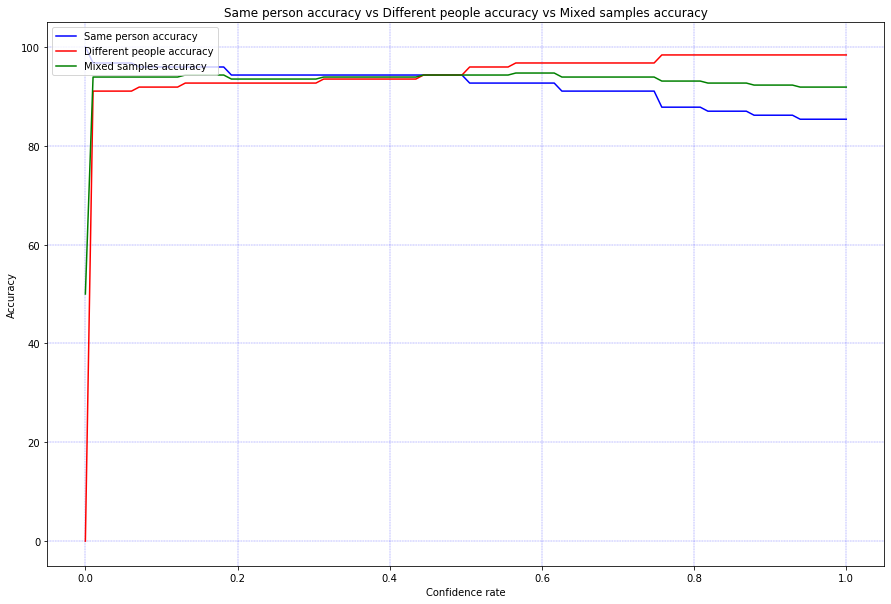


Best confidence rate: 0.444
Same person pairs accuracy:  94.309 %
Different people pairs accuracy:  94.309 %
Accuracy (with same number of same person pairs and different people pairs): 94.309 %


In [3]:
cp = confidence_plotter.ConfidencePlotter(resize_face_embeddings_test, 
                                          same_person_videos_id_pairs_list_test, 
                                          different_person_videos_id_pairs_list_test[:123], 
                                          distance_type='cosine',
                                          threshold=0.64)

cp.draw_plot()

results = cp.calculate_best_confidence_rate_and_accuracy() 

print("\nBest confidence rate:", results[0])
print("Same person pairs accuracy: ", results[1], "%")
print("Different people pairs accuracy: ", results[2], "%")
print("Accuracy (with same number of same person pairs and different people pairs):", results[3], "%")

##### 2.6.5.7 Medida del *accuracy* con el mejor índice de confianza en pares con misma persona, distinta persona y mezclados (Módulo `accuracymeter`)

In [4]:
same_person_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                          same_person_videos_id_pairs_list_test,
                                                          distance_type='cosine',
                                                          confidence=0.444,
                                                          threshold=0.64,
                                                          print_iterations=True)

different_person_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                               different_person_videos_id_pairs_list_test,
                                                               distance_type='cosine',
                                                               confidence=0.444,
                                                               threshold=0.64,
                                                               print_iterations=True)

mixed_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                    mixed_videos_id_pairs_list_test,
                                                    distance_type='cosine',
                                                    confidence=0.444,
                                                    threshold=0.64,
                                                    print_iterations=True)

print()
print("Same person accuracy: " + str(same_person_videos_accuracy) + " %")
print("Different people accuracy: " + str(different_person_videos_accuracy) + " %")
print("Mixed videos accuracy (with different number of same person pairs and different people pairs): " + str(mixed_videos_accuracy) + " %")

[Getting accuracy (sample 5042/5043)]
Same person accuracy: 94.309 %
Different people accuracy: 92.561 %
Mixed videos accuracy (with different number of same person pairs and different people pairs): 92.604 %


##### 2.6.5.8 Varios test de funcionamiento de la verificación (Módulo `verifier`)

In [5]:
vf = verifier.Verifier(resize_face_embeddings_test, distance_type='cosine', confidence=0.444, threshold=0.64)

In [54]:
sp_vipl_copy = same_person_videos_id_pairs_list_test.copy()
dp_vipl_copy = different_person_videos_id_pairs_list_test.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_02-101_02_02_08_05/ VS averobot_floor_03-101_03_02_10_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-01_01_02_01_02/ VS averobot_floor_03-01_03_02_05_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-105_02_02_22_05/ VS averobot_floor_03-105_03_02_29_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-16_01_02_01_02/ VS averobot_floor_03-16_03_02_32_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-83_02_02_32_05/ VS averobot_floor_03-83_03_02_04_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-32_01_02_01_02/ VS averobot_floor_02-32_02_02_27_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-01_01_02_01_02/ VS averobot_floor_02-01_02_02_25_05/:	{'is_same_person': False, 'confidence': 0.812}]
[averobot_floor_01-63_01_02_08_02/ VS averobot_floor_03-63_03_02_30_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-08_02_02_1

##### 2.6.5.9 Visualización de pares de frames fallidos (Falso negativo haciendo uso de `utils.failed_frames_pairs_generator`)

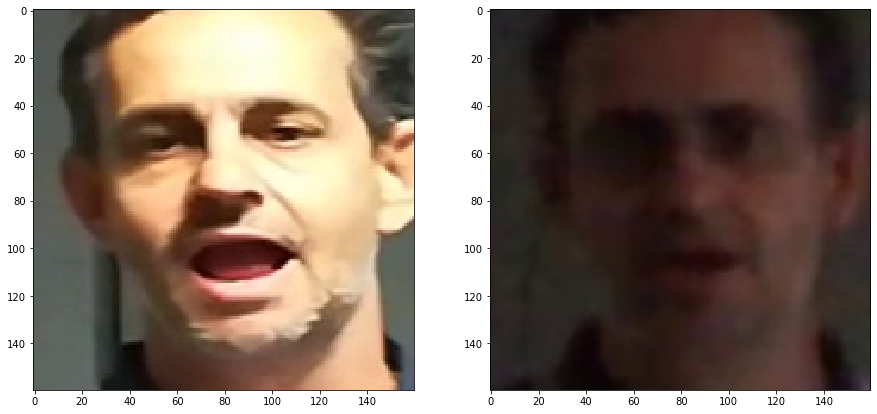

In [55]:
id_video_1 = 'averobot_floor_01-01_01_02_01_02/'
id_video_2 = 'averobot_floor_02-01_02_02_25_05/'

failed_frames_pairs = failed_frames_pairs_generator.get_failed_frames_pairs(id_video_1=id_video_1,
                                                                            id_video_2=id_video_2,
                                                                            same_person=True,
                                                                            distance_matrix=vf.is_same_person(id_video_1, 
                                                                                                              id_video_2)['distance_matrix'],
                                                                            threshold=vf.threshold,
                                                                            used_frames=4,
                                                                            detector='mtcnn')

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[0][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[0][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[0][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[0][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(embedding_frame_1)

plt.subplot(1,2,2)
plt.imshow(embedding_frame_2)

##### 2.6.5.10 Visualización de pares de frames fallidos (Falso positivo haciendo uso de `utils.failed_frames_pairs_generator`)

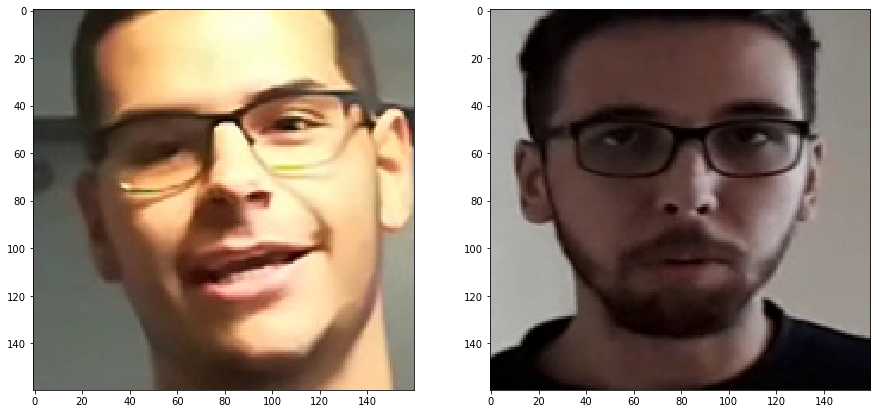

In [56]:
id_video_1 = 'averobot_floor_01-37_01_02_08_02/'
id_video_2 = 'averobot_floor_03-63_03_02_30_08/'

failed_frames_pairs = failed_frames_pairs_generator.get_failed_frames_pairs(id_video_1=id_video_1,
                                                                            id_video_2=id_video_2,
                                                                            same_person=False,
                                                                            distance_matrix=vf.is_same_person(id_video_1, 
                                                                                                              id_video_2)['distance_matrix'],
                                                                            threshold=vf.threshold,
                                                                            used_frames=4,
                                                                            detector='mtcnn')

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[0][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[0][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[0][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[0][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(embedding_frame_1)

plt.subplot(1,2,2)
plt.imshow(embedding_frame_2)

#### 2.6.6 Evaluación de detección con *MTCNN* con redimensión de la imagen detectada y *embeddings* con 'l2' usando el mejor frame escogido manualmente

En este caso, no se hace uso de un conjunto de entrenamiento para hallar el mejor umbral y aplicarlo al conjunto de test. En su lugar, el umbral se halla haciendo uso del mismo conjunto de test.

El objetivo de este prototipo es tan solo observar la mejora que se podría producir si se escogiera el mejor fotograma de cada vídeo manualmente, en lugar de recoger las mejores detecciones de manera automática.

##### 2.6.6.1 Carga de distancias euclídeas a través de los descriptores del dataframe construido (Módulo `distancematrixcalculator`)

In [3]:
resize_face_embeddings_test = embeddings_assembler.load_panda_embeddings('2020-04-06_03-40-50-683899-facenet_resize_1_frame_lift_place_2_5_8_test-data-resize.pickle')
[same_person_results_list, same_person_euclidean_distance_list] = distances_matrix_loader.get_same_person_distance_matrices(resize_face_embeddings_test)
[different_people_results_list, different_people_euclidean_distance_list] = distances_matrix_loader.get_different_people_distance_matrices(resize_face_embeddings_test)


##### 2.6.6.2 Visualización de rangos de distancias euclídeas (Mediante `utils.distance_plotter`)

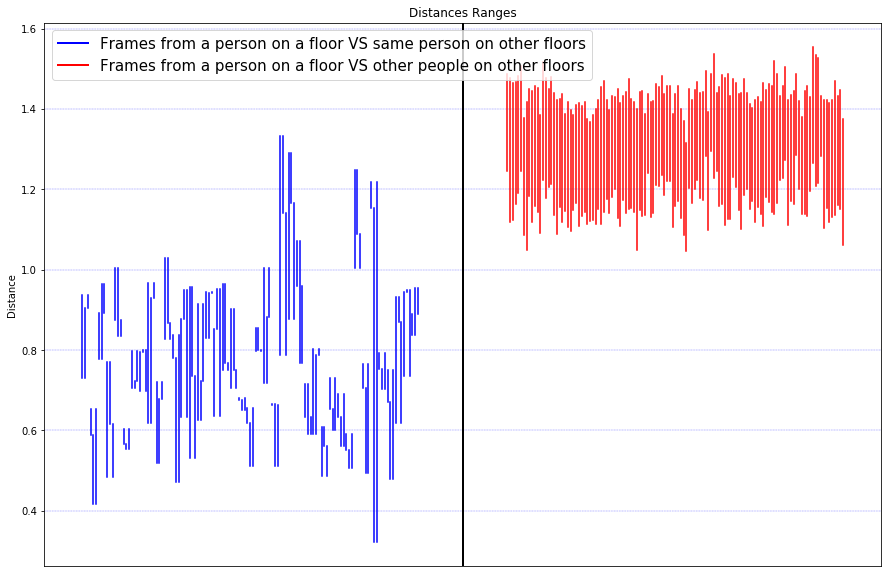

In [4]:
dp = distance_plotter.DistancePlotter(# [],
                                      same_person_results_list,
                                      different_people_results_list)
dp.draw_plot()

##### 2.6.6.3 Visualización de rangos de distancias euclídeas con *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

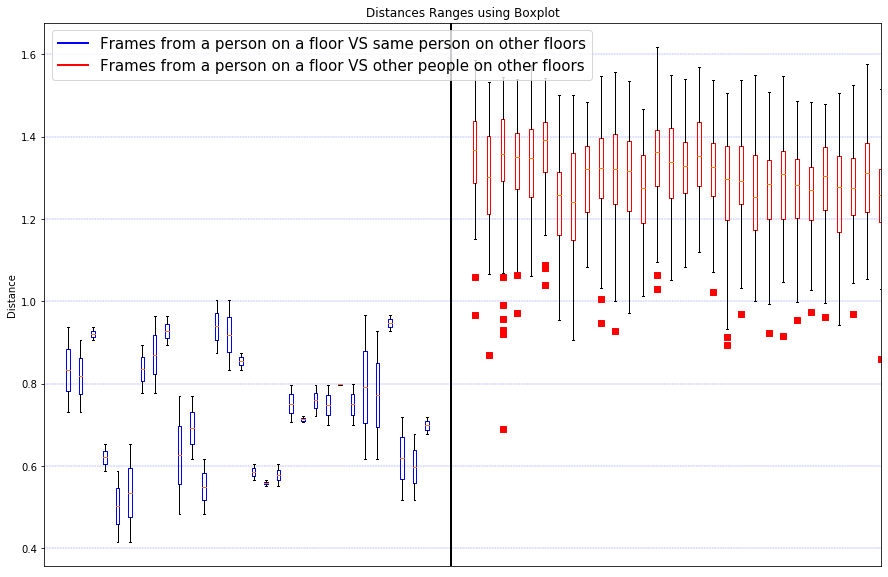

In [5]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# [0],
                                                      same_person_euclidean_distance_list[:30],
                                                      different_people_euclidean_distance_list[:30])

dpb.draw_plot()


##### 2.6.6.4 Visualización de rangos de distancias euclídeas concentradas en únicamente dos *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

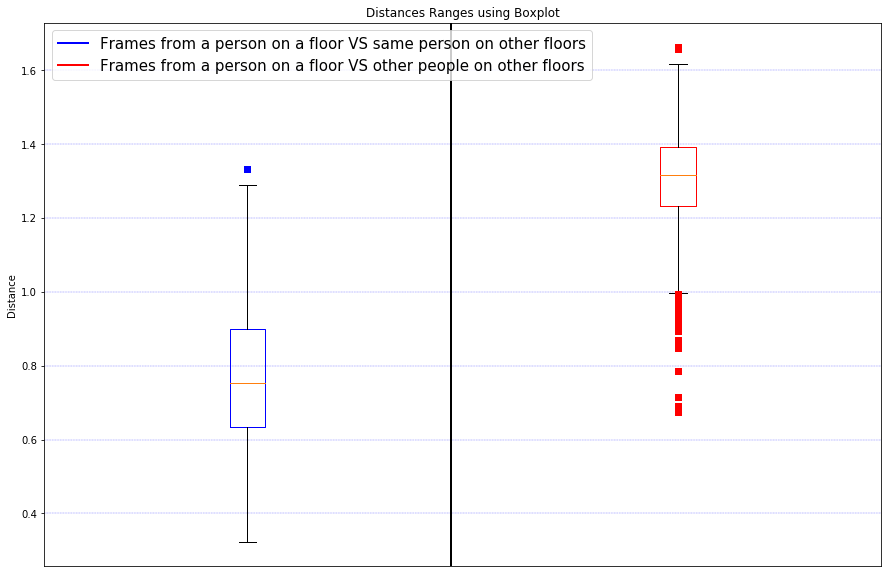

In [6]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# [0],
                                                      numpy.concatenate(same_person_euclidean_distance_list),
                                                      numpy.concatenate(different_people_euclidean_distance_list))
dpb.draw_plot()


##### 2.6.6.5 Cálculo del mejor umbral a través de *FAR*, *FRR* y *EER* (Módulo `thresholdvalidator` mediante `utils.threshold_plotter`)

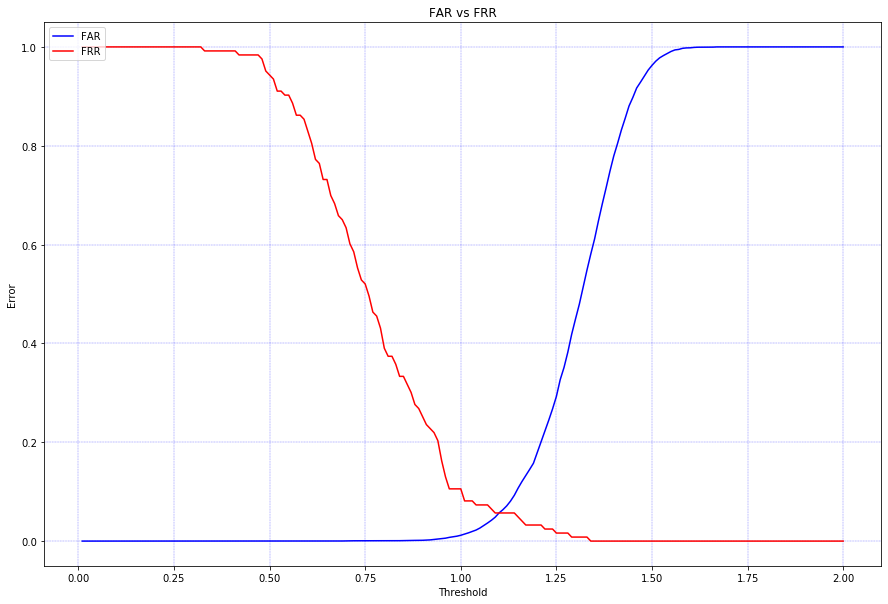


Best threshold: 1.1
EER: 0.057


In [7]:
tp = threshold_plotter.ThresholdPlotter(resize_face_embeddings_test, threshold_min=0.01, threshold_max=2)

tp.draw_plot()

best_threshold, eer = tp.calculate_best_threshold_and_eer() 

print("\nBest threshold:", best_threshold)
print("EER:", eer)

##### Obtención del dataframe y de pares de vídeos de personas iguales y distintas para el *dataset* formado por zonas del ascensor en cámaras 2, 5 y 8 (Módulo `accuracymeter`) (test)

In [2]:
resize_face_embeddings_test = embeddings_assembler.load_panda_embeddings('2020-04-06_03-40-50-683899-facenet_resize_1_frame_lift_place_2_5_8_test-data-resize.pickle')
same_person_videos_id_pairs_list_test = accuracy_meter.get_same_person_videos_ids_pairs(resize_face_embeddings_test)
different_person_videos_id_pairs_list_test = accuracy_meter.get_different_people_videos_ids_pairs(resize_face_embeddings_test)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list_test.sort()
different_person_videos_id_pairs_list_test.sort()
random.shuffle(same_person_videos_id_pairs_list_test)
random.shuffle(different_person_videos_id_pairs_list_test)
mixed_videos_id_pairs_list_test = same_person_videos_id_pairs_list_test.copy()
mixed_videos_id_pairs_list_test.extend(different_person_videos_id_pairs_list_test)

##### 2.6.6.6 Muestra gráfica del *accuracy* respecto al índice de confianza (Mediante `utils.confidence_plotter`)

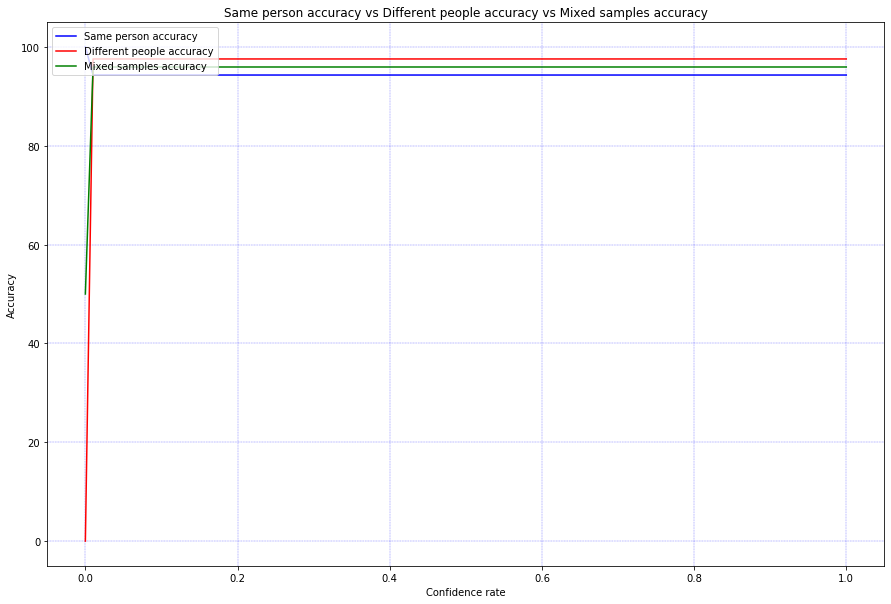


Best confidence rate: 0.01
Same person pairs accuracy:  94.309 %
Different people pairs accuracy:  97.561 %
Accuracy (with same number of same person pairs and different people pairs): 95.935 %


In [4]:
cp = confidence_plotter.ConfidencePlotter(resize_face_embeddings_test, same_person_videos_id_pairs_list_test,
                                          different_person_videos_id_pairs_list_test[:123], threshold=1.1)

cp.draw_plot()

results = cp.calculate_best_confidence_rate_and_accuracy() 

print("\nBest confidence rate:", results[0])
print("Same person pairs accuracy: ", results[1], "%")
print("Different people pairs accuracy: ", results[2], "%")
print("Accuracy (with same number of same person pairs and different people pairs):", results[3], "%")

##### 2.6.6.7 Medida del *accuracy* con el mejor índice de confianza en pares con misma persona, distinta persona y mezclados (Módulo `accuracymeter`)

In [5]:
same_person_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                          same_person_videos_id_pairs_list_test, 
                                                          confidence=0.01,
                                                          threshold=1.1,
                                                          print_iterations=True)

different_person_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                               different_person_videos_id_pairs_list_test, 
                                                               confidence=0.01,
                                                               threshold=1.1,
                                                               print_iterations=True)

mixed_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                    mixed_videos_id_pairs_list_test, 
                                                    confidence=0.01,
                                                    threshold=1.1,
                                                    print_iterations=True)

print()
print("Same person accuracy: " + str(same_person_videos_accuracy) + " %")
print("Different people accuracy: " + str(different_person_videos_accuracy) + " %")
print("Mixed videos accuracy (with different number of same person pairs and different people pairs): " + str(mixed_videos_accuracy) + " %")

[Getting accuracy (sample 5042/5043)]
Same person accuracy: 94.309 %
Different people accuracy: 94.309 %
Mixed videos accuracy (with different number of same person pairs and different people pairs): 94.309 %


##### 2.6.6.8 Varios test de funcionamiento de la verificación (Módulo `verifier`)

In [7]:
vf = verifier.Verifier(resize_face_embeddings_test, confidence=0.01, threshold=1.1)

sp_vipl_copy = same_person_videos_id_pairs_list_test.copy()
dp_vipl_copy = different_person_videos_id_pairs_list_test.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_01-32_01_02_01_02/ VS averobot_floor_03-32_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-87_01_02_04_02/ VS averobot_floor_03-87_03_02_33_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-45_01_02_13_02/ VS averobot_floor_03-45_03_02_10_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-91_02_02_11_05/ VS averobot_floor_03-91_03_02_34_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-52_01_02_01_02/ VS averobot_floor_03-52_03_02_28_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-92_01_02_01_02/ VS averobot_floor_03-92_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-89_01_02_08_02/ VS averobot_floor_02-89_02_02_27_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-73_01_02_14_02/ VS averobot_floor_03-73_03_02_33_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-92_01_02_01_02/ V

#### 2.6.7 Evaluación de detección con *MTCNN* con redimensión de la imagen detectada y *embeddings* con 'l2' usando el mejor frame escogido manualmente y usando distancias coseno

En este caso, no se hace uso de un conjunto de entrenamiento para hallar el mejor umbral y aplicarlo al conjunto de test. En su lugar, el umbral se halla haciendo uso del mismo conjunto de test.

El objetivo de este sistema es tan solo observar la mejora que se podría producir si se escogiera el mejor fotograma de cada vídeo manualmente, en lugar de recoger las mejores detecciones de manera automática.

##### 2.6.7.1 Carga de distancias coseno a través de los descriptores del dataframe construido (Módulo `distancematrixcalculator`)

In [2]:
resize_face_embeddings_test = embeddings_assembler.load_panda_embeddings('2020-04-06_03-40-50-683899-facenet_resize_1_frame_lift_place_2_5_8_test-data-resize.pickle')
[same_person_results_list, same_person_cosine_distance_list] = distances_matrix_loader.get_same_person_distance_matrices(resize_face_embeddings_test, distance_type='cosine')
[different_people_results_list, different_people_cosine_distance_list] = distances_matrix_loader.get_different_people_distance_matrices(resize_face_embeddings_test, distance_type='cosine')

##### 2.6.7.2 Visualización de rangos de distancias coseno (Mediante `utils.threshold_plotter`)

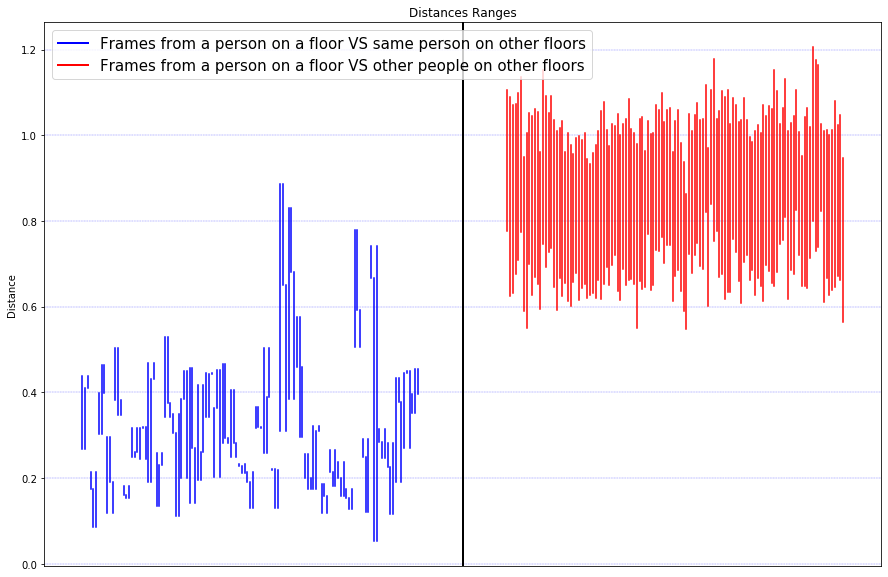

In [3]:
dp = distance_plotter.DistancePlotter(# [],
                                      same_person_results_list,
                                      different_people_results_list)
dp.draw_plot()

##### 2.6.7.3 Visualización de rangos de distancias coseno con *Boxplot* (Mediante `utils.threshold_plotter_boxplot`)

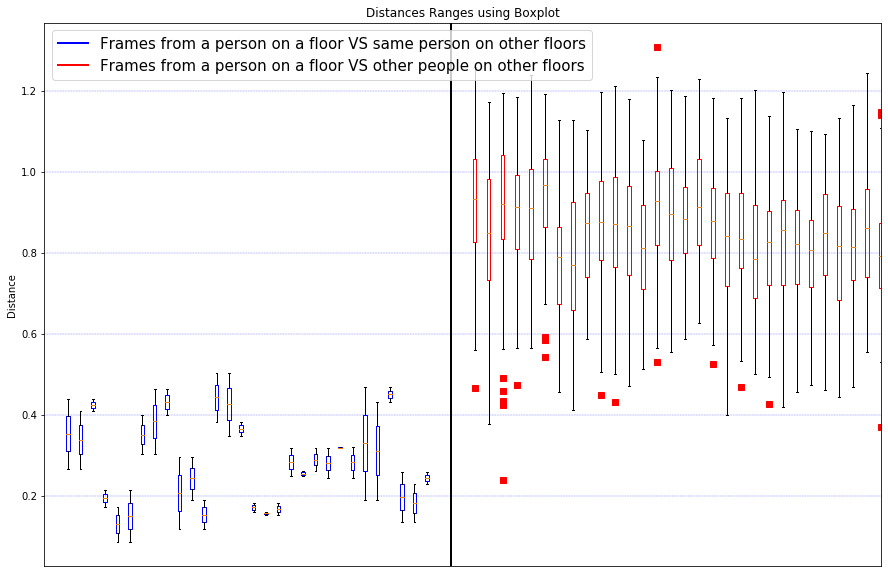

In [4]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# [0],
                                                      same_person_cosine_distance_list[:30],
                                                      different_people_cosine_distance_list[:30])

dpb.draw_plot()


##### 2.6.7.4 Visualización de rangos de distancias coseno concentradas en únicamente dos *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

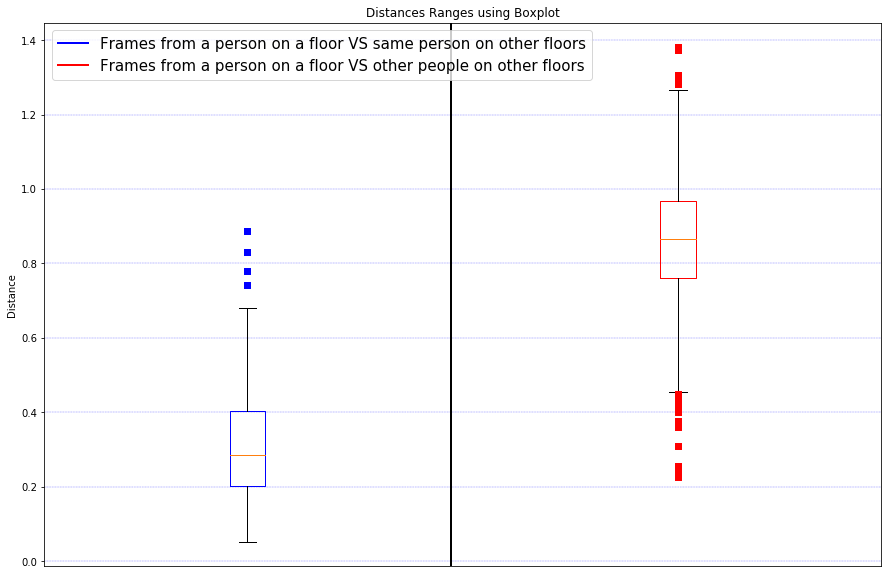

In [5]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# [0],
                                                      numpy.concatenate(same_person_cosine_distance_list),
                                                      numpy.concatenate(different_people_cosine_distance_list))
dpb.draw_plot()


##### 2.6.7.5 Cálculo del mejor umbral a través de *FAR*, *FRR* y *EER* (Módulo `thresholdvalidator` mediante `utils.threshold_plotter`)

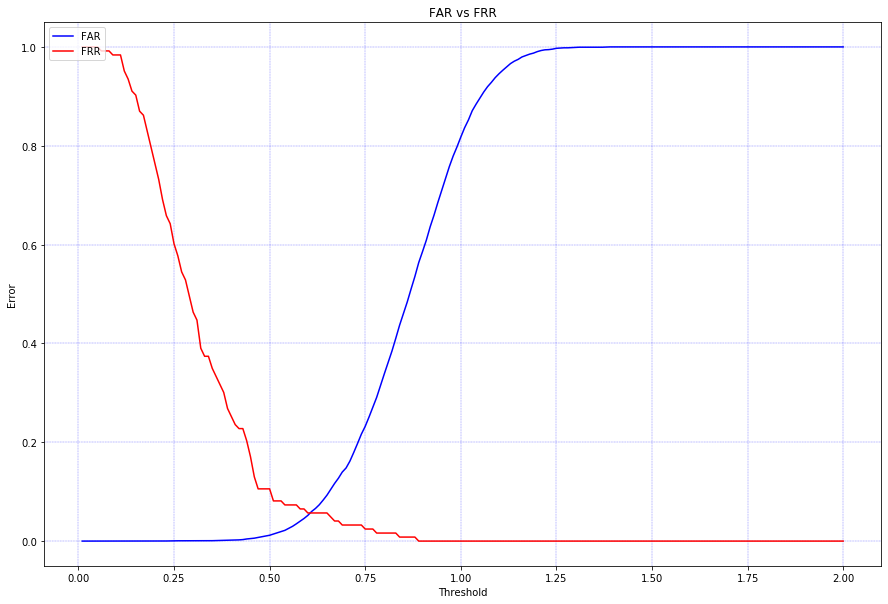


Best threshold: 0.61
EER: 0.06


In [6]:
tp = threshold_plotter.ThresholdPlotter(resize_face_embeddings_test, distance_type='cosine', threshold_min=0.01, threshold_max=2)

tp.draw_plot()

best_threshold, eer = tp.calculate_best_threshold_and_eer() 

print("\nBest threshold:", best_threshold)
print("EER:", eer)

##### Obtención del dataframe y de pares de vídeos de personas iguales y distintas para el *dataset* formado por zonas del ascensor en cámaras 2, 5 y 8 (Módulo `accuracymeter`) (test)

In [2]:
resize_face_embeddings_test = embeddings_assembler.load_panda_embeddings('2020-04-06_03-40-50-683899-facenet_resize_1_frame_lift_place_2_5_8_test-data-resize.pickle')
same_person_videos_id_pairs_list_test = accuracy_meter.get_same_person_videos_ids_pairs(resize_face_embeddings_test)
different_person_videos_id_pairs_list_test = accuracy_meter.get_different_people_videos_ids_pairs(resize_face_embeddings_test)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list_test.sort()
different_person_videos_id_pairs_list_test.sort()
random.shuffle(same_person_videos_id_pairs_list_test)
random.shuffle(different_person_videos_id_pairs_list_test)
mixed_videos_id_pairs_list_test = same_person_videos_id_pairs_list_test.copy()
mixed_videos_id_pairs_list_test.extend(different_person_videos_id_pairs_list_test)

##### 2.6.7.6 Muestra gráfica del *accuracy* respecto al índice de confianza (Mediante `utils.confidence_plotter`)

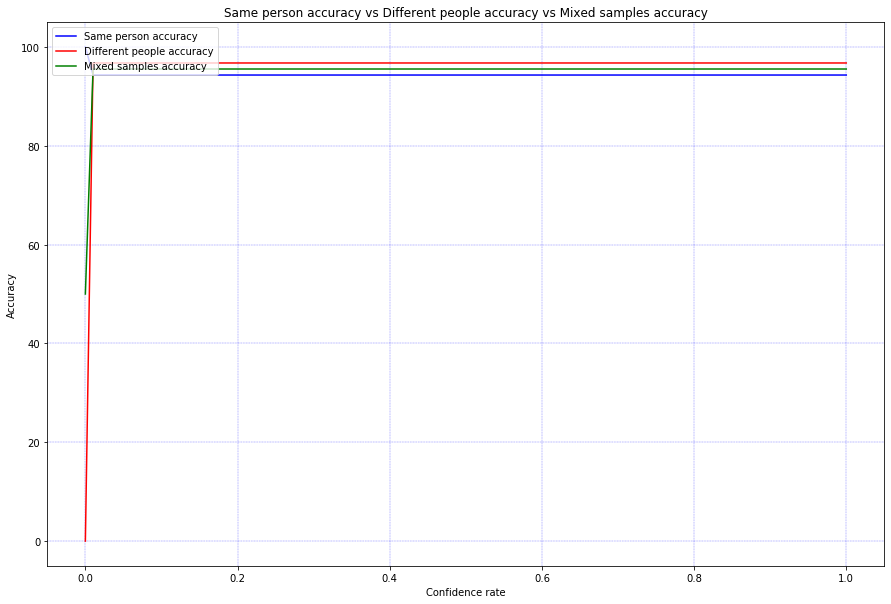


Best confidence rate: 0.01
Same person pairs accuracy:  94.309 %
Different people pairs accuracy:  96.748 %
Accuracy (with same number of same person pairs and different people pairs): 95.528 %


In [3]:
cp = confidence_plotter.ConfidencePlotter(resize_face_embeddings_test, 
                                          same_person_videos_id_pairs_list_test, 
                                          different_person_videos_id_pairs_list_test[:123], 
                                          distance_type='cosine',
                                          threshold=0.61)

cp.draw_plot()

results = cp.calculate_best_confidence_rate_and_accuracy() 

print("\nBest confidence rate:", results[0])
print("Same person pairs accuracy: ", results[1], "%")
print("Different people pairs accuracy: ", results[2], "%")
print("Accuracy (with same number of same person pairs and different people pairs):", results[3], "%")

##### 2.6.7.7 Medida del *accuracy* con el mejor índice de confianza en pares con misma persona, distinta persona y mezclados (Módulo `accuracymeter`)

In [4]:
same_person_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                          same_person_videos_id_pairs_list_test,
                                                          distance_type='cosine',
                                                          confidence=0.01,
                                                          threshold=0.61,
                                                          print_iterations=True)

different_person_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                               different_person_videos_id_pairs_list_test,
                                                               distance_type='cosine',
                                                               confidence=0.01,
                                                               threshold=0.61,
                                                               print_iterations=True)

mixed_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                    mixed_videos_id_pairs_list_test,
                                                    distance_type='cosine',
                                                    confidence=0.01,
                                                    threshold=0.61,
                                                    print_iterations=True)

print()
print("Same person accuracy: " + str(same_person_videos_accuracy) + " %")
print("Different people accuracy: " + str(different_person_videos_accuracy) + " %")
print("Mixed videos accuracy (with different number of same person pairs and different people pairs): " + str(mixed_videos_accuracy) + " %")

[Getting accuracy (sample 5042/5043)]
Same person accuracy: 94.309 %
Different people accuracy: 94.004 %
Mixed videos accuracy (with different number of same person pairs and different people pairs): 94.012 %


##### 2.6.7.8 Varios test de funcionamiento de la verificación (Módulo `verifier`)

In [5]:
vf = verifier.Verifier(resize_face_embeddings_test, distance_type='cosine', confidence=0.01, threshold=0.61)

In [115]:
sp_vipl_copy = same_person_videos_id_pairs_list_test.copy()
dp_vipl_copy = different_person_videos_id_pairs_list_test.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_01-90_01_02_01_02/ VS averobot_floor_03-90_03_02_11_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-98_01_02_01_02/ VS averobot_floor_02-98_02_02_34_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-90_02_02_04_05/ VS averobot_floor_03-90_03_02_11_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-80_01_02_08_02/ VS averobot_floor_03-80_03_02_30_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-15_01_02_13_02/ VS averobot_floor_02-15_02_02_05_05/:	{'is_same_person': False, 'confidence': 1.0}]
[averobot_floor_01-39_01_02_01_02/ VS averobot_floor_03-39_03_02_22_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-26_01_02_28_02/ VS averobot_floor_02-26_02_02_32_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-37_01_02_08_02/ VS averobot_floor_02-37_02_02_15_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-105_02_02_22_05/

##### 2.6.7.9 Visualización de pares de frames fallidos (Falso negativo haciendo uso de `utils.failed_frames_pairs_generator`)

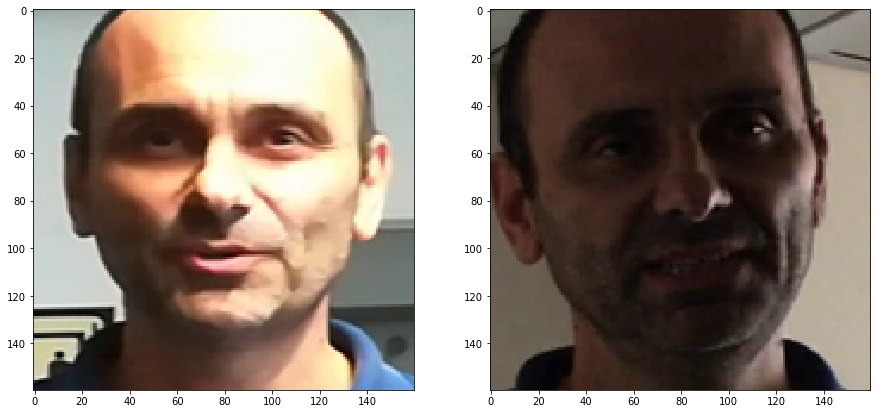

In [116]:
id_video_1 = 'averobot_floor_01-15_01_02_13_02/'
id_video_2 = 'averobot_floor_02-15_02_02_05_05/'
failed_frames_pairs = failed_frames_pairs_generator.get_failed_frames_pairs(id_video_1=id_video_1,
                                                                            id_video_2=id_video_2,
                                                                            same_person=True,
                                                                            distance_matrix=vf.is_same_person(id_video_1, 
                                                                                                              id_video_2)['distance_matrix'],
                                                                            threshold=vf.threshold,
                                                                            used_frames=1,
                                                                            detector='mtcnn')

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[0][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[0][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[0][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[0][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(embedding_frame_1)

plt.subplot(1,2,2)
plt.imshow(embedding_frame_2)

##### 2.6.7.10 Visualización de pares de frames fallidos (Falso positivo haciendo uso de `utils.failed_frames_pairs_generator`)

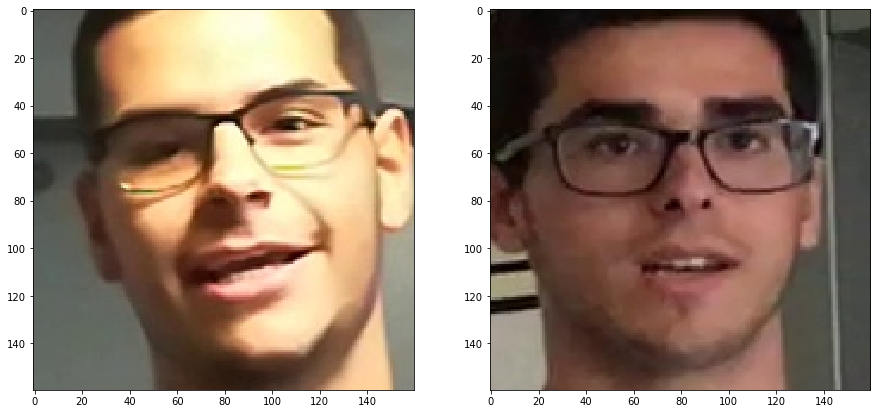

In [117]:
id_video_1 = 'averobot_floor_01-37_01_02_08_02/'
id_video_2 = 'averobot_floor_02-38_02_02_32_05/'
failed_frames_pairs = failed_frames_pairs_generator.get_failed_frames_pairs(id_video_1=id_video_1,
                                                                            id_video_2=id_video_2,
                                                                            same_person=False,
                                                                            distance_matrix=vf.is_same_person(id_video_1, 
                                                                                                              id_video_2)['distance_matrix'],
                                                                            threshold=vf.threshold,
                                                                            used_frames=1,
                                                                            detector='mtcnn')

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[0][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[0][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[0][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[0][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(embedding_frame_1)

plt.subplot(1,2,2)
plt.imshow(embedding_frame_2)

#### 2.6.8 Evaluación de detección con *DLIB (MMOD)* con redimensión de la imagen detectada y *embeddings* con 'l2'

A partir de este prototipo, se vuelven a escoger los mejores fotogramas de manera automática, con lo que se recogen hasta un máximo de 4 detecciones por vídeo.

##### 2.6.8.1 Carga de distancias euclídeas a través de los descriptores del dataframe construido (Módulo `distancematrixcalculator`)

In [2]:
resize_face_embeddings_train = embeddings_assembler.load_panda_embeddings('2020-07-02_00-33-20-768550-facenet_resize_mmod_lift_place_2_5_8_train-dlib-mmod-data.pickle')
# [same_video_results_list, same_video_euclidean_distance_list] = distances_matrix_loader.get_same_video_distance_matrices(resize_face_embeddings_train)
[same_person_results_list, same_person_euclidean_distance_list] = distances_matrix_loader.get_same_person_distance_matrices(resize_face_embeddings_train)
[different_people_results_list, different_people_euclidean_distance_list] = distances_matrix_loader.get_different_people_distance_matrices(resize_face_embeddings_train)


##### 2.6.8.2 Visualización de rangos de distancias euclídeas (Mediante `utils.distance_plotter`)

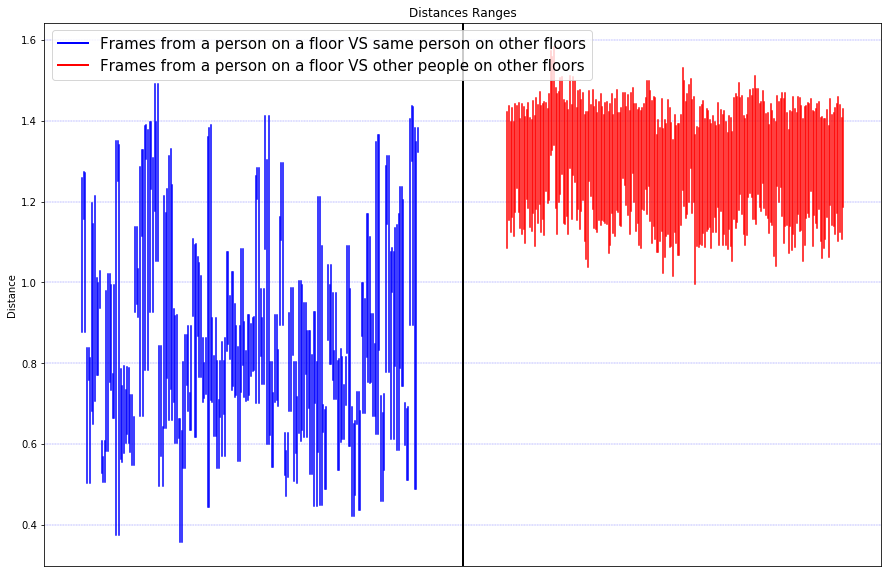

In [3]:
dp = distance_plotter.DistancePlotter(# same_video_results_list,
                                      same_person_results_list,
                                      different_people_results_list)
dp.draw_plot()

##### 2.6.8.3 Visualización de rangos de distancias euclídeas con *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

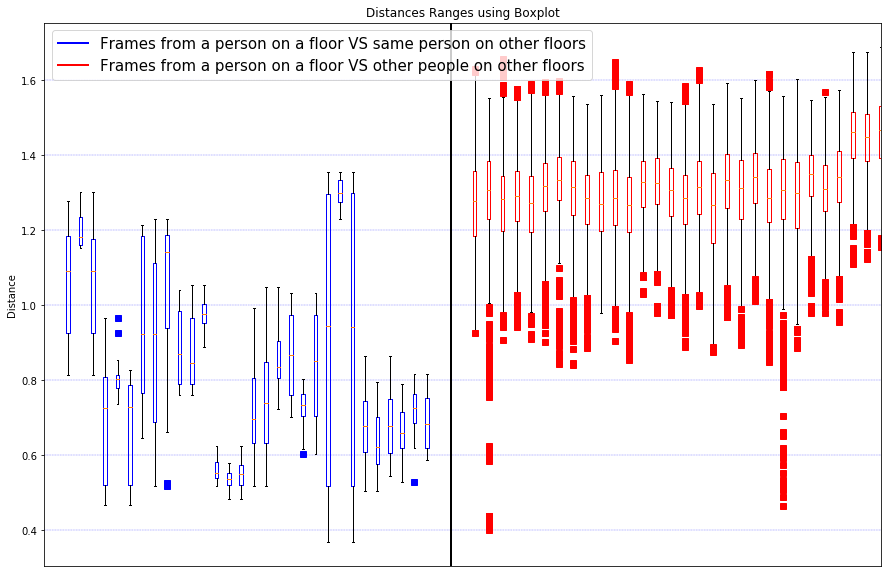

In [4]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# same_video_euclidean_distance_list[:30],
                                                      same_person_euclidean_distance_list[:30],
                                                      different_people_euclidean_distance_list[:30])

dpb.draw_plot()


##### 2.6.8.4 Visualización de rangos de distancias euclídeas concentradas en únicamente dos *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

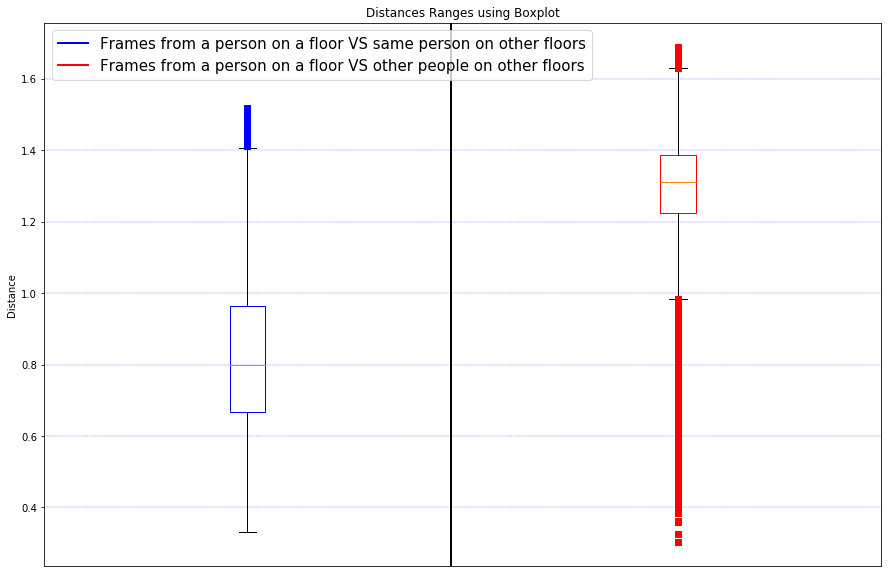

In [5]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# numpy.concatenate(same_video_euclidean_distance_list),
                                                      numpy.concatenate(same_person_euclidean_distance_list),
                                                      numpy.concatenate(different_people_euclidean_distance_list))
dpb.draw_plot()


##### 2.6.8.5 Cálculo del mejor umbral a través de *FAR*, *FRR* y *EER* (Módulo `thresholdvalidator` mediante `utils.threshold_plotter`)

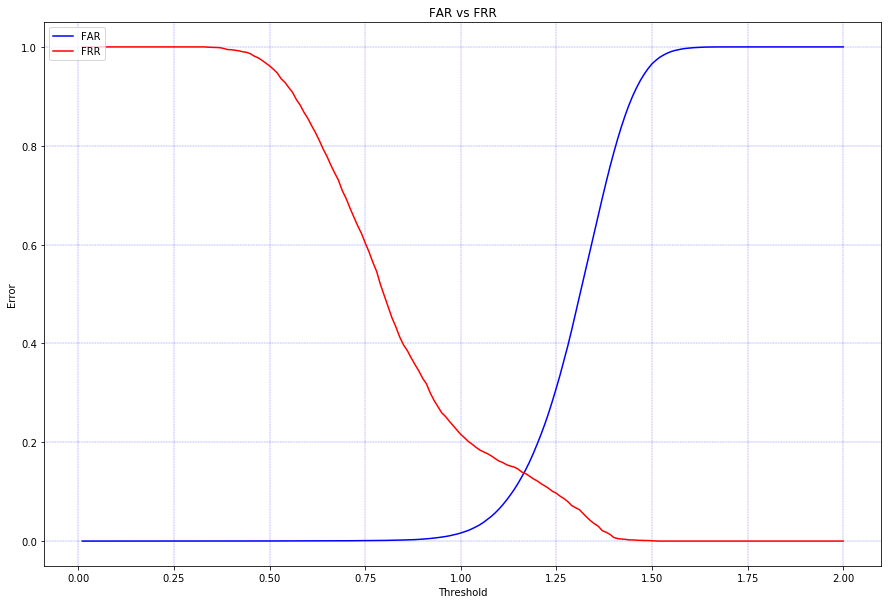


Best threshold: 1.17
EER: 0.145


In [6]:
tp = threshold_plotter.ThresholdPlotter(resize_face_embeddings_train, threshold_min=0.01, threshold_max=2)

tp.draw_plot()

best_threshold, eer = tp.calculate_best_threshold_and_eer() 

print("\nBest threshold:", best_threshold)
print("EER:", eer)

##### Obtención del dataframe y de pares de vídeos de personas iguales y distintas para el *dataset* formado por zonas del ascensor en cámaras 2, 5 y 8 (Módulo `accuracymeter`) (test)

In [2]:
resize_face_embeddings_test = embeddings_assembler.load_panda_embeddings('2020-07-02_00-32-52-263645-facenet_resize_mmod_lift_place_2_5_8_test-dlib-mmod-data.pickle')
same_person_videos_id_pairs_list_test = accuracy_meter.get_same_person_videos_ids_pairs(resize_face_embeddings_test)
different_person_videos_id_pairs_list_test = accuracy_meter.get_different_people_videos_ids_pairs(resize_face_embeddings_test)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list_test.sort()
different_person_videos_id_pairs_list_test.sort()
random.shuffle(same_person_videos_id_pairs_list_test)
random.shuffle(different_person_videos_id_pairs_list_test)
mixed_videos_id_pairs_list_test = same_person_videos_id_pairs_list_test.copy()
mixed_videos_id_pairs_list_test.extend(different_person_videos_id_pairs_list_test)

##### 2.6.8.6 Muestra gráfica del *accuracy* respecto al índice de confianza (Mediante `utils.confidence_plotter`)

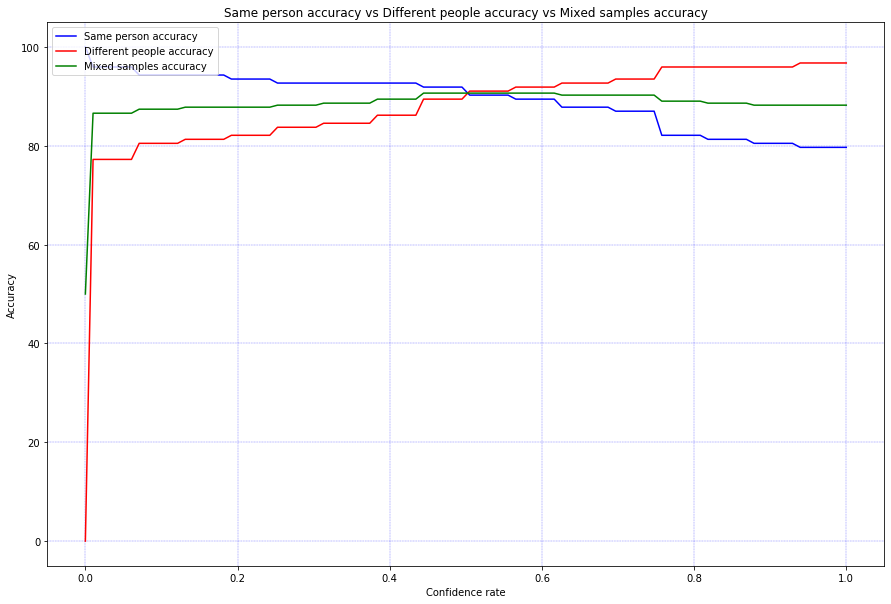


Best confidence rate: 0.505
Same person pairs accuracy:  90.244 %
Different people pairs accuracy:  91.057 %
Accuracy (with same number of same person pairs and different people pairs): 90.65 %


In [3]:
cp = confidence_plotter.ConfidencePlotter(resize_face_embeddings_test, same_person_videos_id_pairs_list_test,
                                          different_person_videos_id_pairs_list_test[:123], threshold=1.17)

cp.draw_plot()

results = cp.calculate_best_confidence_rate_and_accuracy() 

print("\nBest confidence rate:", results[0])
print("Same person pairs accuracy: ", results[1], "%")
print("Different people pairs accuracy: ", results[2], "%")
print("Accuracy (with same number of same person pairs and different people pairs):", results[3], "%")

##### 2.6.8.7 Medida del *accuracy* con el mejor índice de confianza en pares con misma persona, distinta persona y mezclados (Módulo `accuracymeter`)

In [4]:
same_person_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                          same_person_videos_id_pairs_list_test, 
                                                          confidence=0.505,
                                                          threshold=1.17,
                                                          print_iterations=True)

different_person_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                               different_person_videos_id_pairs_list_test, 
                                                               confidence=0.505,
                                                               threshold=1.17,
                                                               print_iterations=True)

mixed_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                    mixed_videos_id_pairs_list_test, 
                                                    confidence=0.505,
                                                    threshold=1.17,
                                                    print_iterations=True)

print()
print("Same person accuracy: " + str(same_person_videos_accuracy) + " %")
print("Different people accuracy: " + str(different_person_videos_accuracy) + " %")
print("Mixed videos accuracy (with different number of same person pairs and different people pairs): " + str(mixed_videos_accuracy) + " %")

[Getting accuracy (sample 5042/5043)]
Same person accuracy: 90.244 %
Different people accuracy: 88.13 %
Mixed videos accuracy (with different number of same person pairs and different people pairs): 88.182 %


##### 2.6.8.8 Varios test de funcionamiento de la verificación (Módulo `verifier`)

In [18]:
vf = verifier.Verifier(resize_face_embeddings_test, confidence=0.505, threshold=1.17)

sp_vipl_copy = same_person_videos_id_pairs_list_test.copy()
dp_vipl_copy = different_person_videos_id_pairs_list_test.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_01-35_01_02_14_02/ VS averobot_floor_02-35_02_02_22_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-26_01_02_28_02/ VS averobot_floor_02-26_02_02_32_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-38_01_02_01_02/ VS averobot_floor_02-38_02_02_32_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-79_01_02_01_02/ VS averobot_floor_03-79_03_02_27_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-63_01_02_08_02/ VS averobot_floor_03-63_03_02_30_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-11_01_02_01_02/ VS averobot_floor_03-11_03_02_10_08/:	{'is_same_person': False, 'confidence': 0.75}]
[averobot_floor_02-52_02_02_30_05/ VS averobot_floor_03-52_03_02_28_08/:	{'is_same_person': True, 'confidence': 0.812}]
[averobot_floor_01-91_01_02_27_02/ VS averobot_floor_02-91_02_02_11_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-39_01_02_01_0

#### 2.6.9 Evaluación de detección con *DLIB (HOG)* con redimensión de la imagen detectada y *embeddings* con 'l2'

##### 2.6.9.1 Carga de distancias euclídeas a través de los descriptores del dataframe construido (Módulo `distancematrixcalculator`)

In [2]:
resize_face_embeddings_train = embeddings_assembler.load_panda_embeddings('2020-07-02_00-51-21-930856-facenet_resize_hog_lift_place_2_5_8_train-dlib-hog-data.pickle')
# [same_video_results_list, same_video_euclidean_distance_list] = distances_matrix_loader.get_same_video_distance_matrices(resize_face_embeddings_train)
[same_person_results_list, same_person_euclidean_distance_list] = distances_matrix_loader.get_same_person_distance_matrices(resize_face_embeddings_train)
[different_people_results_list, different_people_euclidean_distance_list] = distances_matrix_loader.get_different_people_distance_matrices(resize_face_embeddings_train)


##### 2.6.9.2 Visualización de rangos de distancias euclídeas (Mediante `utils.distance_plotter`)

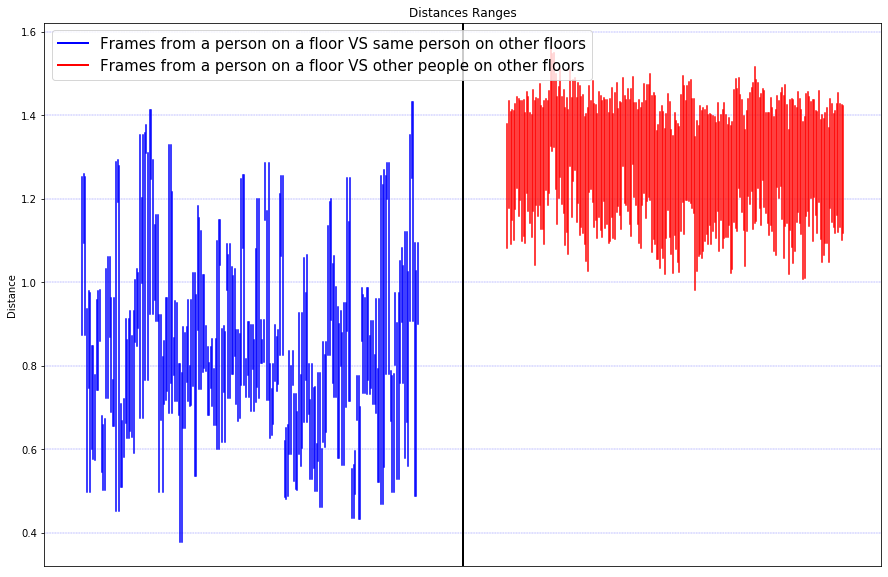

In [3]:
dp = distance_plotter.DistancePlotter(# same_video_results_list,
                                      same_person_results_list,
                                      different_people_results_list)
dp.draw_plot()

##### 2.6.9.3 Visualización de rangos de distancias euclídeas con *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

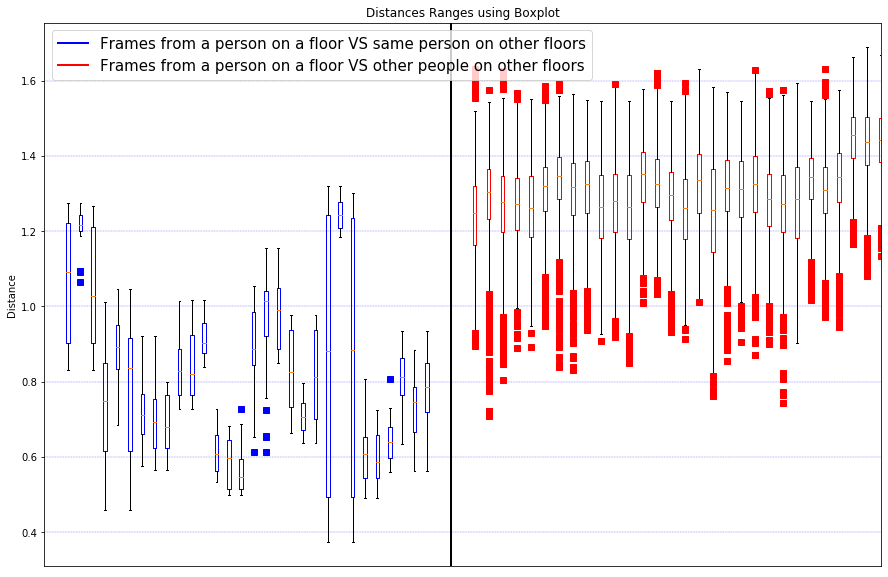

In [4]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# same_video_euclidean_distance_list[:30],
                                                      same_person_euclidean_distance_list[:30],
                                                      different_people_euclidean_distance_list[:30])

dpb.draw_plot()


##### 2.6.9.4 Visualización de rangos de distancias euclídeas concentradas en únicamente dos *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

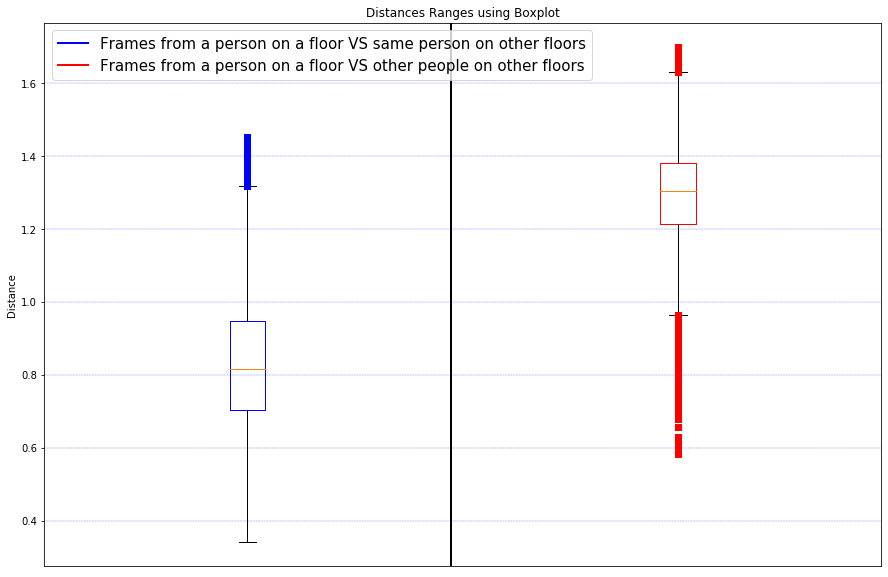

In [5]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# numpy.concatenate(same_video_euclidean_distance_list),
                                                      numpy.concatenate(same_person_euclidean_distance_list),
                                                      numpy.concatenate(different_people_euclidean_distance_list))
dpb.draw_plot()


##### 2.6.9.5 Cálculo del mejor umbral a través de *FAR*, *FRR* y *EER* (Módulo `thresholdvalidator` mediante `utils.threshold_plotter`)

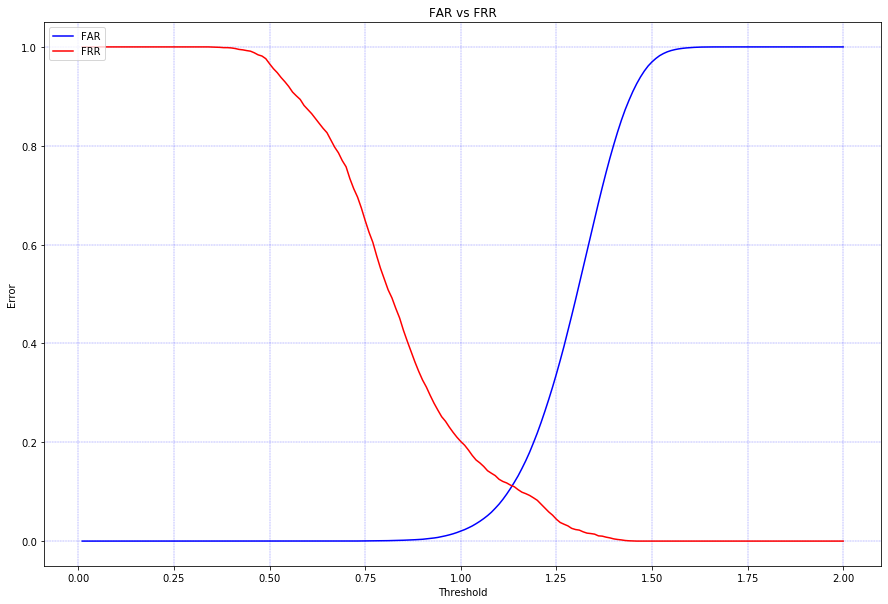


Best threshold: 1.13
EER: 0.107


In [6]:
tp = threshold_plotter.ThresholdPlotter(resize_face_embeddings_train, threshold_min=0.01, threshold_max=2)

tp.draw_plot()

best_threshold, eer = tp.calculate_best_threshold_and_eer() 

print("\nBest threshold:", best_threshold)
print("EER:", eer)

##### Obtención del dataframe y de pares de vídeos de personas iguales y distintas para el *dataset* formado por zonas del ascensor en cámaras 2, 5 y 8 (Módulo `accuracymeter`) (test)

In [2]:
resize_face_embeddings_test = embeddings_assembler.load_panda_embeddings('2020-07-02_00-51-37-556303-facenet_resize_hog_lift_place_2_5_8_test-dlib-hog-data.pickle')
same_person_videos_id_pairs_list_test = accuracy_meter.get_same_person_videos_ids_pairs(resize_face_embeddings_test)
different_person_videos_id_pairs_list_test = accuracy_meter.get_different_people_videos_ids_pairs(resize_face_embeddings_test)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list_test.sort()
different_person_videos_id_pairs_list_test.sort()
random.shuffle(same_person_videos_id_pairs_list_test)
random.shuffle(different_person_videos_id_pairs_list_test)
mixed_videos_id_pairs_list_test = same_person_videos_id_pairs_list_test.copy()
mixed_videos_id_pairs_list_test.extend(different_person_videos_id_pairs_list_test)

##### 2.6.9.6 Muestra gráfica del *accuracy* respecto al índice de confianza (Mediante `utils.confidence_plotter`)

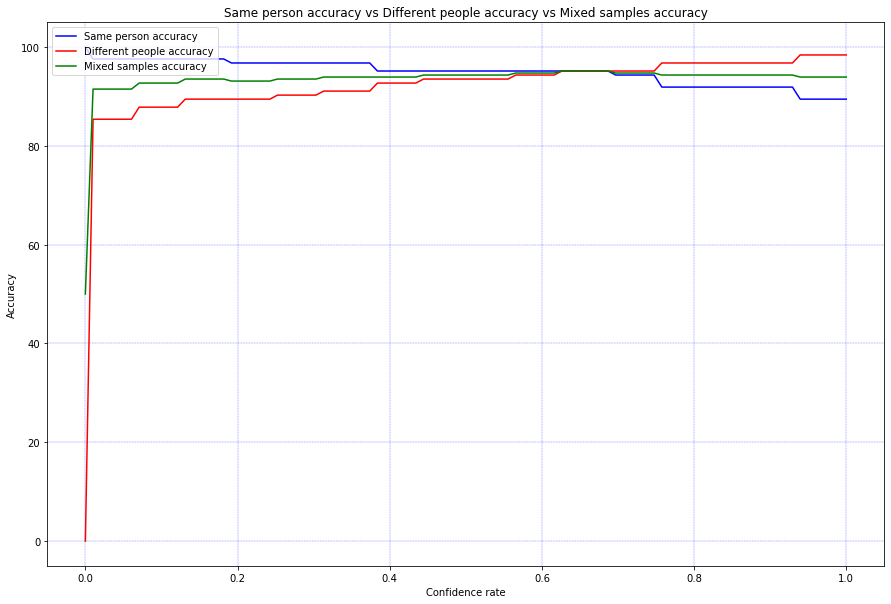


Best confidence rate: 0.626
Same person pairs accuracy:  95.122 %
Different people pairs accuracy:  95.122 %
Accuracy (with same number of same person pairs and different people pairs): 95.122 %


In [3]:
cp = confidence_plotter.ConfidencePlotter(resize_face_embeddings_test, same_person_videos_id_pairs_list_test,
                                          different_person_videos_id_pairs_list_test[:123], threshold=1.13)

cp.draw_plot()

results = cp.calculate_best_confidence_rate_and_accuracy() 

print("\nBest confidence rate:", results[0])
print("Same person pairs accuracy: ", results[1], "%")
print("Different people pairs accuracy: ", results[2], "%")
print("Accuracy (with same number of same person pairs and different people pairs):", results[3], "%")

##### 2.6.9.7 Medida del *accuracy* con el mejor índice de confianza en pares con misma persona, distinta persona y mezclados (Módulo `accuracymeter`)

In [4]:
same_person_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                          same_person_videos_id_pairs_list_test, 
                                                          confidence=0.626,
                                                          threshold=1.13,
                                                          print_iterations=True)

different_person_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                               different_person_videos_id_pairs_list_test, 
                                                               confidence=0.626,
                                                               threshold=1.13,
                                                               print_iterations=True)

mixed_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test, 
                                                    mixed_videos_id_pairs_list_test, 
                                                    confidence=0.626,
                                                    threshold=1.13,
                                                    print_iterations=True)

print()
print("Same person accuracy: " + str(same_person_videos_accuracy) + " %")
print("Different people accuracy: " + str(different_person_videos_accuracy) + " %")
print("Mixed videos accuracy (with different number of same person pairs and different people pairs): " + str(mixed_videos_accuracy) + " %")

[Getting accuracy (sample 5042/5043)]
Same person accuracy: 95.122 %
Different people accuracy: 93.211 %
Mixed videos accuracy (with different number of same person pairs and different people pairs): 93.258 %


##### 2.6.9.8 Varios test de funcionamiento de la verificación (Módulo `verifier`)

In [6]:
vf = verifier.Verifier(resize_face_embeddings_test, confidence=0.626, threshold=1.13)

sp_vipl_copy = same_person_videos_id_pairs_list_test.copy()
dp_vipl_copy = different_person_videos_id_pairs_list_test.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_01-32_01_02_01_02/ VS averobot_floor_03-32_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-87_01_02_04_02/ VS averobot_floor_03-87_03_02_33_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-45_01_02_13_02/ VS averobot_floor_03-45_03_02_10_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-91_02_02_11_05/ VS averobot_floor_03-91_03_02_34_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-52_01_02_01_02/ VS averobot_floor_03-52_03_02_28_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-92_01_02_01_02/ VS averobot_floor_03-92_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-89_01_02_08_02/ VS averobot_floor_02-89_02_02_27_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-73_01_02_14_02/ VS averobot_floor_03-73_03_02_33_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-92_01_02_01_02/ V

#### 2.6.10 Evaluación de detección con *MTCNN* con redimensión de la imagen detectada y *embeddings* con 'l2' usando *VGGFace2 (ResNet50)* en lugar de *FaceNet*

##### 2.6.10.1 Carga de distancias euclídeas a través de los descriptores del dataframe construido (Módulo `distancematrixcalculator`)

In [2]:
resize_face_embeddings_train = embeddings_assembler.load_panda_embeddings('2020-07-02_01-09-07-814043-vggface_resize_lift_place_2_5_8_train-data-resize.pickle')
# [same_video_results_list, same_video_euclidean_distance_list] = distances_matrix_loader.get_same_video_distance_matrices(resize_face_embeddings_train)
[same_person_results_list, same_person_euclidean_distance_list] = distances_matrix_loader.get_same_person_distance_matrices(resize_face_embeddings_train)
[different_people_results_list, different_people_euclidean_distance_list] = distances_matrix_loader.get_different_people_distance_matrices(resize_face_embeddings_train)


##### 2.6.10.2 Visualización de rangos de distancias euclídeas (Mediante `utils.distance_plotter`)

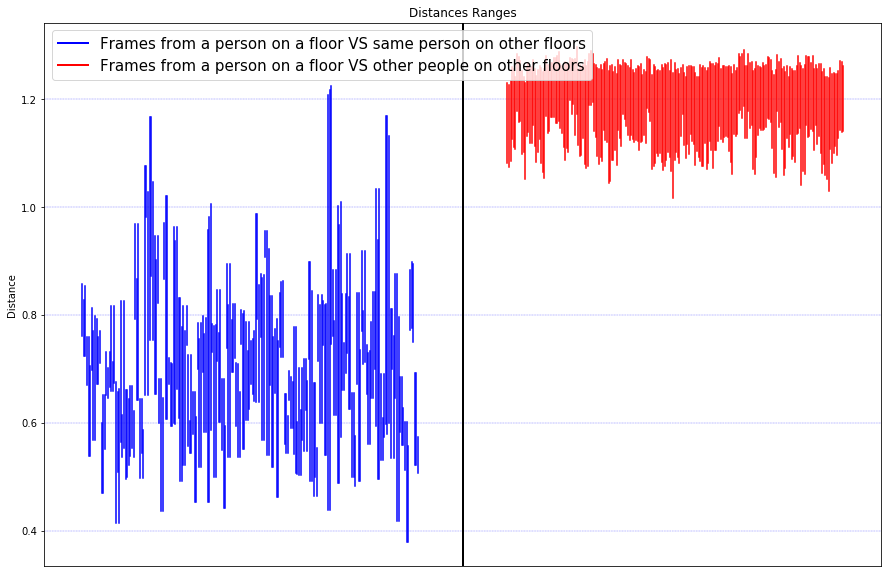

In [3]:
dp = distance_plotter.DistancePlotter(# same_video_results_list,
                                      same_person_results_list,
                                      different_people_results_list)
dp.draw_plot()

##### 2.6.10.3 Visualización de rangos de distancias euclídeas con *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

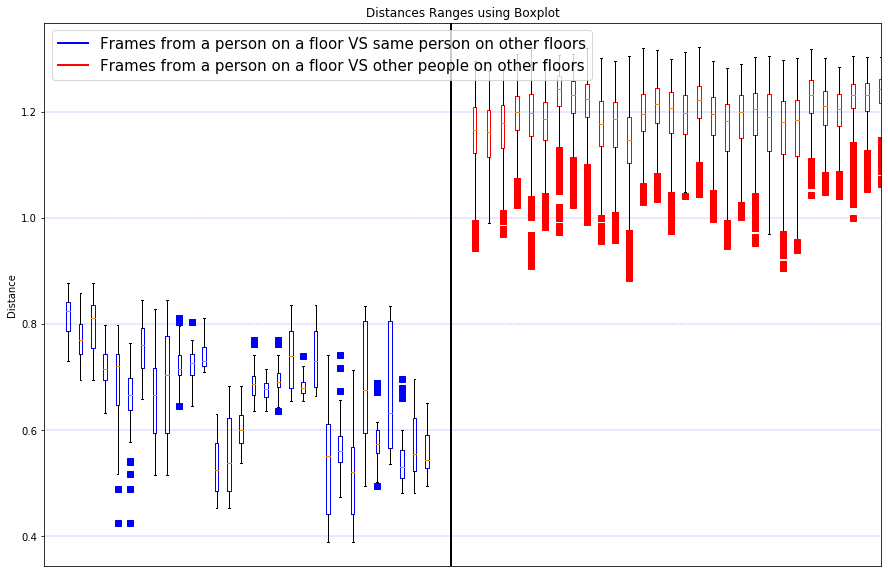

In [4]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# same_video_euclidean_distance_list[:30],
                                                      same_person_euclidean_distance_list[:30],
                                                      different_people_euclidean_distance_list[:30])

dpb.draw_plot()


##### 2.6.10.4 Visualización de rangos de distancias euclídeas concentradas en únicamente dos *Boxplot* (Mediante `utils.distance_plotter_boxplot`)

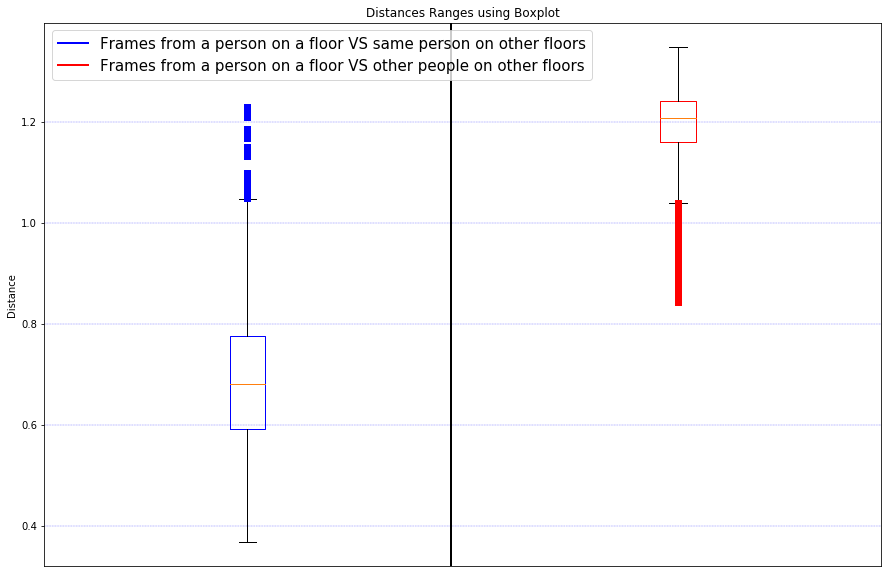

In [5]:
dpb = distance_plotter_boxplot.DistancePlotterBoxplot(# numpy.concatenate(same_video_euclidean_distance_list),
                                                      numpy.concatenate(same_person_euclidean_distance_list),
                                                      numpy.concatenate(different_people_euclidean_distance_list))
dpb.draw_plot()


##### 2.6.10.5 Cálculo del mejor umbral a través de *FAR*, *FRR* y *EER* (Módulo `thresholdvalidator` mediante `utils.threshold_plotter`)

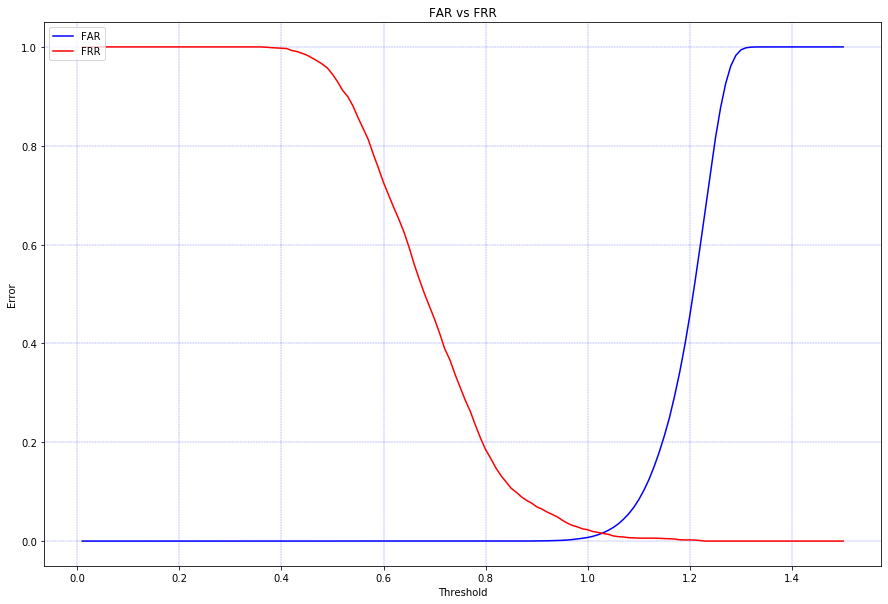


Best threshold: 1.03
EER: 0.017


In [6]:
tp = threshold_plotter.ThresholdPlotter(resize_face_embeddings_train, threshold_min=0.01, threshold_max=1.5)

tp.draw_plot()

best_threshold, eer = tp.calculate_best_threshold_and_eer()

print("\nBest threshold:", best_threshold)
print("EER:", eer)

##### Obtención del dataframe y de pares de vídeos de personas iguales y distintas para el *dataset* formado por zonas del ascensor en cámaras 2, 5 y 8 (Módulo `accuracymeter`) (test)

In [2]:
resize_face_embeddings_test = embeddings_assembler.load_panda_embeddings('2020-07-02_01-08-51-697175-vggface_resize_lift_place_2_5_8_test-data-resize.pickle')
same_person_videos_id_pairs_list_test = accuracy_meter.get_same_person_videos_ids_pairs(resize_face_embeddings_test)
different_person_videos_id_pairs_list_test = accuracy_meter.get_different_people_videos_ids_pairs(resize_face_embeddings_test)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list_test.sort()
different_person_videos_id_pairs_list_test.sort()
random.shuffle(same_person_videos_id_pairs_list_test)
random.shuffle(different_person_videos_id_pairs_list_test)
mixed_videos_id_pairs_list_test = same_person_videos_id_pairs_list_test.copy()
mixed_videos_id_pairs_list_test.extend(different_person_videos_id_pairs_list_test)

##### 2.6.10.6 Muestra gráfica del *accuracy* respecto al índice de confianza (Mediante `utils.confidence_plotter`)

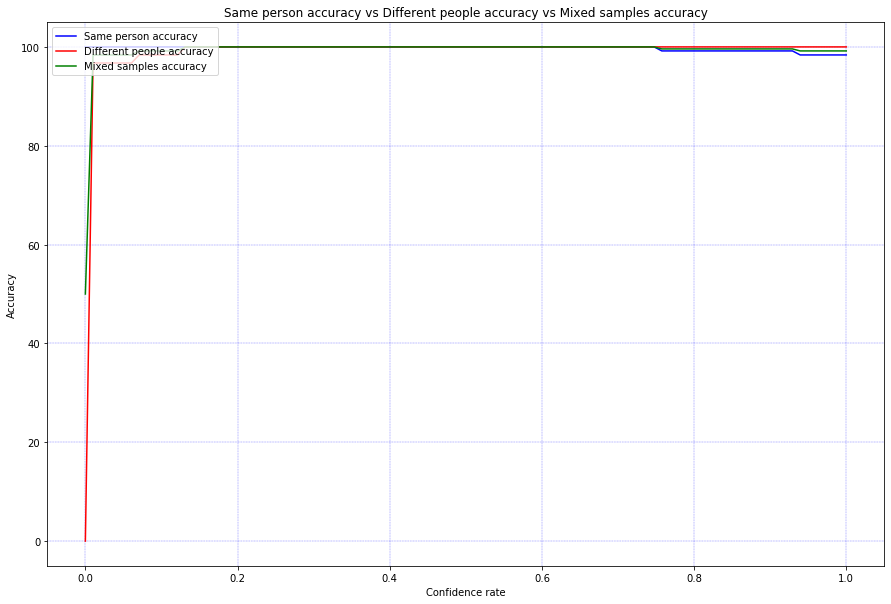


Best confidence rate: 0.131
Same person pairs accuracy:  100.0 %
Different people pairs accuracy:  100.0 %
Accuracy (with same number of same person pairs and different people pairs): 100.0 %


In [3]:
cp = confidence_plotter.ConfidencePlotter(resize_face_embeddings_test, same_person_videos_id_pairs_list_test,
                                          different_person_videos_id_pairs_list_test[:123], threshold=1.03)

cp.draw_plot()

results = cp.calculate_best_confidence_rate_and_accuracy()

print("\nBest confidence rate:", results[0])
print("Same person pairs accuracy: ", results[1], "%")
print("Different people pairs accuracy: ", results[2], "%")
print("Accuracy (with same number of same person pairs and different people pairs):", results[3], "%")

##### 2.6.10.7 Medida del *accuracy* con el mejor índice de confianza en pares con misma persona, distinta persona y mezclados (Módulo `accuracymeter`)

In [4]:
same_person_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test,
                                                          same_person_videos_id_pairs_list_test,
                                                          confidence=0.131,
                                                          threshold=1.03,
                                                          print_iterations=True)

different_person_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test,
                                                               different_person_videos_id_pairs_list_test,
                                                               confidence=0.131,
                                                               threshold=1.03,
                                                               print_iterations=True)

mixed_videos_accuracy = accuracy_meter.get_accuracy(resize_face_embeddings_test,
                                                    mixed_videos_id_pairs_list_test,
                                                    confidence=0.131,
                                                    threshold=1.03,
                                                    print_iterations=True)

print()
print("Same person accuracy: " + str(same_person_videos_accuracy) + " %")
print("Different people accuracy: " + str(different_person_videos_accuracy) + " %")
print("Mixed videos accuracy (with different number of same person pairs and different people pairs): " + str(mixed_videos_accuracy) + " %")

[Getting accuracy (sample 5042/5043)]
Same person accuracy: 100.0 %
Different people accuracy: 98.272 %
Mixed videos accuracy (with different number of same person pairs and different people pairs): 98.314 %


##### 2.6.10.8 Varios test de funcionamiento de la verificación (Módulo `verifier`)

In [8]:
vf = verifier.Verifier(resize_face_embeddings_test, confidence=0.131, threshold=1.03)

sp_vipl_copy = same_person_videos_id_pairs_list_test.copy()
dp_vipl_copy = different_person_videos_id_pairs_list_test.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['distance_matrix']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_01-81_01_02_01_02/ VS averobot_floor_02-81_02_02_11_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-15_02_02_05_05/ VS averobot_floor_03-15_03_02_27_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-11_01_02_01_02/ VS averobot_floor_02-11_02_02_19_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-52_02_02_30_05/ VS averobot_floor_03-52_03_02_28_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-81_02_02_11_05/ VS averobot_floor_03-81_03_02_19_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-89_02_02_27_05/ VS averobot_floor_03-89_03_02_32_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-91_01_02_27_02/ VS averobot_floor_02-91_02_02_11_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-87_02_02_20_05/ VS averobot_floor_03-87_03_02_33_08/:	{'is_same_person': True, 'confidence': 0.938}]
[averobot_floor_01-79_01_02_01_02/

### 2.7 Verificación mediante redes neuronales y evaluación de resultados (Módulo `verifiermodel`)

En esta sección se comenzará a comparar los distintos prototipos desarrollados para la verificación basada en redes neuronales con el fin de observar cuál de ellos posee una mayor tasa de acierto y menor error en el objetivo del proyecto.

Todos los prototipos desarrollados se encuentran descritos en el **apartado 7.2.3** de la memoria del Trabajo de Fin de Grado.

#### 2.7.1 Uso del modelo predeterminado: 4 *embeddings* (2 por vídeo) aportados por dos detectores (*MTCNN* y *DLIB-MMOD*)

##### 2.7.1.1 Creación del verificador

In [2]:
nn_vf = nnverifier.NNVerifier(train_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-18_23-50-56-177873-new_detections_lift_place_2_5_8_train-data-resize.pickle'),
                              train_videos_embeddings_2=embeddings_assembler.load_panda_embeddings('2020-04-19_15-22-39-540389-lift_place_2_5_8_train-dlib-mmod-data.pickle'),
                              test_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-12_19-20-05-763843-new_detections_lift_place_2_5_8-data-resize.pickle'),
                              test_videos_embeddings_2=embeddings_assembler.load_panda_embeddings('2020-04-19_02-23-33-894032-lift_place_2_5_8-dlib-mmod-data.pickle'),
                              mlp_type='default')

##### 2.7.1.2 Obtención de entradas para entrenamiento y test 

In [3]:
"""
Number of pairs that should be generated:
(FrameNumber^(2*NDetector))*People*PeopleToCompare*NumberOfFloors*2
"""

[same_person_embeddings_pairs_train, different_people_embeddings_pairs_train] = nn_vf.get_embeddings_pairs(pair_type='train')
[same_person_embeddings_pairs_test, different_people_embeddings_pairs_test] = nn_vf.get_embeddings_pairs(pair_type='test')

[Getting all possible pairs...]
[All pairs have been generated successfully (107520 same person pairs & 7418880 different people pairs)
[Getting all possible pairs...]
[All pairs have been generated successfully (62976 same person pairs & 2519040 different people pairs)


##### 2.7.1.3 Creación y entrenamiento de la red neuronal

In [6]:
nn_vf.create_mlp(print_summary=True)
nn_vf.train_model(same_person_embeddings_pairs_train, different_people_embeddings_pairs_train)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2048)              1050624   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

##### 2.7.1.4 Guardado de la red neuronal

In [9]:
nn_vf.save_model('default')

##### 2.7.1.5 Carga de la red neuronal

In [3]:
nn_vf.load_model('2020-04-26_13-49-42-690624-default.h5')

##### 2.7.1.6 *Accuracy*  y *Loss* del conjunto de test

In [8]:
nn_vf.evaluate(same_person_embeddings_pairs_test, different_people_embeddings_pairs_test)

125952/125952 [==============================] - 8s 61us/step
Accuracy: 0.829 | Loss: 0.422


##### 2.7.1.7 Calidad de la red neuronal (Mediante `utils.nn_verifier_metrics_plotter`)

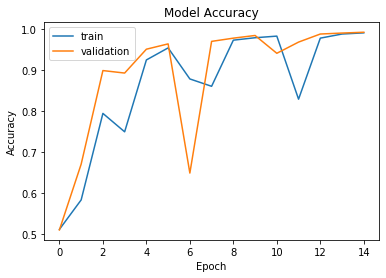

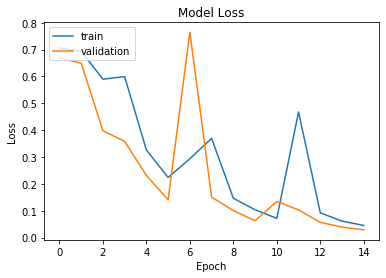

In [10]:
nn_vf_mp = nn_verifier_metrics_plotter.NNVerifierMetricsPlotter(nn_vf.history)

nn_vf_mp.plot_accuracy()
nn_vf_mp.plot_loss()

##### 2.7.1.8 Varios test de funcionamiento de la verificación

Se cargan pares de ids de vídeos de la misma persona y de diferente persona para las pruebas. Estos pares proceden del conjunto de test (ya que se considera el método fundamental de la aplicación final).

In [4]:
same_person_videos_id_pairs_list = accuracy_meter.get_same_person_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
different_person_videos_id_pairs_list = accuracy_meter.get_different_people_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list.sort()
different_person_videos_id_pairs_list.sort()
random.shuffle(same_person_videos_id_pairs_list)
random.shuffle(different_person_videos_id_pairs_list)

In [274]:
sp_vipl_copy = same_person_videos_id_pairs_list.copy()
dp_vipl_copy = different_person_videos_id_pairs_list.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_01-83_01_02_01_02/ VS averobot_floor_03-83_03_02_04_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-98_02_02_34_05/ VS averobot_floor_03-98_03_02_22_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-48_01_02_04_02/ VS averobot_floor_02-48_02_02_05_05/:	{'is_same_person': False, 'confidence': 0.926}]
[averobot_floor_01-32_01_02_01_02/ VS averobot_floor_03-32_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-88_01_02_08_02/ VS averobot_floor_02-88_02_02_27_05/:	{'is_same_person': True, 'confidence': 0.914}]
[averobot_floor_02-110_02_02_13_05/ VS averobot_floor_03-110_03_02_03_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-104_01_02_08_02/ VS averobot_floor_03-104_03_02_20_08/:	{'is_same_person': False, 'confidence': 1.0}]
[averobot_floor_01-73_01_02_14_02/ VS averobot_floor_03-73_03_02_33_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-38_01_0

##### 2.7.1.9 Visualización de pares de frames fallidos (Falso negativo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-246.jpg', 'frame-236.jpg', 'frame-061.jpg', 'frame-055.jpg')


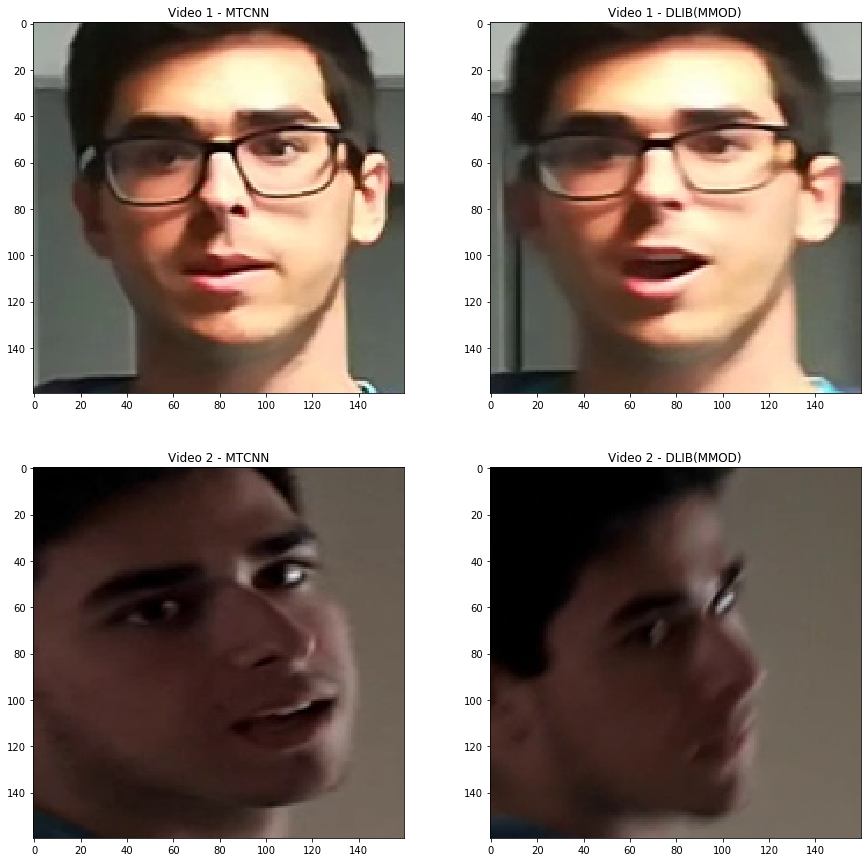

In [282]:
id_video_1 = 'averobot_floor_01-38_01_02_01_02/'
id_video_2 = 'averobot_floor_03-38_03_02_14_08/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=True,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=4,
                                                                               used_frames_detector_2=4,
                                                                               detector_1='mtcnn',
                                                                               detector_2='dlib_mmod')

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='dlib_mmod')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

frame_3 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][2])
face_cut_3 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_3 = [face['box'] for index, face in enumerate(face_cut_3) if face['frame_number'] == failed_frames_pairs[used_index][2]][0]
face_box_3[2] = face_box_3[0] + face_box_3[2]
face_box_3[3] = face_box_3[1] + face_box_3[3]
embedding_frame_3 = frame_3.crop(tuple(face_box_3)).resize([160, 160])

frame_4 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][3])
face_cut_4 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='dlib_mmod')
face_box_4 = [face['box'] for index, face in enumerate(face_cut_4) if face['frame_number'] == failed_frames_pairs[used_index][3]][0]
face_box_4[2] = face_box_4[0] + face_box_4[2]
face_box_4[3] = face_box_4[1] + face_box_4[3]
embedding_frame_4 = frame_4.crop(tuple(face_box_4)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(2,2,2)
plt.title("Video 1 - DLIB(MMOD)")
plt.imshow(embedding_frame_2)

plt.subplot(2,2,3)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_3)

plt.subplot(2,2,4)
plt.title("Video 2 - DLIB(MMOD)")
plt.imshow(embedding_frame_4)

##### 2.7.1.10 Visualización de pares de frames fallidos (Falso positivo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-227.jpg', 'frame-234.jpg', 'frame-180.jpg', 'frame-178.jpg')


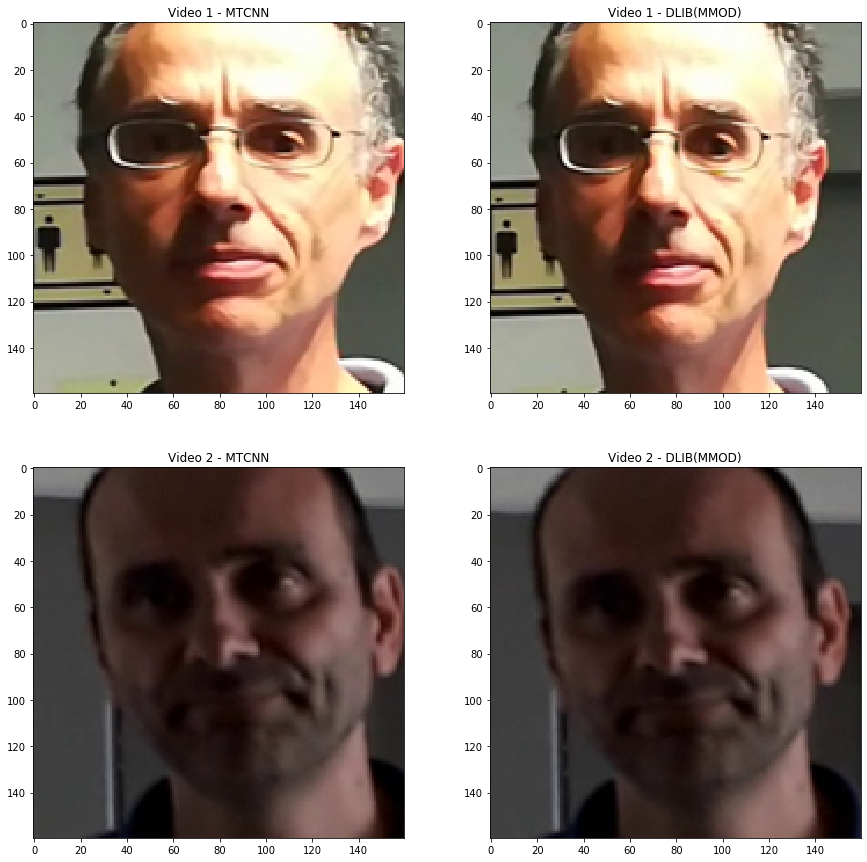

In [275]:
id_video_1 = 'averobot_floor_01-09_01_02_26_02/'
id_video_2 = 'averobot_floor_03-15_03_02_27_08/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=False,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=4,
                                                                               used_frames_detector_2=4,
                                                                               detector_1='mtcnn',
                                                                               detector_2='dlib_mmod')

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='dlib_mmod')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

frame_3 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][2])
face_cut_3 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_3 = [face['box'] for index, face in enumerate(face_cut_3) if face['frame_number'] == failed_frames_pairs[used_index][2]][0]
face_box_3[2] = face_box_3[0] + face_box_3[2]
face_box_3[3] = face_box_3[1] + face_box_3[3]
embedding_frame_3 = frame_3.crop(tuple(face_box_3)).resize([160, 160])

frame_4 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][3])
face_cut_4 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='dlib_mmod')
face_box_4 = [face['box'] for index, face in enumerate(face_cut_4) if face['frame_number'] == failed_frames_pairs[used_index][3]][0]
face_box_4[2] = face_box_4[0] + face_box_4[2]
face_box_4[3] = face_box_4[1] + face_box_4[3]
embedding_frame_4 = frame_4.crop(tuple(face_box_4)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(2,2,2)
plt.title("Video 1 - DLIB(MMOD)")
plt.imshow(embedding_frame_2)

plt.subplot(2,2,3)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_3)

plt.subplot(2,2,4)
plt.title("Video 2 - DLIB(MMOD)")
plt.imshow(embedding_frame_4)

#### 2.7.2 Uso del modelo de resta: 4 *embeddings* (2 por vídeo) aportados por dos detectores (*MTCNN* y *DLIB-MMOD*) restados entre sí (los 2 *embeddings* de una identidad menos los 2 *embeddings* de la otra)

##### 2.7.2.1 Creación del verificador

In [2]:
nn_vf = nnverifier.NNVerifier(train_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-18_23-50-56-177873-new_detections_lift_place_2_5_8_train-data-resize.pickle'),
                              train_videos_embeddings_2=embeddings_assembler.load_panda_embeddings('2020-04-19_15-22-39-540389-lift_place_2_5_8_train-dlib-mmod-data.pickle'),
                              test_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-12_19-20-05-763843-new_detections_lift_place_2_5_8-data-resize.pickle'),
                              test_videos_embeddings_2=embeddings_assembler.load_panda_embeddings('2020-04-19_02-23-33-894032-lift_place_2_5_8-dlib-mmod-data.pickle'),
                              mlp_type='subtract')

##### 2.7.2.2 Obtención de entradas para entrenamiento y test 

Los ficheros que se cargan mediante *pickle* contienen los *embeddings* que servirán para entrenamiento y evaluación. Se realiza de este modo para evitar volver a calcularlos todos repetidamente (el tiempo que tarda incrementa debido a la concatenación y resta de los *embeddings*).

In [3]:
# [same_person_embeddings_pairs_train, different_people_embeddings_pairs_train] = nn_vf.get_embeddings_pairs(pair_type='train')
# [same_person_embeddings_pairs_test, different_people_embeddings_pairs_test] = nn_vf.get_embeddings_pairs(pair_type='test')

sp_train_s = open(os.getenv('MAIN_ROUTE') + "/out/nn-embeddings-pairs/same-person-train-subtract.pickle", 'rb')
same_person_embeddings_pairs_train = pickle.load(sp_train_s)
sp_train_s.close()

dp_train_s = open(os.getenv('MAIN_ROUTE') + "/out/nn-embeddings-pairs/different-people-train-subtract.pickle", 'rb')
different_people_embeddings_pairs_train = pickle.load(dp_train_s)
dp_train_s.close()

sp_test_s = open(os.getenv('MAIN_ROUTE') + "/out/nn-embeddings-pairs/same-person-test-subtract.pickle", 'rb')
same_person_embeddings_pairs_test = pickle.load(sp_test_s)
sp_test_s.close()

dp_test_s = open(os.getenv('MAIN_ROUTE') + "/out/nn-embeddings-pairs/different-people-test-subtract.pickle", 'rb')
different_people_embeddings_pairs_test = pickle.load(dp_test_s)
dp_test_s.close()

In [4]:
# spts = open("out/nn-embeddings-pairs/same-person-train-subtract.pickle", 'wb+')
# pickle.dump(same_person_embeddings_pairs_train, spts)
# spts.close()

# dpts = open("out/nn-embeddings-pairs/different-people-train-subtract.pickle", 'wb+')
# random.shuffle(different_people_embeddings_pairs_train)
# pickle.dump(different_people_embeddings_pairs_train[:len(same_person_embeddings_pairs_train)], dpts)
# dpts.close()

# spts_test = open("out/nn-embeddings-pairs/same-person-test-subtract.pickle", 'wb+')
# pickle.dump(same_person_embeddings_pairs_test, spts_test)
# spts_test.close()

# dpts_test = open("out/nn-embeddings-pairs/different-people-test-subtract.pickle", 'wb+')
# random.shuffle(different_people_embeddings_pairs_test)
# pickle.dump(different_people_embeddings_pairs_test[:len(same_person_embeddings_pairs_test)], dpts_test)
# dpts_test.close()

##### 2.7.2.3 Creación y entrenamiento de la red neuronal

In [13]:
nn_vf.create_mlp(print_summary=True)
nn_vf.train_model(same_person_embeddings_pairs_train, different_people_embeddings_pairs_train, batch_size=75000, epochs=20)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 2048)              526336    
_________________________________________________________________
dropout_16 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                

##### 2.7.2.4 Guardado de la red neuronal

In [15]:
nn_vf.save_model('subtract')

##### 2.7.2.5 Carga de la red neuronal

In [3]:
nn_vf.load_model('2020-04-26_15-47-46-778152-subtract.h5')

##### 2.7.2.6 *Accuracy*  y *Loss* del conjunto de test

In [7]:
nn_vf.evaluate(same_person_embeddings_pairs_test, different_people_embeddings_pairs_test)

125952/125952 [==============================] - 8s 64us/step
Accuracy: 0.885 | Loss: 0.358


##### 2.7.2.7 Calidad de la red neuronal (Mediante `utils.nn_verifier_metrics_plotter`)

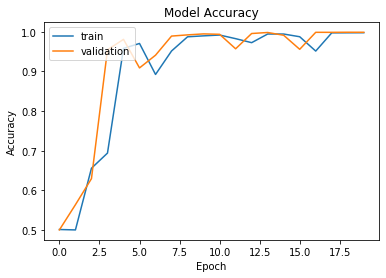

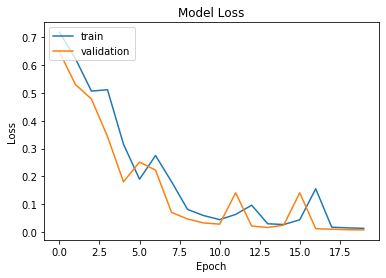

In [19]:
nn_vf_mp = nn_verifier_metrics_plotter.NNVerifierMetricsPlotter(nn_vf.history)

nn_vf_mp.plot_accuracy()
nn_vf_mp.plot_loss()

##### 2.7.2.8 Varios test de funcionamiento de la verificación

Se cargan pares de ids de vídeos de la misma persona y de diferente persona para las pruebas. Estos pares proceden del conjunto de test (ya que se considera el método fundamental de la aplicación final).

In [4]:
same_person_videos_id_pairs_list = accuracy_meter.get_same_person_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
different_person_videos_id_pairs_list = accuracy_meter.get_different_people_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list.sort()
different_person_videos_id_pairs_list.sort()
random.shuffle(same_person_videos_id_pairs_list)
random.shuffle(different_person_videos_id_pairs_list)

In [192]:
sp_vipl_copy = same_person_videos_id_pairs_list.copy()
dp_vipl_copy = different_person_videos_id_pairs_list.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_01-87_01_02_04_02/ VS averobot_floor_02-87_02_02_20_05/:	{'is_same_person': True, 'confidence': 0.742}]
[averobot_floor_01-104_01_02_08_02/ VS averobot_floor_02-104_02_02_08_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-52_01_02_01_02/ VS averobot_floor_02-52_02_02_30_05/:	{'is_same_person': False, 'confidence': 0.59}]
[averobot_floor_01-91_01_02_27_02/ VS averobot_floor_03-91_03_02_34_08/:	{'is_same_person': True, 'confidence': 0.941}]
[averobot_floor_01-09_01_02_26_02/ VS averobot_floor_02-09_02_02_33_05/:	{'is_same_person': False, 'confidence': 1.0}]
[averobot_floor_01-63_01_02_08_02/ VS averobot_floor_03-63_03_02_30_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-38_02_02_32_05/ VS averobot_floor_03-38_03_02_14_08/:	{'is_same_person': False, 'confidence': 0.812}]
[averobot_floor_01-37_01_02_08_02/ VS averobot_floor_03-37_03_02_06_08/:	{'is_same_person': True, 'confidence': 0.941}]
[averobot_floor_01-16_

##### 2.7.2.9 Visualización de pares de frames fallidos (Falso negativo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-204.jpg', 'frame-208.jpg', 'frame-1995.jpg', 'frame-1806.jpg')


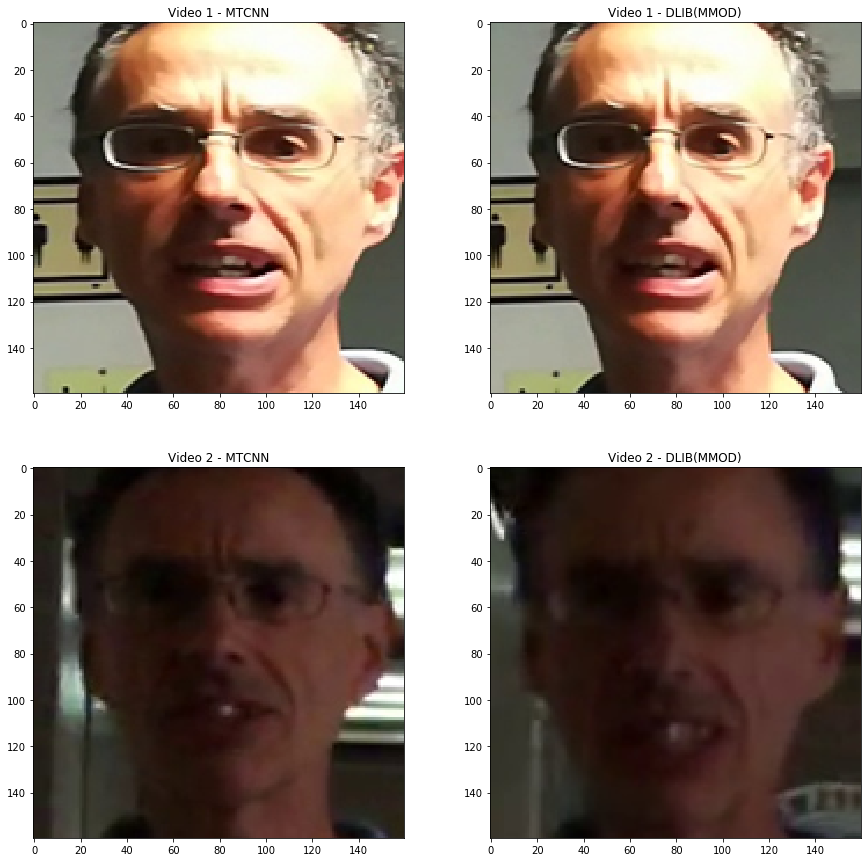

In [200]:
id_video_1 = 'averobot_floor_01-09_01_02_26_02/'
id_video_2 = 'averobot_floor_02-09_02_02_33_05/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=True,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=4,
                                                                               used_frames_detector_2=4,
                                                                               detector_1='mtcnn',
                                                                               detector_2='dlib_mmod')

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='dlib_mmod')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

frame_3 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][2])
face_cut_3 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_3 = [face['box'] for index, face in enumerate(face_cut_3) if face['frame_number'] == failed_frames_pairs[used_index][2]][0]
face_box_3[2] = face_box_3[0] + face_box_3[2]
face_box_3[3] = face_box_3[1] + face_box_3[3]
embedding_frame_3 = frame_3.crop(tuple(face_box_3)).resize([160, 160])

frame_4 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][3])
face_cut_4 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='dlib_mmod')
face_box_4 = [face['box'] for index, face in enumerate(face_cut_4) if face['frame_number'] == failed_frames_pairs[used_index][3]][0]
face_box_4[2] = face_box_4[0] + face_box_4[2]
face_box_4[3] = face_box_4[1] + face_box_4[3]
embedding_frame_4 = frame_4.crop(tuple(face_box_4)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(2,2,2)
plt.title("Video 1 - DLIB(MMOD)")
plt.imshow(embedding_frame_2)

plt.subplot(2,2,3)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_3)

plt.subplot(2,2,4)
plt.title("Video 2 - DLIB(MMOD)")
plt.imshow(embedding_frame_4)

##### 2.7.2.10 Visualización de pares de frames fallidos (Falso positivo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-120.jpg', 'frame-116.jpg', 'frame-085.jpg', 'frame-137.jpg')


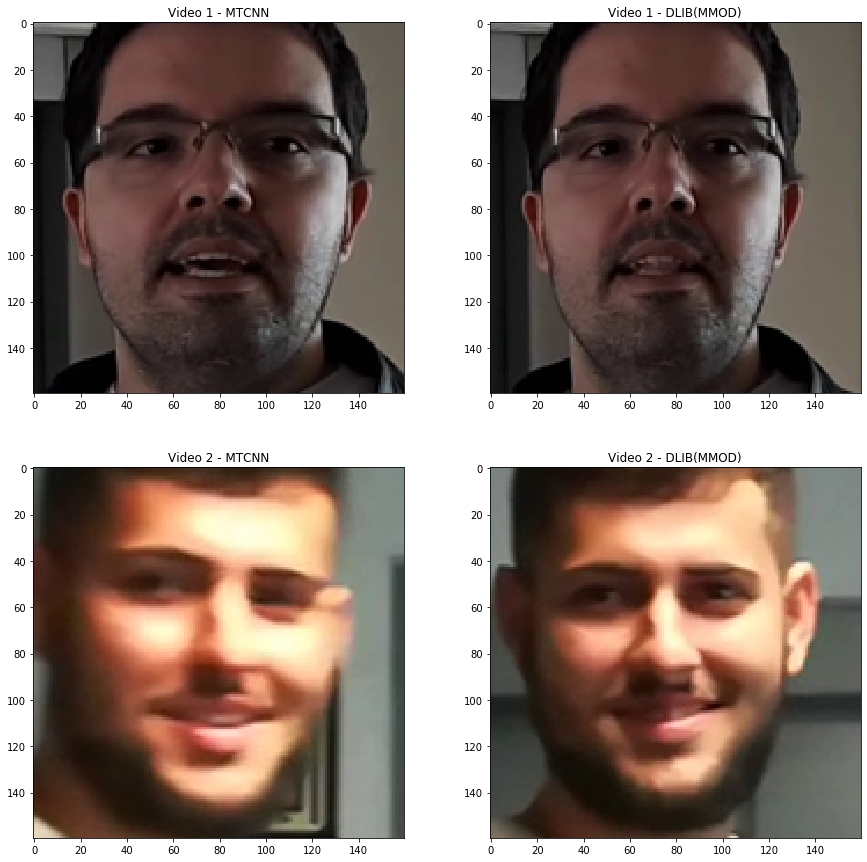

In [196]:
id_video_1 = 'averobot_floor_03-90_03_02_11_08/'
id_video_2 = 'averobot_floor_01-52_01_02_01_02/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=False,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=4,
                                                                               used_frames_detector_2=4,
                                                                               detector_1='mtcnn',
                                                                               detector_2='dlib_mmod')

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='dlib_mmod')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

frame_3 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][2])
face_cut_3 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_3 = [face['box'] for index, face in enumerate(face_cut_3) if face['frame_number'] == failed_frames_pairs[used_index][2]][0]
face_box_3[2] = face_box_3[0] + face_box_3[2]
face_box_3[3] = face_box_3[1] + face_box_3[3]
embedding_frame_3 = frame_3.crop(tuple(face_box_3)).resize([160, 160])

frame_4 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][3])
face_cut_4 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='dlib_mmod')
face_box_4 = [face['box'] for index, face in enumerate(face_cut_4) if face['frame_number'] == failed_frames_pairs[used_index][3]][0]
face_box_4[2] = face_box_4[0] + face_box_4[2]
face_box_4[3] = face_box_4[1] + face_box_4[3]
embedding_frame_4 = frame_4.crop(tuple(face_box_4)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(2,2,2)
plt.title("Video 1 - DLIB(MMOD)")
plt.imshow(embedding_frame_2)

plt.subplot(2,2,3)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_3)

plt.subplot(2,2,4)
plt.title("Video 2 - DLIB(MMOD)")
plt.imshow(embedding_frame_4)

#### 2.7.3 Uso del modelo de resta: 4 *embeddings* (2 por vídeo) aportados por dos detectores (*MTCNN* y *DLIB-MMOD*) restados entre sí (los 2 *embeddings* de una identidad menos los 2 *embeddings* de la otra) con valor absoluto en el resultado

##### 2.7.3.1 Creación del verificador

In [2]:
nn_vf = nnverifier.NNVerifier(train_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-18_23-50-56-177873-new_detections_lift_place_2_5_8_train-data-resize.pickle'),
                              train_videos_embeddings_2=embeddings_assembler.load_panda_embeddings('2020-04-19_15-22-39-540389-lift_place_2_5_8_train-dlib-mmod-data.pickle'),
                              test_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-12_19-20-05-763843-new_detections_lift_place_2_5_8-data-resize.pickle'),
                              test_videos_embeddings_2=embeddings_assembler.load_panda_embeddings('2020-04-19_02-23-33-894032-lift_place_2_5_8-dlib-mmod-data.pickle'),
                              mlp_type='abs_subtract')

##### 2.7.3.2 Obtención de entradas para entrenamiento y test 

In [3]:
# [same_person_embeddings_pairs_train, different_people_embeddings_pairs_train] = nn_vf.get_embeddings_pairs(pair_type='train')
# [same_person_embeddings_pairs_test, different_people_embeddings_pairs_test] = nn_vf.get_embeddings_pairs(pair_type='test')

sp_train_as = open(os.getenv('MAIN_ROUTE') + "/out/nn-embeddings-pairs/same-person-train-abs_subtract.pickle", 'rb')
same_person_embeddings_pairs_train = pickle.load(sp_train_as)
sp_train_as.close()

dp_train_as = open(os.getenv('MAIN_ROUTE') + "/out/nn-embeddings-pairs/different-people-train-abs_subtract.pickle", 'rb')
different_people_embeddings_pairs_train = pickle.load(dp_train_as)
dp_train_as.close()

sp_test_as = open(os.getenv('MAIN_ROUTE') + "/out/nn-embeddings-pairs/same-person-test-abs_subtract.pickle", 'rb')
same_person_embeddings_pairs_test = pickle.load(sp_test_as)
sp_test_as.close()

dp_test_as = open(os.getenv('MAIN_ROUTE') + "/out/nn-embeddings-pairs/different-people-test-abs_subtract.pickle", 'rb')
different_people_embeddings_pairs_test = pickle.load(dp_test_as)
dp_test_as.close()

In [4]:
# spts = open("out/nn-embeddings-pairs/same-person-train-abs_subtract.pickle", 'wb+')
# pickle.dump(same_person_embeddings_pairs_train, spts)
# spts.close()

# dpts = open("out/nn-embeddings-pairs/different-people-train-abs_subtract.pickle", 'wb+')
# random.shuffle(different_people_embeddings_pairs_train)
# pickle.dump(different_people_embeddings_pairs_train[:len(same_person_embeddings_pairs_train)], dpts)
# dpts.close()

# spts_test = open("out/nn-embeddings-pairs/same-person-test-abs_subtract.pickle", 'wb+')
# pickle.dump(same_person_embeddings_pairs_test, spts_test)
# spts_test.close()

# dpts_test = open("out/nn-embeddings-pairs/different-people-test-abs_subtract.pickle", 'wb+')
# random.shuffle(different_people_embeddings_pairs_test)
# pickle.dump(different_people_embeddings_pairs_test[:len(same_person_embeddings_pairs_test)], dpts_test)
# dpts_test.close()

##### 2.7.3.3 Creación y entrenamiento de la red neuronal

In [29]:
nn_vf.create_mlp(print_summary=True)
nn_vf.train_model(same_person_embeddings_pairs_train, different_people_embeddings_pairs_train, batch_size=50000, epochs=40)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 2048)              526336    
_________________________________________________________________
dropout_40 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_41 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_42 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 1)               

##### 2.7.3.4 Guardado de la red neuronal

In [31]:
nn_vf.save_model('abs_subtract')

##### 2.7.3.5 Carga de la red neuronal

In [3]:
nn_vf.load_model('2020-04-27_01-02-25-242143-abs_subtract.h5')

##### 2.7.3.6 *Accuracy*  y *Loss* del conjunto de test

In [30]:
nn_vf.evaluate(same_person_embeddings_pairs_test, different_people_embeddings_pairs_test)

125952/125952 [==============================] - 6s 49us/step
Accuracy: 0.923 | Loss: 0.209


##### 2.7.3.7 Calidad de la red neuronal (Mediante `utils.nn_verifier_metrics_plotter`)

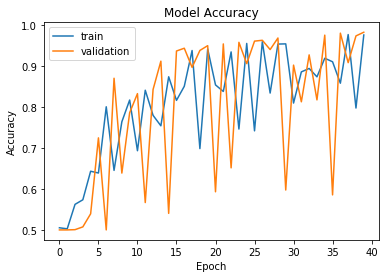

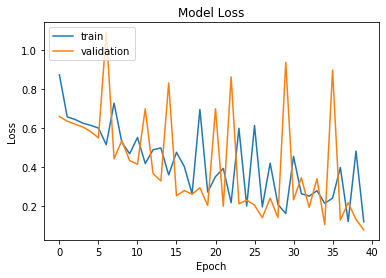

In [32]:
nn_vf_mp = nn_verifier_metrics_plotter.NNVerifierMetricsPlotter(nn_vf.history)

nn_vf_mp.plot_accuracy()
nn_vf_mp.plot_loss()

##### 2.7.3.8 Varios test de funcionamiento de la verificación

Se cargan pares de ids de vídeos de la misma persona y de diferente persona para las pruebas. Estos pares proceden del conjunto de test (ya que se considera el método fundamental de la aplicación final).

In [4]:
same_person_videos_id_pairs_list = accuracy_meter.get_same_person_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
different_person_videos_id_pairs_list = accuracy_meter.get_different_people_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list.sort()
different_person_videos_id_pairs_list.sort()
random.shuffle(same_person_videos_id_pairs_list)
random.shuffle(different_person_videos_id_pairs_list)

In [21]:
sp_vipl_copy = same_person_videos_id_pairs_list.copy()
dp_vipl_copy = different_person_videos_id_pairs_list.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_02-26_02_02_32_05/ VS averobot_floor_03-26_03_02_15_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-101_02_02_08_05/ VS averobot_floor_03-101_03_02_10_08/:	{'is_same_person': True, 'confidence': 0.973}]
[averobot_floor_02-11_02_02_19_05/ VS averobot_floor_03-11_03_02_10_08/:	{'is_same_person': False, 'confidence': 1.0}]
[averobot_floor_02-80_02_02_27_05/ VS averobot_floor_03-80_03_02_30_08/:	{'is_same_person': True, 'confidence': 0.98}]
[averobot_floor_01-98_01_02_01_02/ VS averobot_floor_03-98_03_02_22_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-108_01_02_05_02/ VS averobot_floor_03-108_03_02_01_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-53_02_02_30_05/ VS averobot_floor_03-53_03_02_28_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-86_01_02_10_02/ VS averobot_floor_03-86_03_02_08_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-99_01_02_

##### 2.7.3.9 Visualización de pares de frames fallidos (Falso negativo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-146.jpg', 'frame-146.jpg', 'frame-176.jpg', 'frame-179.jpg')


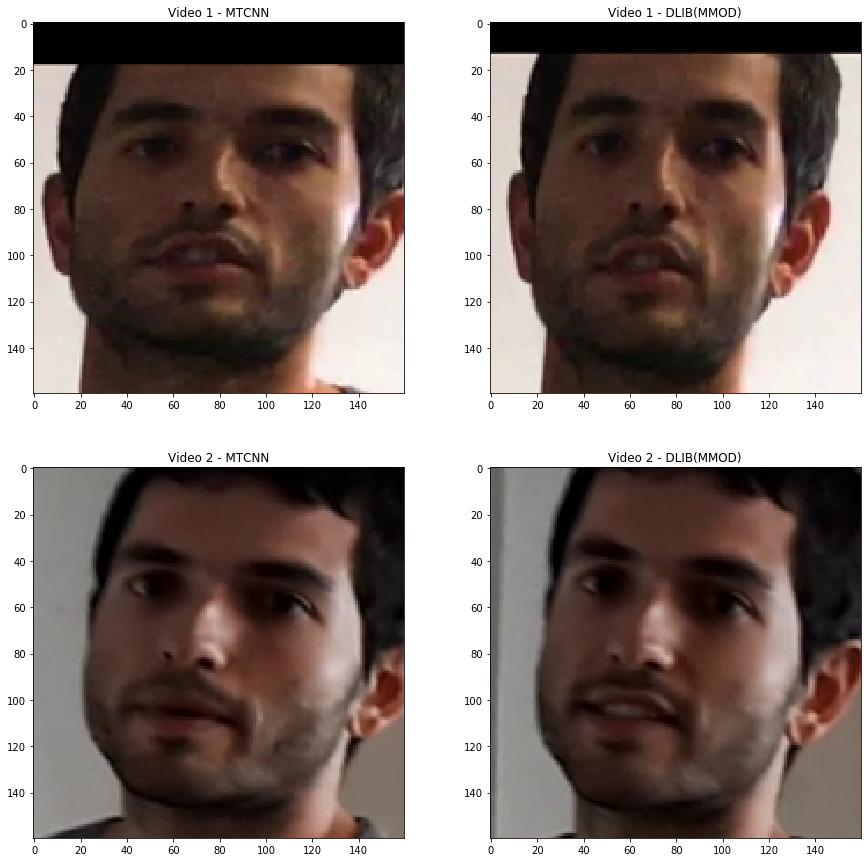

In [28]:
id_video_1 = 'averobot_floor_02-11_02_02_19_05/'
id_video_2 = 'averobot_floor_03-11_03_02_10_08/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=True,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=4,
                                                                               used_frames_detector_2=4,
                                                                               detector_1='mtcnn',
                                                                               detector_2='dlib_mmod')

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='dlib_mmod')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

frame_3 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][2])
face_cut_3 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_3 = [face['box'] for index, face in enumerate(face_cut_3) if face['frame_number'] == failed_frames_pairs[used_index][2]][0]
face_box_3[2] = face_box_3[0] + face_box_3[2]
face_box_3[3] = face_box_3[1] + face_box_3[3]
embedding_frame_3 = frame_3.crop(tuple(face_box_3)).resize([160, 160])

frame_4 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][3])
face_cut_4 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='dlib_mmod')
face_box_4 = [face['box'] for index, face in enumerate(face_cut_4) if face['frame_number'] == failed_frames_pairs[used_index][3]][0]
face_box_4[2] = face_box_4[0] + face_box_4[2]
face_box_4[3] = face_box_4[1] + face_box_4[3]
embedding_frame_4 = frame_4.crop(tuple(face_box_4)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(2,2,2)
plt.title("Video 1 - DLIB(MMOD)")
plt.imshow(embedding_frame_2)

plt.subplot(2,2,3)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_3)

plt.subplot(2,2,4)
plt.title("Video 2 - DLIB(MMOD)")
plt.imshow(embedding_frame_4)

##### 2.7.3.10 Visualización de pares de frames fallidos (Falso positivo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-153.jpg', 'frame-147.jpg', 'frame-179.jpg', 'frame-233.jpg')


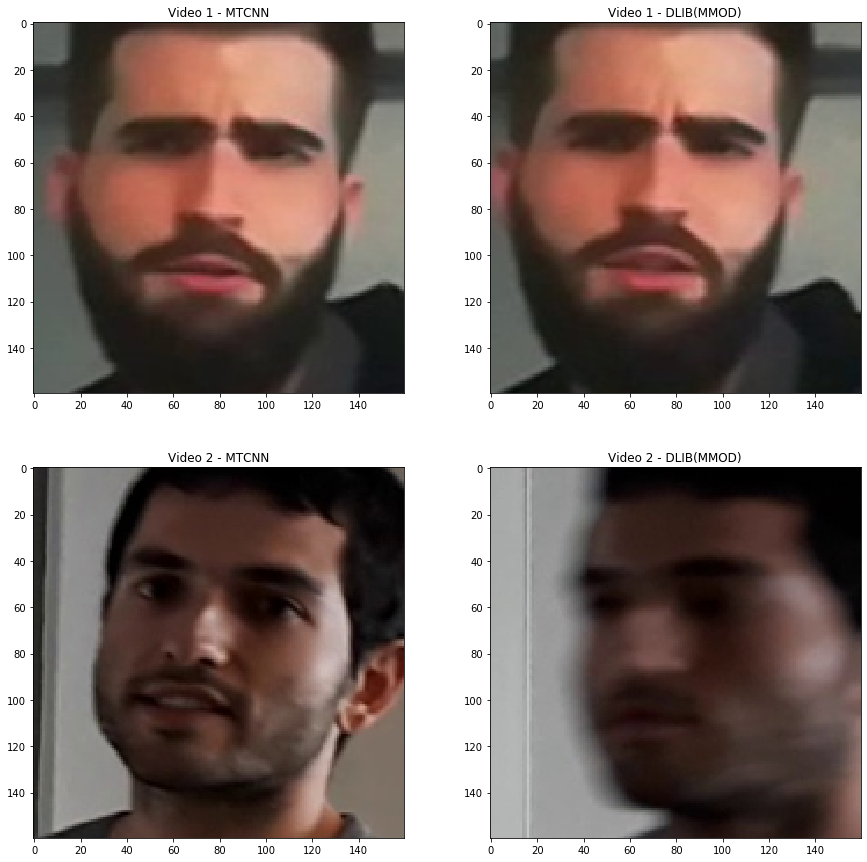

In [36]:
id_video_1 = 'averobot_floor_01-51_01_02_19_02/'
id_video_2 = 'averobot_floor_03-11_03_02_10_08/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=False,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=4,
                                                                               used_frames_detector_2=4,
                                                                               detector_1='mtcnn',
                                                                               detector_2='dlib_mmod')

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='dlib_mmod')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

frame_3 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][2])
face_cut_3 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_3 = [face['box'] for index, face in enumerate(face_cut_3) if face['frame_number'] == failed_frames_pairs[used_index][2]][0]
face_box_3[2] = face_box_3[0] + face_box_3[2]
face_box_3[3] = face_box_3[1] + face_box_3[3]
embedding_frame_3 = frame_3.crop(tuple(face_box_3)).resize([160, 160])

frame_4 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][3])
face_cut_4 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='dlib_mmod')
face_box_4 = [face['box'] for index, face in enumerate(face_cut_4) if face['frame_number'] == failed_frames_pairs[used_index][3]][0]
face_box_4[2] = face_box_4[0] + face_box_4[2]
face_box_4[3] = face_box_4[1] + face_box_4[3]
embedding_frame_4 = frame_4.crop(tuple(face_box_4)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(2,2,2)
plt.title("Video 1 - DLIB(MMOD)")
plt.imshow(embedding_frame_2)

plt.subplot(2,2,3)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_3)

plt.subplot(2,2,4)
plt.title("Video 2 - DLIB(MMOD)")
plt.imshow(embedding_frame_4)

#### 2.7.4 Uso del modelo de resta: 4 *embeddings* (2 por vídeo) aportados por dos detectores (*MTCNN* y *DLIB-MMOD*) restados entre sí (los 2 *embeddings* de una identidad menos los 2 *embeddings* de la otra) con valor absoluto en el resultado y usando un solo frame en cada detector

##### 2.7.4.1 Creación del verificador

In [2]:
nn_vf = nnverifier.NNVerifier(train_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-18_23-50-56-177873-new_detections_lift_place_2_5_8_train-data-resize.pickle'),
                              train_videos_embeddings_2=embeddings_assembler.load_panda_embeddings('2020-04-19_15-22-39-540389-lift_place_2_5_8_train-dlib-mmod-data.pickle'),
                              test_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-12_19-20-05-763843-new_detections_lift_place_2_5_8-data-resize.pickle'),
                              test_videos_embeddings_2=embeddings_assembler.load_panda_embeddings('2020-04-19_02-23-33-894032-lift_place_2_5_8-dlib-mmod-data.pickle'),
                              mlp_type='abs_subtract',
                              select_one_frame=True)

##### 2.7.4.2 Obtención de entradas para entrenamiento y test 

In [3]:
[same_person_embeddings_pairs_train, different_people_embeddings_pairs_train] = nn_vf.get_embeddings_pairs(pair_type='train')
[same_person_embeddings_pairs_test, different_people_embeddings_pairs_test] = nn_vf.get_embeddings_pairs(pair_type='test')

[Getting all possible pairs...]
[All pairs have been generated successfully (420 same person pairs & 28980 different people pairs)
[Getting all possible pairs...]
[All pairs have been generated successfully (246 same person pairs & 9840 different people pairs)


##### 2.7.4.3 Creación y entrenamiento de la red neuronal

In [78]:
nn_vf.create_mlp(print_summary=True)
nn_vf.train_model(same_person_embeddings_pairs_train, different_people_embeddings_pairs_train, batch_size=250, epochs=50)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 2048)              526336    
_________________________________________________________________
dropout_61 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_82 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_62 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_63 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_84 (Dense)             (None, 1)               

Epoch 49/50
672/672 [==============================] - 0s 58us/step - loss: 0.8333 - accuracy: 0.7426 - val_loss: 0.2064 - val_accuracy: 0.9345
Epoch 50/50
672/672 [==============================] - 0s 55us/step - loss: 0.0945 - accuracy: 0.9926 - val_loss: 0.2409 - val_accuracy: 0.8988


##### 2.7.4.4 Guardado de la red neuronal

In [166]:
nn_vf.save_model('abs_subtract_of')

##### 2.7.4.5 Carga de la red neuronal

In [3]:
nn_vf.load_model('2020-04-27_02-10-09-053532-abs_subtract_of.h5')

##### 2.7.4.6 *Accuracy*  y *Loss* del conjunto de test

In [97]:
nn_vf.evaluate(same_person_embeddings_pairs_test, different_people_embeddings_pairs_test)

492/492 [==============================] - 0s 75us/step
Accuracy: 0.9 | Loss: 0.264


##### 2.7.4.7 Calidad de la red neuronal (Mediante `utils.nn_verifier_metrics_plotter`)

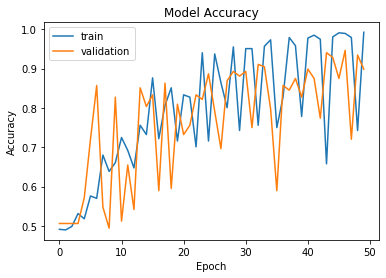

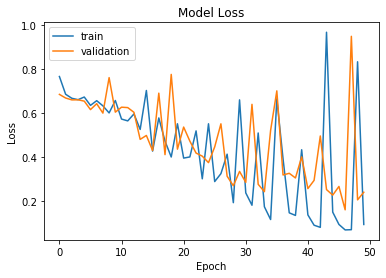

In [98]:
nn_vf_mp = nn_verifier_metrics_plotter.NNVerifierMetricsPlotter(nn_vf.history)

nn_vf_mp.plot_accuracy()
nn_vf_mp.plot_loss()

##### 2.7.4.8 Varios test de funcionamiento de la verificación

Se cargan pares de ids de vídeos de la misma persona y de diferente persona para las pruebas. Estos pares proceden del conjunto de test (ya que se considera el método fundamental de la aplicación final).

In [5]:
same_person_videos_id_pairs_list = accuracy_meter.get_same_person_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
different_person_videos_id_pairs_list = accuracy_meter.get_different_people_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list.sort()
different_person_videos_id_pairs_list.sort()
random.shuffle(same_person_videos_id_pairs_list)
random.shuffle(different_person_videos_id_pairs_list)

In [27]:
sp_vipl_copy = same_person_videos_id_pairs_list.copy()
dp_vipl_copy = different_person_videos_id_pairs_list.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_01-88_01_02_08_02/ VS averobot_floor_03-88_03_02_32_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-01_02_02_25_05/ VS averobot_floor_03-01_03_02_05_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-26_01_02_28_02/ VS averobot_floor_03-26_03_02_15_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-48_01_02_04_02/ VS averobot_floor_03-48_03_02_25_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-11_01_02_01_02/ VS averobot_floor_03-11_03_02_10_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-105_02_02_22_05/ VS averobot_floor_03-105_03_02_29_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-108_01_02_05_02/ VS averobot_floor_02-108_02_02_28_05/:	{'is_same_person': False, 'confidence': 1.0}]
[averobot_floor_01-73_01_02_14_02/ VS averobot_floor_02-73_02_02_25_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-15_01_02_13_

##### 2.7.4.9 Visualización de pares de frames fallidos (Falso negativo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-021.jpg', 'frame-073.jpg', 'frame-194.jpg', 'frame-209.jpg')


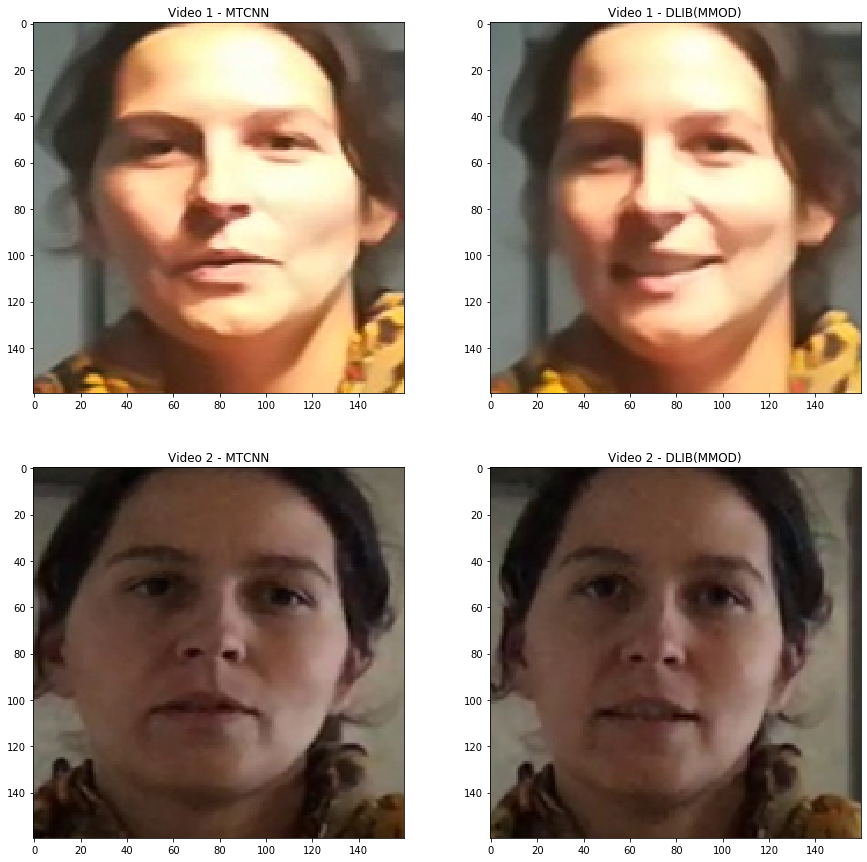

In [31]:
id_video_1 = 'averobot_floor_01-108_01_02_05_02/'
id_video_2 = 'averobot_floor_02-108_02_02_28_05/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=True,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=1,
                                                                               used_frames_detector_2=1,
                                                                               detector_1='mtcnn',
                                                                               detector_2='dlib_mmod')

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='dlib_mmod')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

frame_3 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][2])
face_cut_3 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_3 = [face['box'] for index, face in enumerate(face_cut_3) if face['frame_number'] == failed_frames_pairs[used_index][2]][0]
face_box_3[2] = face_box_3[0] + face_box_3[2]
face_box_3[3] = face_box_3[1] + face_box_3[3]
embedding_frame_3 = frame_3.crop(tuple(face_box_3)).resize([160, 160])

frame_4 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][3])
face_cut_4 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='dlib_mmod')
face_box_4 = [face['box'] for index, face in enumerate(face_cut_4) if face['frame_number'] == failed_frames_pairs[used_index][3]][0]
face_box_4[2] = face_box_4[0] + face_box_4[2]
face_box_4[3] = face_box_4[1] + face_box_4[3]
embedding_frame_4 = frame_4.crop(tuple(face_box_4)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(2,2,2)
plt.title("Video 1 - DLIB(MMOD)")
plt.imshow(embedding_frame_2)

plt.subplot(2,2,3)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_3)

plt.subplot(2,2,4)
plt.title("Video 2 - DLIB(MMOD)")
plt.imshow(embedding_frame_4)

##### 2.7.4.10 Visualización de pares de frames fallidos (Falso positivo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-196.jpg', 'frame-200.jpg', 'frame-109.jpg', 'frame-083.jpg')


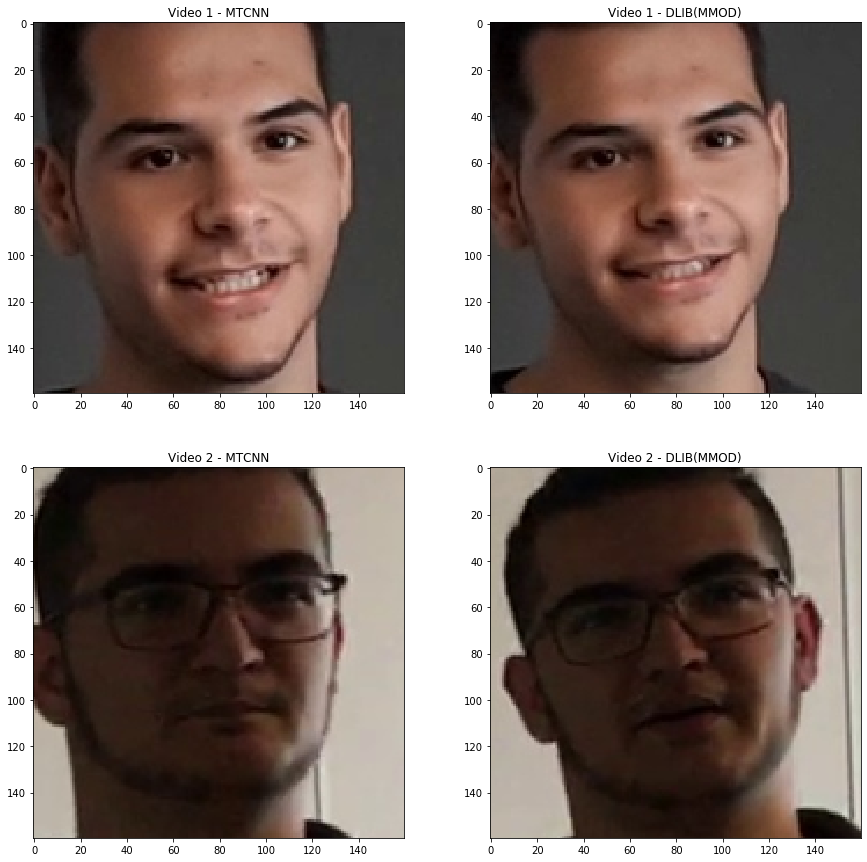

In [30]:
id_video_1 = 'averobot_floor_03-37_03_02_06_08/'
id_video_2 = 'averobot_floor_02-101_02_02_08_05/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=False,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=1,
                                                                               used_frames_detector_2=1,
                                                                               detector_1='mtcnn',
                                                                               detector_2='dlib_mmod')

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='dlib_mmod')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

frame_3 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][2])
face_cut_3 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_3 = [face['box'] for index, face in enumerate(face_cut_3) if face['frame_number'] == failed_frames_pairs[used_index][2]][0]
face_box_3[2] = face_box_3[0] + face_box_3[2]
face_box_3[3] = face_box_3[1] + face_box_3[3]
embedding_frame_3 = frame_3.crop(tuple(face_box_3)).resize([160, 160])

frame_4 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][3])
face_cut_4 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='dlib_mmod')
face_box_4 = [face['box'] for index, face in enumerate(face_cut_4) if face['frame_number'] == failed_frames_pairs[used_index][3]][0]
face_box_4[2] = face_box_4[0] + face_box_4[2]
face_box_4[3] = face_box_4[1] + face_box_4[3]
embedding_frame_4 = frame_4.crop(tuple(face_box_4)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(2,2,2)
plt.title("Video 1 - DLIB(MMOD)")
plt.imshow(embedding_frame_2)

plt.subplot(2,2,3)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_3)

plt.subplot(2,2,4)
plt.title("Video 2 - DLIB(MMOD)")
plt.imshow(embedding_frame_4)

#### 2.7.5 Uso del modelo de resta: 2 *embeddings* (1 por vídeo) aportados por un detector (*MTCNN*) restados entre sí (el *embedding* de una identidad menos el *embedding* de la otra) con valor absoluto en el resultado

##### 2.7.5.1 Creación del verificador

In [2]:
nn_vf = nnverifier.NNVerifier(train_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-18_23-50-56-177873-new_detections_lift_place_2_5_8_train-data-resize.pickle'),
                              test_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-12_19-20-05-763843-new_detections_lift_place_2_5_8-data-resize.pickle'),
                              mlp_type='abs_subtract',
                              use_one_detector=True)

##### 2.7.5.2 Obtención de entradas para entrenamiento y test 

In [3]:
[same_person_embeddings_pairs_train, different_people_embeddings_pairs_train] = nn_vf.get_embeddings_pairs(pair_type='train')
[same_person_embeddings_pairs_test, different_people_embeddings_pairs_test] = nn_vf.get_embeddings_pairs(pair_type='test')

[Getting all possible pairs...]
[All pairs have been generated successfully (6720 same person pairs & 463680 different people pairs)
[Getting all possible pairs...]
[All pairs have been generated successfully (3936 same person pairs & 157440 different people pairs)


##### 2.7.5.3 Creación y entrenamiento de la red neuronal

In [76]:
nn_vf.create_mlp(print_summary=True)
nn_vf.train_model(same_person_embeddings_pairs_train, different_people_embeddings_pairs_train, batch_size=2500, epochs=50)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 2048)              264192    
_________________________________________________________________
dropout_52 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_70 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_53 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_54 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 1)               

##### 2.7.5.4 Guardado de la red neuronal

In [85]:
nn_vf.save_model('abs_subtract_od')

##### 2.7.5.5 Carga de la red neuronal

In [3]:
nn_vf.load_model('2020-05-03_17-10-32-426851-abs_subtract_od.h5')

##### 2.7.5.6 *Accuracy*  y *Loss* del conjunto de test

In [84]:
nn_vf.evaluate(same_person_embeddings_pairs_test, different_people_embeddings_pairs_test)

7872/7872 [==============================] - 0s 51us/step
Accuracy: 0.928 | Loss: 0.206


##### 2.7.5.7 Calidad de la red neuronal (Mediante `utils.nn_verifier_metrics_plotter`)

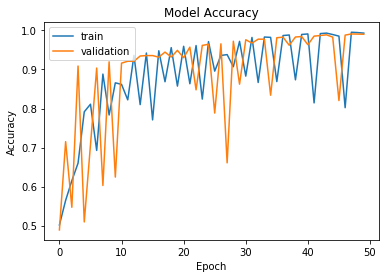

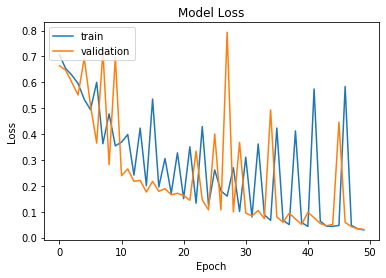

In [86]:
nn_vf_mp = nn_verifier_metrics_plotter.NNVerifierMetricsPlotter(nn_vf.history)

nn_vf_mp.plot_accuracy()
nn_vf_mp.plot_loss()

##### 2.7.5.8 Varios test de funcionamiento de la verificación

Se cargan pares de ids de vídeos de la misma persona y de diferente persona para las pruebas. Estos pares proceden del conjunto de test (ya que se considera el método fundamental de la aplicación final).

In [4]:
same_person_videos_id_pairs_list = accuracy_meter.get_same_person_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
different_person_videos_id_pairs_list = accuracy_meter.get_different_people_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list.sort()
different_person_videos_id_pairs_list.sort()
random.shuffle(same_person_videos_id_pairs_list)
random.shuffle(different_person_videos_id_pairs_list)

In [98]:
sp_vipl_copy = same_person_videos_id_pairs_list.copy()
dp_vipl_copy = different_person_videos_id_pairs_list.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_01-48_01_02_04_02/ VS averobot_floor_02-48_02_02_05_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-73_01_02_14_02/ VS averobot_floor_03-73_03_02_33_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-09_02_02_33_05/ VS averobot_floor_03-09_03_02_32_08/:	{'is_same_person': False, 'confidence': 0.75}]
[averobot_floor_02-26_02_02_32_05/ VS averobot_floor_03-26_03_02_15_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-01_01_02_01_02/ VS averobot_floor_02-01_02_02_25_05/:	{'is_same_person': False, 'confidence': 1.0}]
[averobot_floor_02-88_02_02_27_05/ VS averobot_floor_03-88_03_02_32_08/:	{'is_same_person': True, 'confidence': 0.75}]
[averobot_floor_01-104_01_02_08_02/ VS averobot_floor_03-104_03_02_20_08/:	{'is_same_person': True, 'confidence': 0.938}]
[averobot_floor_01-51_01_02_19_02/ VS averobot_floor_03-51_03_02_25_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-99_01_02_

##### 2.7.5.9 Visualización de pares de frames fallidos (Falso negativo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-144.jpg', 'frame-1251.jpg')


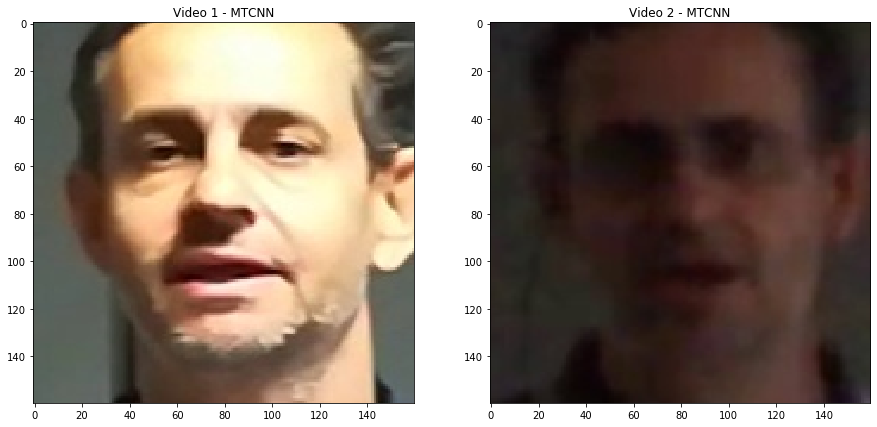

In [100]:
id_video_1 = 'averobot_floor_01-01_01_02_01_02/'
id_video_2 = 'averobot_floor_02-01_02_02_25_05/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=True,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=4,
                                                                               detector_1='mtcnn',
                                                                               use_one_detector=True)

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(1,2,2)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_2)

##### 2.7.5.10 Visualización de pares de frames fallidos (Falso positivo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-116.jpg', 'frame-109.jpg')


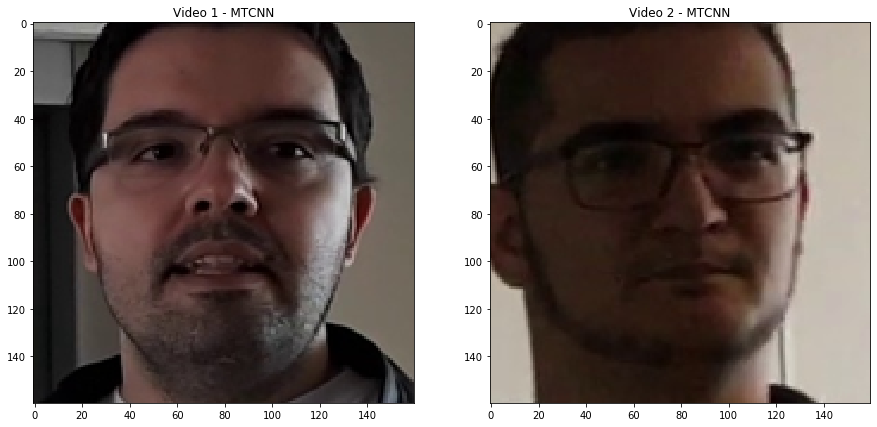

In [101]:
id_video_1 = 'averobot_floor_03-90_03_02_11_08/'
id_video_2 = 'averobot_floor_02-101_02_02_08_05/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=False,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=4,
                                                                               detector_1='mtcnn',
                                                                               use_one_detector=True)

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(1,2,2)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_2)

#### 2.7.6 Uso del modelo de resta: 2 *embeddings* (1 por vídeo) aportados por un detector (*MTCNN*) restados entre sí (el *embedding* de una identidad menos el *embedding* de la otra) con valor absoluto en el resultado usando el *Teorema de Kolmogorov*

##### 2.7.6.1 Creación del verificador

In [2]:
nn_vf = nnverifier.NNVerifier(train_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-18_23-50-56-177873-new_detections_lift_place_2_5_8_train-data-resize.pickle'),
                              test_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-12_19-20-05-763843-new_detections_lift_place_2_5_8-data-resize.pickle'),
                              mlp_type='abs_subtract',
                              use_one_detector=True,
                              use_kolmogorov_theorem=True)

##### 2.7.6.2 Obtención de entradas para entrenamiento y test 

In [3]:
[same_person_embeddings_pairs_train, different_people_embeddings_pairs_train] = nn_vf.get_embeddings_pairs(pair_type='train')
[same_person_embeddings_pairs_test, different_people_embeddings_pairs_test] = nn_vf.get_embeddings_pairs(pair_type='test')

[Getting all possible pairs...]
[All pairs have been generated successfully (6720 same person pairs & 463680 different people pairs)
[Getting all possible pairs...]
[All pairs have been generated successfully (3936 same person pairs & 157440 different people pairs)


##### 2.7.6.3 Creación y entrenamiento de la red neuronal

In [4]:
nn_vf.create_mlp(print_summary=True)
nn_vf.train_model(same_person_embeddings_pairs_train, different_people_embeddings_pairs_train, batch_size=2500, epochs=75)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 257)               33153     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 258       
Total params: 49,923
Trainable params: 49,923
Non-trainable params: 0
_________________________________________________________________
Train on 10752 samples, validate on 2688 samples
Epoch 1/75
10752/10752 [==============================] - 1s 106us/step - loss: 0.6713 - accuracy: 0.5011 - val_loss: 0.6428 - val_accuracy: 0.4896
Epoch 2/75
10752/10752 [==============================] - 0s 4us/step - loss: 0.6228 - accuracy: 0.5592 - val_loss: 0.6077 - val_accuracy: 0.5011
Epoch 3/75
10752/10752 [=============

##### 2.7.6.4 Guardado de la red neuronal

In [18]:
nn_vf.save_model('abs_subtract_od_kolmogorov')

##### 2.7.6.5 Carga de la red neuronal

In [5]:
nn_vf.load_model('2020-05-03_17-37-58-931163-abs_subtract_od_kolmogorov.h5')

##### 2.7.6.6 *Accuracy*  y *Loss* del conjunto de test

In [16]:
nn_vf.evaluate(same_person_embeddings_pairs_test, different_people_embeddings_pairs_test)

7872/7872 [==============================] - 0s 49us/step
Accuracy: 0.933 | Loss: 0.183


##### 2.7.6.7 Calidad de la red neuronal (Mediante `utils.nn_verifier_metrics_plotter`)

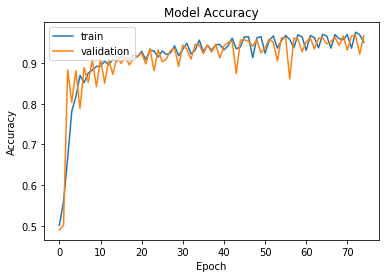

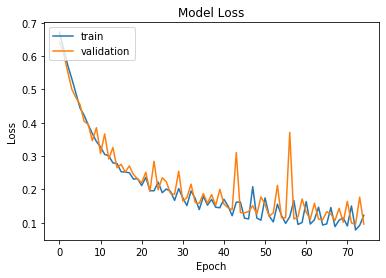

In [17]:
nn_vf_mp = nn_verifier_metrics_plotter.NNVerifierMetricsPlotter(nn_vf.history)

nn_vf_mp.plot_accuracy()
nn_vf_mp.plot_loss()

##### 2.7.6.8 Varios test de funcionamiento de la verificación

Se cargan pares de ids de vídeos de la misma persona y de diferente persona para las pruebas. Estos pares proceden del conjunto de test (ya que se considera el método fundamental de la aplicación final).

In [20]:
same_person_videos_id_pairs_list = accuracy_meter.get_same_person_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
different_person_videos_id_pairs_list = accuracy_meter.get_different_people_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list.sort()
different_person_videos_id_pairs_list.sort()
random.shuffle(same_person_videos_id_pairs_list)
random.shuffle(different_person_videos_id_pairs_list)

In [41]:
sp_vipl_copy = same_person_videos_id_pairs_list.copy()
dp_vipl_copy = different_person_videos_id_pairs_list.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_02-42_02_02_19_05/ VS averobot_floor_03-42_03_02_30_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-09_01_02_26_02/ VS averobot_floor_02-09_02_02_33_05/:	{'is_same_person': False, 'confidence': 0.688}]
[averobot_floor_02-08_02_02_10_05/ VS averobot_floor_03-08_03_02_27_08/:	{'is_same_person': True, 'confidence': 0.688}]
[averobot_floor_01-32_01_02_01_02/ VS averobot_floor_03-32_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-09_02_02_33_05/ VS averobot_floor_03-09_03_02_32_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-89_02_02_27_05/ VS averobot_floor_03-89_03_02_32_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-88_01_02_08_02/ VS averobot_floor_02-88_02_02_27_05/:	{'is_same_person': True, 'confidence': 0.75}]
[averobot_floor_01-110_01_02_08_02/ VS averobot_floor_03-110_03_02_03_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-86_01_02_

##### 2.7.6.9 Visualización de pares de frames fallidos (Falso negativo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-162.jpg', 'frame-1998.jpg')


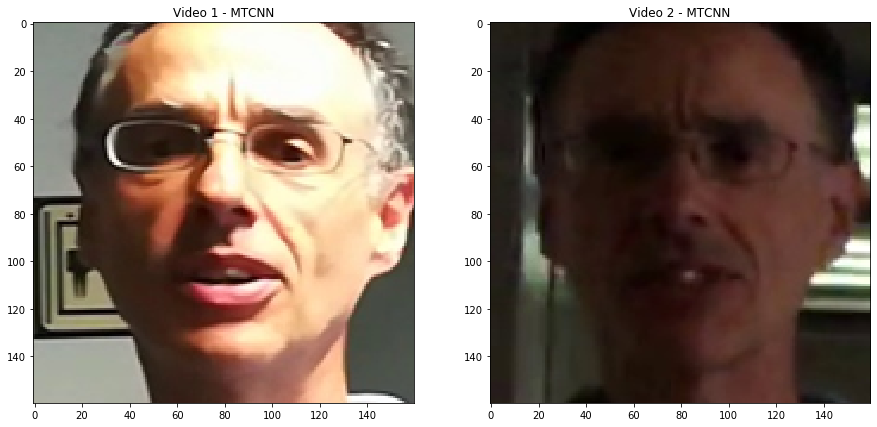

In [42]:
id_video_1 = 'averobot_floor_01-09_01_02_26_02/'
id_video_2 = 'averobot_floor_02-09_02_02_33_05/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=True,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=4,
                                                                               detector_1='mtcnn',
                                                                               use_one_detector=True)

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(1,2,2)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_2)

##### 2.7.6.10 Visualización de pares de frames fallidos (Falso positivo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-364.jpg', 'frame-071.jpg')


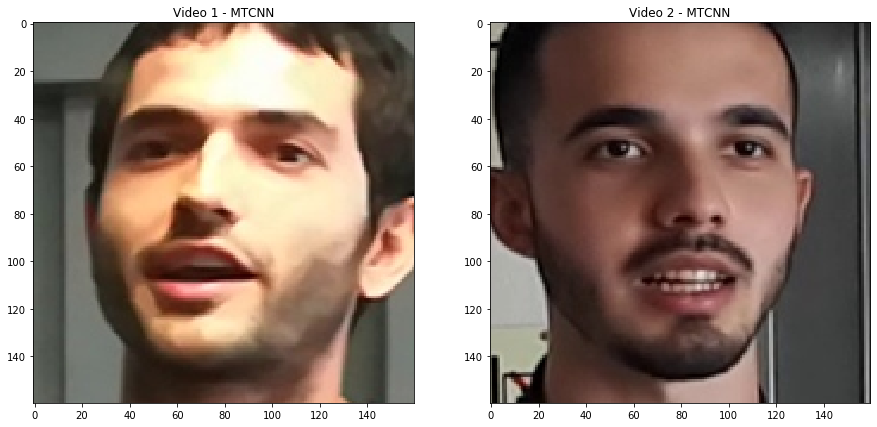

In [43]:
id_video_1 = 'averobot_floor_01-11_01_02_01_02/'
id_video_2 = 'averobot_floor_03-99_03_02_11_08/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=False,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=4,
                                                                               detector_1='mtcnn',
                                                                               use_one_detector=True)

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(1,2,2)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_2)

#### 2.7.7 Uso del modelo de resta: 2 *embeddings* (1 por vídeo) aportados por un detector (*MTCNN*) restados entre sí (el *embedding* de una identidad menos el *embedding* de la otra) con valor absoluto en el resultado usando el *Teorema de Kolmogorov* y la distancia euclídea entre ambos *embeddings* como nueva entrada

##### 2.7.7.1 Creación del verificador

In [2]:
nn_vf = nnverifier.NNVerifier(train_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-18_23-50-56-177873-new_detections_lift_place_2_5_8_train-data-resize.pickle'),
                              test_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-12_19-20-05-763843-new_detections_lift_place_2_5_8-data-resize.pickle'),
                              mlp_type='abs_subtract',
                              use_one_detector=True,
                              use_kolmogorov_theorem=True,  # It is always used in euclidean distance model
                              use_euclidean_distance=True)

##### 2.7.7.2 Obtención de entradas para entrenamiento y test 

In [3]:
[same_person_embeddings_pairs_train, different_people_embeddings_pairs_train, same_person_ed_train, different_people_ed_train] = nn_vf.get_embeddings_pairs(pair_type='train')
[same_person_embeddings_pairs_test, different_people_embeddings_pairs_test, same_person_ed_test, different_people_ed_test] = nn_vf.get_embeddings_pairs(pair_type='test')

[Getting all possible pairs...]
[All pairs have been generated successfully (6720 same person pairs & 463680 different people pairs)
[Getting all possible pairs...]
[All pairs have been generated successfully (3936 same person pairs & 157440 different people pairs)


##### 2.7.7.3 Creación y entrenamiento de la red neuronal

In [157]:
nn_vf.create_mlp(print_summary=True)
nn_vf.train_model(same_person_embeddings_pairs_train, different_people_embeddings_pairs_train, batch_size=1000, epochs=50,
                  same_person_ed=same_person_ed_train, different_people_ed=different_people_ed_train)

Model: "model_54"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
dense_160 (Dense)               (None, 128)          16512       input_54[0][0]                   
__________________________________________________________________________________________________
euclidean_distance (InputLayer) (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_54 (Concatenate)    (None, 129)          0           dense_160[0][0]                  
                                                                 euclidean_distance[0][0]  

##### 2.7.7.4 Guardado de la red neuronal

In [165]:
nn_vf.save_model('abs_subtract_od_kolmogorov_ed')

##### 2.7.7.5 Carga de la red neuronal

In [5]:
nn_vf.load_model('2020-05-03_20-51-19-042793-abs_subtract_od_kolmogorov_ed.h5')

##### 2.7.7.6 *Accuracy*  y *Loss* del conjunto de test

In [164]:
nn_vf.evaluate(same_person_embeddings_pairs_test, different_people_embeddings_pairs_test,
               same_person_ed=same_person_ed_test, different_people_ed=different_people_ed_test)

7872/7872 [==============================] - 1s 77us/step
Accuracy: 0.882 | Loss: 0.417


##### 2.7.7.7 Calidad de la red neuronal (Mediante `utils.nn_verifier_metrics_plotter`)

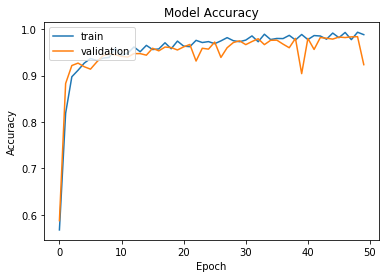

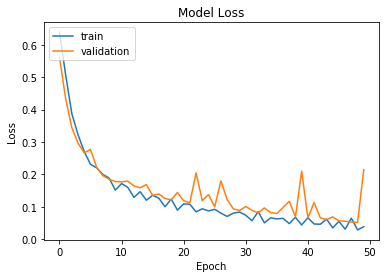

In [166]:
nn_vf_mp = nn_verifier_metrics_plotter.NNVerifierMetricsPlotter(nn_vf.history)

nn_vf_mp.plot_accuracy()
nn_vf_mp.plot_loss()

##### 2.7.7.8 Varios test de funcionamiento de la verificación

Se cargan pares de ids de vídeos de la misma persona y de diferente persona para las pruebas. Estos pares proceden del conjunto de test (ya que se considera el método fundamental de la aplicación final).

In [5]:
same_person_videos_id_pairs_list = accuracy_meter.get_same_person_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
different_person_videos_id_pairs_list = accuracy_meter.get_different_people_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list.sort()
different_person_videos_id_pairs_list.sort()
random.shuffle(same_person_videos_id_pairs_list)
random.shuffle(different_person_videos_id_pairs_list)

In [23]:
sp_vipl_copy = same_person_videos_id_pairs_list.copy()
dp_vipl_copy = different_person_videos_id_pairs_list.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_02-96_02_02_29_05/ VS averobot_floor_03-96_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-08_02_02_10_05/ VS averobot_floor_03-08_03_02_27_08/:	{'is_same_person': True, 'confidence': 0.75}]
[averobot_floor_01-16_01_02_01_02/ VS averobot_floor_03-16_03_02_32_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-92_01_02_01_02/ VS averobot_floor_03-92_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-01_02_02_25_05/ VS averobot_floor_03-01_03_02_05_08/:	{'is_same_person': False, 'confidence': 0.812}]
[averobot_floor_01-42_01_02_01_02/ VS averobot_floor_03-42_03_02_30_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-26_01_02_28_02/ VS averobot_floor_03-26_03_02_15_08/:	{'is_same_person': False, 'confidence': 0.625}]
[averobot_floor_02-110_02_02_13_05/ VS averobot_floor_03-110_03_02_03_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-99_02_02

##### 2.7.7.9 Visualización de pares de frames fallidos (Falso negativo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-091.jpg', 'frame-141.jpg')


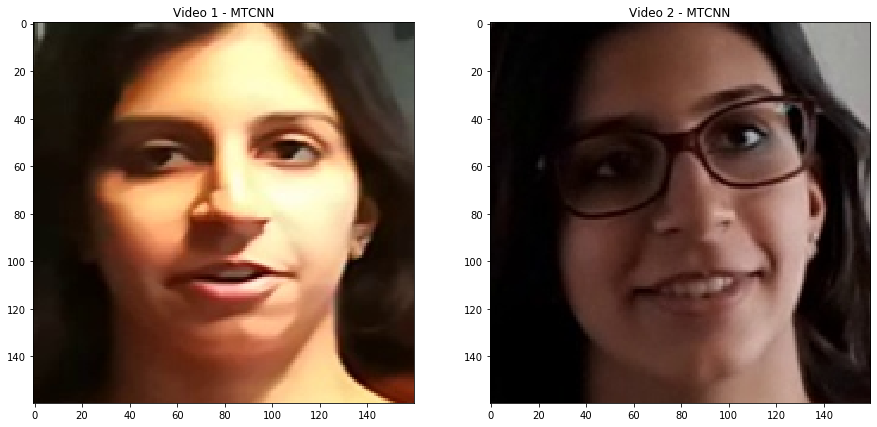

In [26]:
id_video_1 = 'averobot_floor_01-26_01_02_28_02/'
id_video_2 = 'averobot_floor_03-26_03_02_15_08/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=True,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=4,
                                                                               detector_1='mtcnn',
                                                                               use_one_detector=True,
                                                                               use_euclidean_distances=True)

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(1,2,2)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_2)

##### 2.7.7.10 Visualización de pares de frames fallidos (Falso positivo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-142.jpg', 'frame-179.jpg')


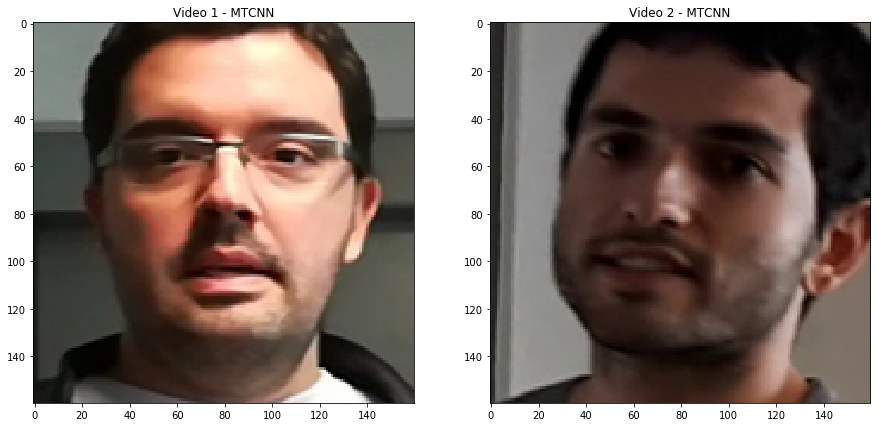

In [24]:
id_video_1 = 'averobot_floor_01-90_01_02_01_02/'
id_video_2 = 'averobot_floor_03-11_03_02_10_08/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=False,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=4,
                                                                               detector_1='mtcnn',
                                                                               use_one_detector=True,
                                                                               use_euclidean_distances=True)

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(1,2,2)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_2)

#### 2.7.8 Uso del modelo de resta: 2 *embeddings* (1 por vídeo) aportados por un detector (*MTCNN*) restados entre sí (el *embedding* de una identidad menos el *embedding* de la otra) con valor absoluto en el resultado usando el *Teorema de Kolmogorov* alterado y la distancia euclídea entre ambos *embeddings* como nueva entrada

##### 2.7.8.1 Creación del verificador

In [2]:
nn_vf = nnverifier.NNVerifier(train_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-18_23-50-56-177873-new_detections_lift_place_2_5_8_train-data-resize.pickle'),
                              test_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-12_19-20-05-763843-new_detections_lift_place_2_5_8-data-resize.pickle'),
                              mlp_type='abs_subtract',
                              use_one_detector=True,
                              use_kolmogorov_theorem=True,  # It is always used in euclidean distance model
                              use_euclidean_distance=True)

##### 2.7.8.2 Obtención de entradas para entrenamiento y test 

In [3]:
[same_person_embeddings_pairs_train, different_people_embeddings_pairs_train, same_person_ed_train, different_people_ed_train] = nn_vf.get_embeddings_pairs(pair_type='train')
[same_person_embeddings_pairs_test, different_people_embeddings_pairs_test, same_person_ed_test, different_people_ed_test] = nn_vf.get_embeddings_pairs(pair_type='test')

[Getting all possible pairs...]
[All pairs have been generated successfully (6720 same person pairs & 463680 different people pairs)
[Getting all possible pairs...]
[All pairs have been generated successfully (3936 same person pairs & 157440 different people pairs)


##### 2.7.8.3 Creación y entrenamiento de la red neuronal

In [47]:
nn_vf.create_mlp(print_summary=True)
nn_vf.train_model(same_person_embeddings_pairs_train, different_people_embeddings_pairs_train, batch_size=3500, epochs=50,
                  same_person_ed=same_person_ed_train, different_people_ed=different_people_ed_train)

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
dense_64 (Dense)                (None, 128)          16512       input_22[0][0]                   
__________________________________________________________________________________________________
dense_65 (Dense)                (None, 64)           8256        dense_64[0][0]                   
__________________________________________________________________________________________________
euclidean_distance (InputLayer) (None, 1)            0                                            
___________________________________________________________________________________________

##### 2.7.8.4 Guardado de la red neuronal

In [88]:
nn_vf.save_model('abs_subtract_od_altered_kolmogorov_ed')

##### 2.7.8.5 Carga de la red neuronal

In [5]:
nn_vf.load_model('2020-05-10_03-04-15-597677-abs_subtract_od_altered_kolmogorov_ed.h5')

##### 2.7.8.6 *Accuracy*  y *Loss* del conjunto de test

In [87]:
nn_vf.evaluate(same_person_embeddings_pairs_test, different_people_embeddings_pairs_test,
               same_person_ed=same_person_ed_test, different_people_ed=different_people_ed_test)

7872/7872 [==============================] - 0s 61us/step
Accuracy: 0.868 | Loss: 0.342


##### 2.7.8.7 Calidad de la red neuronal (Mediante `utils.nn_verifier_metrics_plotter`)

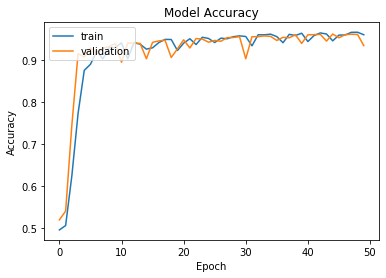

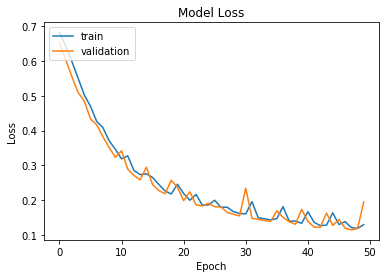

In [89]:
nn_vf_mp = nn_verifier_metrics_plotter.NNVerifierMetricsPlotter(nn_vf.history)

nn_vf_mp.plot_accuracy()
nn_vf_mp.plot_loss()

##### 2.7.8.8 Varios test de funcionamiento de la verificación

Se cargan pares de ids de vídeos de la misma persona y de diferente persona para las pruebas. Estos pares proceden del conjunto de test (ya que se considera el método fundamental de la aplicación final).

In [91]:
same_person_videos_id_pairs_list = accuracy_meter.get_same_person_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
different_person_videos_id_pairs_list = accuracy_meter.get_different_people_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list.sort()
different_person_videos_id_pairs_list.sort()
random.shuffle(same_person_videos_id_pairs_list)
random.shuffle(different_person_videos_id_pairs_list)

In [134]:
sp_vipl_copy = same_person_videos_id_pairs_list.copy()
dp_vipl_copy = different_person_videos_id_pairs_list.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_01-108_01_02_05_02/ VS averobot_floor_02-108_02_02_28_05/:	{'is_same_person': True, 'confidence': 0.625}]
[averobot_floor_02-101_02_02_08_05/ VS averobot_floor_03-101_03_02_10_08/:	{'is_same_person': True, 'confidence': 0.875}]
[averobot_floor_01-32_01_02_01_02/ VS averobot_floor_03-32_03_02_18_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-38_01_02_01_02/ VS averobot_floor_03-38_03_02_14_08/:	{'is_same_person': False, 'confidence': 1.0}]
[averobot_floor_02-80_02_02_27_05/ VS averobot_floor_03-80_03_02_30_08/:	{'is_same_person': False, 'confidence': 1.0}]
[averobot_floor_01-35_01_02_14_02/ VS averobot_floor_03-35_03_02_13_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-59_02_02_10_05/ VS averobot_floor_03-59_03_02_11_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-49_01_02_08_02/ VS averobot_floor_02-49_02_02_25_05/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-83_01_0

##### 2.7.8.9 Visualización de pares de frames fallidos (Falso negativo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-256.jpg', 'frame-062.jpg')


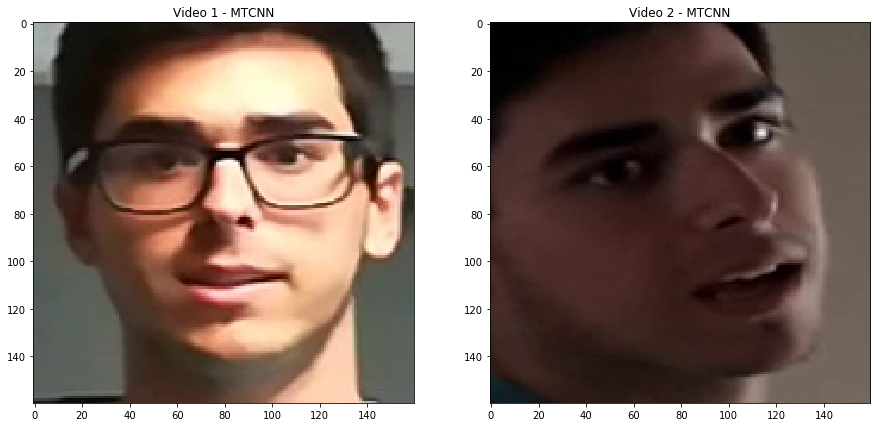

In [138]:
id_video_1 = 'averobot_floor_01-38_01_02_01_02/'
id_video_2 = 'averobot_floor_03-38_03_02_14_08/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=True,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=4,
                                                                               detector_1='mtcnn',
                                                                               use_one_detector=True,
                                                                               use_euclidean_distances=True)

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(1,2,2)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_2)

##### 2.7.8.10 Visualización de pares de frames fallidos (Falso positivo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-078.jpg', 'frame-130.jpg')


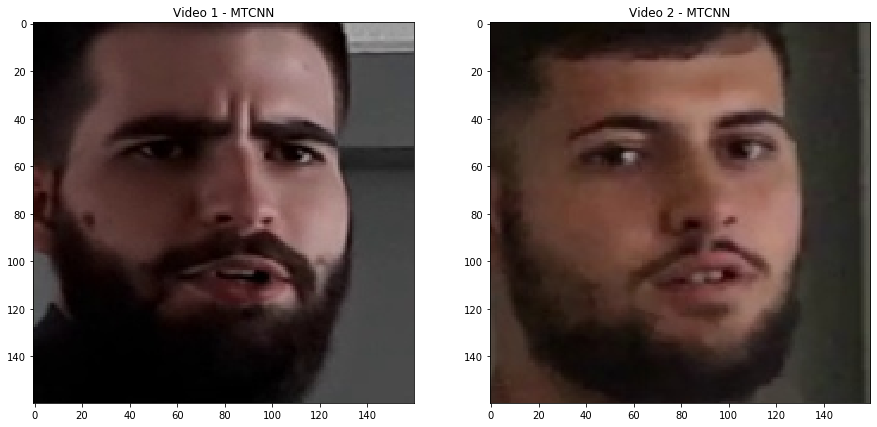

In [135]:
id_video_1 = 'averobot_floor_03-51_03_02_25_08/'
id_video_2 = 'averobot_floor_02-52_02_02_30_05/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=False,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=4,
                                                                               detector_1='mtcnn',
                                                                               use_one_detector=True,
                                                                               use_euclidean_distances=True)

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(1,2,2)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_2)

#### 2.7.9 Uso del modelo de resta: 2 *embeddings* (1 por vídeo) aportados por un detector (*MTCNN*) restados entre sí (el *embedding* de una identidad menos el *embedding* de la otra) con valor absoluto en el resultado usando el *Teorema de Kolmogorov* y manteniendo los 2 *embeddings* originales

##### 2.7.9.1 Creación del verificador

In [2]:
nn_vf = nnverifier.NNVerifier(train_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-18_23-50-56-177873-new_detections_lift_place_2_5_8_train-data-resize.pickle'),
                              test_videos_embeddings_1=embeddings_assembler.load_panda_embeddings('2020-04-12_19-20-05-763843-new_detections_lift_place_2_5_8-data-resize.pickle'),
                              mlp_type='abs_subtract_keep',
                              use_one_detector=True,
                              use_kolmogorov_theorem=True)

##### 2.7.9.2 Obtención de entradas para entrenamiento y test 

In [3]:
[same_person_embeddings_pairs_train, different_people_embeddings_pairs_train] = nn_vf.get_embeddings_pairs(pair_type='train')
[same_person_embeddings_pairs_test, different_people_embeddings_pairs_test] = nn_vf.get_embeddings_pairs(pair_type='test')

[Getting all possible pairs...]
[All pairs have been generated successfully (6720 same person pairs & 463680 different people pairs)
[Getting all possible pairs...]
[All pairs have been generated successfully (3936 same person pairs & 157440 different people pairs)


##### 2.7.9.3 Creación y entrenamiento de la red neuronal

In [57]:
nn_vf.create_mlp(print_summary=True)
nn_vf.train_model(same_person_embeddings_pairs_train, different_people_embeddings_pairs_train, batch_size=2500, epochs=30)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 384)               147840    
_________________________________________________________________
dense_47 (Dense)             (None, 769)               296065    
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 770       
Total params: 444,675
Trainable params: 444,675
Non-trainable params: 0
_________________________________________________________________
Train on 10752 samples, validate on 2688 samples
Epoch 1/30
10752/10752 [==============================] - 0s 41us/step - loss: 0.6723 - accuracy: 0.5317 - val_loss: 0.5642 - val_accuracy: 0.6797
Epoch 2/30
10752/10752 [==============================] - 0s 12us/step - loss: 0.5741 - accuracy: 0.6634 - val_loss: 0.4416 - val_accuracy: 0.8984
Epoch 3/30
10752/10752 [==========

##### 2.7.9.4 Guardado de la red neuronal

In [72]:
nn_vf.save_model('abs_subtract_od_kolmogorov_keep')

##### 2.7.9.5 Carga de la red neuronal

In [4]:
nn_vf.load_model('2020-05-04_00-34-03-065756-abs_subtract_od_kolmogorov_keep.h5')

##### 2.7.9.6 *Accuracy*  y *Loss* del conjunto de test

In [70]:
nn_vf.evaluate(same_person_embeddings_pairs_test, different_people_embeddings_pairs_test)

7872/7872 [==============================] - 1s 81us/step
Accuracy: 0.926 | Loss: 0.24


##### 2.7.9.7 Calidad de la red neuronal (Mediante `utils.nn_verifier_metrics_plotter`)

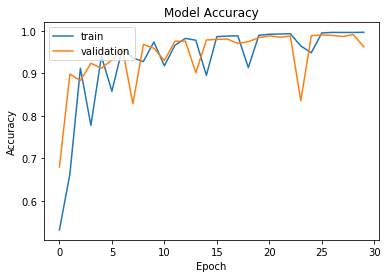

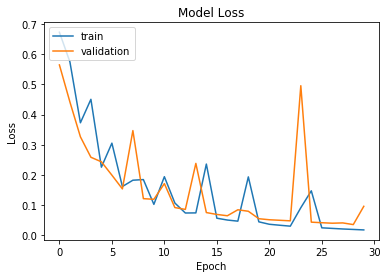

In [71]:
nn_vf_mp = nn_verifier_metrics_plotter.NNVerifierMetricsPlotter(nn_vf.history)

nn_vf_mp.plot_accuracy()
nn_vf_mp.plot_loss()

##### 2.7.9.8 Varios test de funcionamiento de la verificación

Se cargan pares de ids de vídeos de la misma persona y de diferente persona para las pruebas. Estos pares proceden del conjunto de test (ya que se considera el método fundamental de la aplicación final).

In [5]:
same_person_videos_id_pairs_list = accuracy_meter.get_same_person_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
different_person_videos_id_pairs_list = accuracy_meter.get_different_people_videos_ids_pairs(nn_vf.test_videos_embeddings_1)
# Itertools generates different combinations each time kernel is started. For this reason, we get the same lists
# ordering them and then shuffle each one with the same random seed.
same_person_videos_id_pairs_list.sort()
different_person_videos_id_pairs_list.sort()
random.shuffle(same_person_videos_id_pairs_list)
random.shuffle(different_person_videos_id_pairs_list)

In [62]:
sp_vipl_copy = same_person_videos_id_pairs_list.copy()
dp_vipl_copy = different_person_videos_id_pairs_list.copy()

random.shuffle(sp_vipl_copy)
random.shuffle(dp_vipl_copy)

print("[Same person tests]")

for ids_pair in sp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

print()
print("[Different person tests]")

for ids_pair in dp_vipl_copy[:10]:
    isp_result = nn_vf.is_same_person(ids_pair[0], ids_pair[1])
    del isp_result['results']
    print("[" + ids_pair[0] + " VS " + ids_pair[1] + ":\t" + str(isp_result) + "]")

[Same person tests]
[averobot_floor_01-53_01_02_01_02/ VS averobot_floor_03-53_03_02_28_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-11_01_02_01_02/ VS averobot_floor_03-11_03_02_10_08/:	{'is_same_person': True, 'confidence': 0.875}]
[averobot_floor_01-37_01_02_08_02/ VS averobot_floor_03-37_03_02_06_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_02-38_02_02_32_05/ VS averobot_floor_03-38_03_02_14_08/:	{'is_same_person': False, 'confidence': 0.688}]
[averobot_floor_01-09_01_02_26_02/ VS averobot_floor_02-09_02_02_33_05/:	{'is_same_person': True, 'confidence': 0.938}]
[averobot_floor_02-83_02_02_32_05/ VS averobot_floor_03-83_03_02_04_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-105_01_02_31_02/ VS averobot_floor_03-105_03_02_29_08/:	{'is_same_person': True, 'confidence': 1.0}]
[averobot_floor_01-86_01_02_10_02/ VS averobot_floor_03-86_03_02_08_08/:	{'is_same_person': True, 'confidence': 0.75}]
[averobot_floor_02-59_02_0

##### 2.7.9.9 Visualización de pares de frames fallidos (Falso negativo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-092.jpg', 'frame-059.jpg')


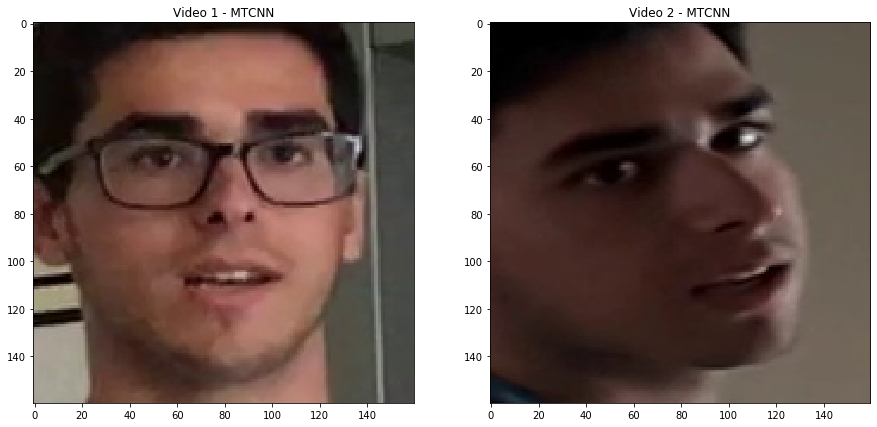

In [63]:
id_video_1 = 'averobot_floor_02-38_02_02_32_05/'
id_video_2 = 'averobot_floor_03-38_03_02_14_08/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=True,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=4,
                                                                               detector_1='mtcnn',
                                                                               use_one_detector=True)

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(1,2,2)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_2)

##### 2.7.9.10 Visualización de pares de frames fallidos (Falso positivo haciendo uso de `utils.failed_frames_pairs_generator`)

Failed frames pair example: ('frame-150.jpg', 'frame-1251.jpg')


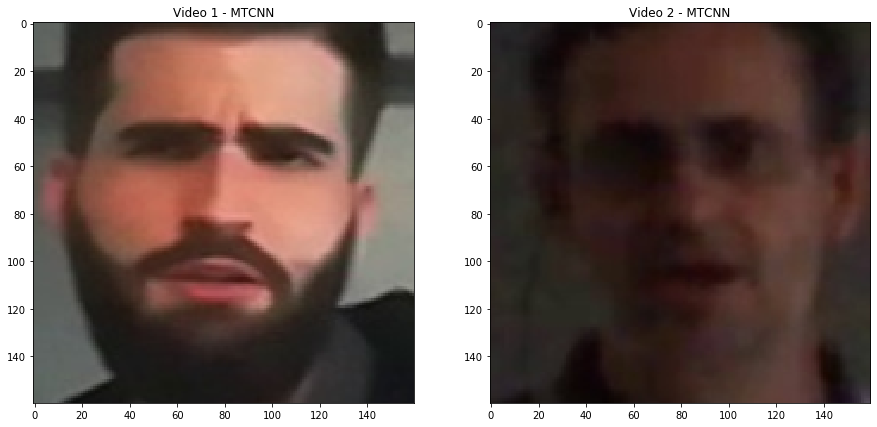

In [64]:
id_video_1 = 'averobot_floor_01-51_01_02_19_02/'
id_video_2 = 'averobot_floor_02-01_02_02_25_05/'
failed_frames_pairs = failed_frames_pairs_generator.get_nn_failed_frames_pairs(id_video_1=id_video_1,
                                                                               id_video_2=id_video_2,
                                                                               same_person=False,
                                                                               predict_results=nn_vf.is_same_person(id_video_1, 
                                                                                                                    id_video_2)['results'],
                                                                               used_frames_detector_1=4,
                                                                               detector_1='mtcnn',
                                                                               use_one_detector=True)

used_index = random.randint(0, len(failed_frames_pairs) - 1)
print("Failed frames pair example:", failed_frames_pairs[used_index])

frame_1 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_1 + failed_frames_pairs[used_index][0])
face_cut_1 = facenet_keras_model.load_pickle_results(id_video_1, embedding_type='resize')
face_box_1 = [face['box'] for index, face in enumerate(face_cut_1) if face['frame_number'] == failed_frames_pairs[used_index][0]][0]
face_box_1[2] = face_box_1[0] + face_box_1[2]
face_box_1[3] = face_box_1[1] + face_box_1[3]
embedding_frame_1 = frame_1.crop(tuple(face_box_1)).resize([160, 160])

frame_2 = Image.open(os.getenv('MAIN_ROUTE') + "/out/frames-generator/" + id_video_2 + failed_frames_pairs[used_index][1])
face_cut_2 = facenet_keras_model.load_pickle_results(id_video_2, embedding_type='resize')
face_box_2 = [face['box'] for index, face in enumerate(face_cut_2) if face['frame_number'] == failed_frames_pairs[used_index][1]][0]
face_box_2[2] = face_box_2[0] + face_box_2[2]
face_box_2[3] = face_box_2[1] + face_box_2[3]
embedding_frame_2 = frame_2.crop(tuple(face_box_2)).resize([160, 160])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title("Video 1 - MTCNN")
plt.imshow(embedding_frame_1)

plt.subplot(1,2,2)
plt.title("Video 2 - MTCNN")
plt.imshow(embedding_frame_2)

## 3. Conclusión

Gracias a este estudio sobre el **Subconjunto de Vídeos B** (parte del *dataset* ubicada en el ascensor), se ha podido realizar la ejecución de cada uno de los módulos desarrollados para comprobar su correcto funcionamiento. Además, se han conocido los resultados de la evaluación de cada uno de los prototipos desarrollados (tanto bajo la idea de la verificación basada en umbral de distancia como de la verificación basada en redes neuronales).

**Los mejores prototipos de cada una de las formas de verificación serán usados en el resto de cuadernos *Jupyter* con la finalidad de estudiar su comportamiento en entornos más complejos.**

Se podrán visualizar los resultados de los mejores sistemas en todos los subconjuntos de vídeos elegidos en la **sección 7.3** de la memoria.

El resto de conclusiones se pueden encontrar en la memoria del Trabajo de Fin de Grado (concretamente, en el **Capítulo 8**).